<a id='0'></a>
# **PyPSA-PH: A High Spatial and Temporal Resolution Open Source Model for the Philippine Power Grid**
Arizeo C. Salac *(arizeo.salac@phd.unipi.it)* | DESTEC, University of Pisa, Largo Lucio Lazzarino, 56122 Pisa, Italy

## **Introduction**

The Philippine power system is undergoing rapid transformation, driven by the need for increased renewable energy (RE) integration, grid modernization, and the pursuit of sustainable, reliable, and affordable electricity. To support these goals, advanced modeling tools are essential for analyzing the current state of the grid, evaluating future scenarios, and informing policy and investment decisions.

This notebook presents the development of a high-resolution baseline model for the Philippine power system using [PyPSA (Python for Power System Analysis)](https://pypsa.readthedocs.io/en/latest/), an open-source framework for simulating and optimizing modern energy systems. The model, referred to as PyPSA-PH, is designed to capture the unique characteristics of the Philippine grid, including its actual trading node spatial resolution and sub-daily (hourly or finer) temporal resolution. This enables detailed analysis of RE intermittency, grid bottlenecks, and operational challenges.

The workflow implemented in this notebook encompasses the following key steps:
- **Data Import and Preprocessing:** Loading and preparing network topology, generator, storage, and time series data from actual Philippine system records and relevant administrative datasets.
- **Network Construction:** Building the PyPSA network by adding buses, loads, generators, storage units, and transmission lines, with options for spatial aggregation and detailed mapping of assets.
- **Cost and Technology Mapping:** Integrating technology-specific cost data, efficiency parameters, and lifetime assumptions to ensure realistic economic modeling.
- **Temporal Resolution and Snapshots:** Setting up the model to operate at a chosen temporal granularity, allowing for the study of daily and seasonal variability in demand and renewable generation.
- **Optimization and Scenario Analysis:** Solving the baseline model using linear optimization to determine the optimal dispatch of resources, and extending the analysis to future scenarios with varying technology mixes, demand projections, and policy constraints (e.g., CO₂ reduction targets).
- **Results Visualization and Verification:** Generating plots and statistics to interpret model outputs, including network topology, dispatch profiles, generation mix, and key performance indicators such as LCOE and emissions.
- **Scenario Functions:** Providing reusable functions for projecting the network into future years, incorporating new technologies, and evaluating the impact of different policy and investment strategies.

## **Research Objectives**

*Main Objective:*  
Develop a higher-resolution baseline PyPSA model for the Philippines (PyPSA-PH) with:  
1. Actual trading node spatial resolution; and  
2. Hourly (or sub-daily) time resolution to capture RE intermittency.

*Specifically, this study aims to:*
1. Verify the model with actual generation output from the Wholesale Electricity Spot Market (WESM);
2. Compare actual WESM trading prices with model-calculated prices per trading node;
3. Identify current line loadings and potential capacity expansion needs, benchmarking against the Transmission Development Plan.

By following this workflow, the notebook provides a robust foundation for power system analysis in the Philippines, supporting both academic research and practical planning for a sustainable energy future.

**Important links/references:**  
[TU Berlin: Data Science for Energy System Modelling](https://fneum.github.io/data-science-for-esm/intro.html#jupyter.org/)  
[PyPSA Documentation and Components](https://pypsa.readthedocs.io/en/latest/user-guide/components.html)  
[PyPSA Earth Documentation](https://pypsa-earth.readthedocs.io/en/latest/)  
[GitHub PyPSA Sources](https://github.com/PyPSA)  

## Table of Contents

[01 Import Packages](#01-Import-packages)  

[02 Create Network](#02-Create-Network)  
  [02.01 Load Network Data](#02-Create-Network)  
  [02.02 Initialize the network](#02-Create-Network)  

[03 Add Network Components](#03-Add-Network-Components)  
  [03.01 Setting Time Snapshots and Temporal Resolution](#03-Add-Network-Components)  
  [03.02 Adding Loads and Load Time Series](#03-Add-Network-Components)  
  [03.03 Adding Generators and Generator Time Series](#03-Add-Network-Components)  
  [03.04 Setting up Buses and Spatial Resolution](#03-Add-Network-Components)  
  [03.05 Adding Storage Units](#03-Add-Network-Components)  
  [03.06 Adding Lines](#03-Add-Network-Components)  
  [03.07 Adding Carriers](#03-Add-Network-Components)  

[04 Optimizing the Network Baseline Model](#04-Optimizing-the-Network-Baseline-Model)  

[05 Baseline Model Results](#05-Baseline-Model-Results)  
  [05.01 Storing Baseline Model](#05-Baseline-Model-Results)  
  [05.02 Verification of Results](#05-Baseline-Model-Results)  

[06 Future Case Scenario Simulations](#06-Future-Case-Scenario-Simulations)  
  [06.01 Code Functions for Projection to Future Scenarios](#06-Future-Case-Scenario-Simulations)  
  [06.02 Definition of Functions for Future Simulations](#06-Future-Case-Scenario-Simulations)  
  [06.03 Visualize Future Scenario Results](#06-Future-Case-Scenario-Simulations)  

---

**Key Data and Variables Used in This Notebook:**

- `max_gen_potential`: Series of maximum generation potential (MW) at each snapshot.
- `microgrids_df`: DataFrame of microgrid locations, attributes, and interconnections.
- `n`: PyPSA Network object representing the Philippine power grid.
- `n_rows`: Number of rows for plotting grids.
- `name`: Example bus or district name (e.g., 'Visayas District 4').
- `norm_loadprof_df_100kW`, `norm_loadprof_df_100kWless`, `norm_loadprof_df_1MW`, `norm_loadprof_df_1MWmore`: Normalized load profile DataFrames for different system sizes.
- `p_max_pu`, `p_max_pu_series`: Per-unit maximum power time series for generators.
- `peak_load_df`: DataFrame with population and peak load estimates for islands.
- `philippines_shapes`: GeoDataFrame of administrative boundaries and regions.
- `power_curve_func`: Wind turbine power curve interpolation function.
- `power_output`: Array of wind turbine power output values.
- `reverse_tech_map`, `tech_map`: Dictionaries mapping technology names between model and data.
- `row`: Example DataFrame row (e.g., for a transmission line).
- `scaled_solar_p_max_pu`, `scaled_wind_p_max_pu`: Scaled per-unit time series for solar and wind.
- `shapefile`: Path to shapefile for geospatial analysis.
- `snapshots`: DatetimeIndex of simulation snapshots (e.g., 3-hourly for 2023).
- `solar_GHI_df`: DataFrame of solar GHI values for microgrids.
- `storageunits_df`: DataFrame of storage unit metadata.
- `tech`: Example technology string (e.g., 'Pumped-Storage-Hydro-store').
- `wind_speed_df`: DataFrame of wind speeds for microgrids.
- `wind_speed_series`, `wind_speeds`: Series/array of wind speed values.
- `year`: Model reference year (e.g., 2020).

Refer to the variable summaries above for context when navigating or modifying the notebook.


<a id="01-Import-packages"></a>
### 01 Import 

This section imports all necessary Python packages and libraries required for data processing, power system modeling, geospatial analysis, and visualization. These packages provide the foundational tools for building, analyzing, and visualizing the PyPSA-PH baseline model.

In [77]:
import pypsa
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from pypsa.plot import add_legend_patches
import os
import glob

<a id="02-Create-Network"></a>
### 02 Create Network

This section covers the creation of the PyPSA-PH network, including loading network data, initializing the PyPSA network object, and preparing the structure for adding buses, loads, generators, storage units, and transmission lines. The steps here lay the foundation for building a detailed and high-resolution model of the Philippine power system.

#### 02.01 Load Network Data

In [78]:
buses_df = pd.read_csv('data/buses.csv')
storageunits_df = pd.read_csv('data/storageunits.csv')
generators_df = pd.read_csv('data/generators.csv')
lines_df = pd.read_csv('data/lines.csv')
loads_time_series_df = pd.read_csv('data/loads_t.csv', index_col=0, parse_dates=True, date_format='%m/%d/%y %H:%M')
generators_time_series_df = pd.read_csv('data/generators_t.csv', index_col=0, parse_dates=True, date_format='%m/%d/%y %H:%M')
area_df = pd.read_csv('data/admin_regions.csv')
future_loads = pd.read_csv('data/area_data_future.csv').set_index('Area')
district_RE = pd.read_csv('data/district_RE.csv',index_col=0, parse_dates=True, date_format='%m/%d/%y %H:%M')

In [79]:
# Load costs data
def calc_annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

def get_costs_data(year):
    path = f"data/Cost_Data_2020-2050/costs_{year}.csv"
    costs_data = pd.read_csv(path, delimiter=",")
    costs_data.loc[costs_data.unit.str.contains("/kW"), "value"] *= 1e3
    costs_data.unit = costs_data.unit.str.replace("/kW", "/MW")
    costs_data.set_index(['technology', 'parameter'], inplace=True)
    defaults = {
        "FOM": 0, "VOM": 0, "efficiency": 1, "fuel": 0, "investment": 0,
        "lifetime": 25, "CO2 intensity": 0, "discount rate": 0.07,
    }
    costs_data = costs_data.value.unstack().fillna(defaults)

    #Pre-assignment of lost data:
    costs_data.at["geothermal", "investment"] = 262580.50 # 0.29M-USD/MW assumed for all year https://www.geothermal-energy.org/pdf/IGAstandard/INAGA/2001/2001-27.pdf

    # Calculations
    annuity = costs_data.apply(lambda x: calc_annuity(x["discount rate"], x["lifetime"]), axis=1)
    costs_data["capital_cost"] = (annuity + costs_data["FOM"] / 100) * costs_data["investment"]
    costs_data["marginal_cost"] = costs_data["VOM"] + costs_data["fuel"] / costs_data["efficiency"]

    # Specific assignments
    costs_data.at["solid biomass boiler steam", "fuel"] = costs_data.at["solid biomass", "fuel"]
    costs_data.at["solid biomass boiler steam", "CO2 intensity"] = costs_data.at["solid biomass", "CO2 intensity"]
    costs_data.at["gas boiler steam", "fuel"] = costs_data.at["gas", "fuel"]
    costs_data.at["gas boiler steam", "CO2 intensity"] = costs_data.at["gas", "CO2 intensity"]
    costs_data.at["battery storage", "marginal_cost"] = costs_data.at["battery storage", "marginal_cost"] + costs_data.at["battery inverter", "marginal_cost"]*4
    costs_data.at["battery storage", "capital_cost"] = costs_data.at["battery storage", "capital_cost"] + costs_data.at["battery inverter", "capital_cost"]*4
    costs_data.at["battery storage", "efficiency"] = costs_data.at["battery inverter", "efficiency"]
    costs_data.at["Pumped-Storage-Hydro-store", "marginal_cost"] = costs_data.at["Pumped-Storage-Hydro-store", "marginal_cost"] + costs_data.at["Pumped-Storage-Hydro-bicharger", "marginal_cost"]*6
    costs_data.at["Pumped-Storage-Hydro-store", "capital_cost"] = costs_data.at["Pumped-Storage-Hydro-store", "capital_cost"] + costs_data.at["Pumped-Storage-Hydro-bicharger", "capital_cost"]*6
    costs_data.at["Pumped-Storage-Hydro-store", "efficiency"] = costs_data.at["Pumped-Storage-Hydro-bicharger", "efficiency"]

    return costs_data

year = 2020
costs_data = get_costs_data(year)

In [80]:
tech_map = {
    "Gas": "gas boiler steam", "Solar": "solar", "Wind": "onwind",
    "Diesel": "oil", "Coal": "coal", "Hydro": "hydro", "Geothermal": "geothermal",
    "Biomass": "solid biomass boiler steam", "ROR":"ror", "Battery": "battery storage", 
    "Pump Hydro":"Pumped-Storage-Hydro-store"}

reverse_tech_map = {v: k for k, v in tech_map.items()}

#### 02.02 Initialize the network

In [81]:
n = pypsa.Network()

### 03 Add Network Components

This section details the process of adding key components to the PyPSA-PH network, including buses, loads, generators, storage units, and transmission lines. Each component is integrated with relevant time series data and technical parameters to accurately represent the Philippine power system's structure and operation.

#### 03.01 Setting Time Snapshots and Temporal Resolution

This step sets the temporal resolution for the simulation by resampling the load and generator time series data to a specified frequency (e.g., every 3 hours = '3h'). It then defines the model's snapshots, which represent the time intervals over which the network will be simulated, ensuring consistency between the time series data and the network's operational timeline.

In [82]:
# Setting temporal resolution, this can be adjusted as needed
freq = '3h'

# Resample the time series data to daily resolution (or modify as needed)
loads_time_series_df = loads_time_series_df.resample(freq).mean()
generators_time_series_df = generators_time_series_df.resample(freq).mean()

# Adjust snapshots for daily resolution
snapshots = pd.date_range(start="2023-01-01 00:00:00", end="2023-12-31 23:00:00", freq=freq)
n.set_snapshots(snapshots)

#### 03.02 Adding Loads and Load Time Series

This step integrates the processed load time series data into the PyPSA network. Each bus is assigned a corresponding load, and the time-varying demand profiles are set using the resampled `loads_time_series_df`. This ensures that the network accurately represents the spatial and temporal distribution of electricity demand across all nodes for the simulation period.

The network allows for flexible spatial aggregation of loads and buses to match different administrative or planning boundaries. By setting the `AGGREGATE_BUSES` variable, users can control whether and how the buses are aggregated:

- Set to `False` to use the original, unaggregated bus structure (each bus represents a physical node).
- Set to a specific code to aggregate buses and loads according to a chosen scheme:
    - `'adm1_en'`: Aggregate by Administrative Regions.
    - `'adm2_en'`: Aggregate by Administrative Provinces.
    - `'custom_TDP1'`: Aggregate by NGCP Regional Transmission Groups.
    - `'custom_TDP2'`: Aggregate by NGCP Transmission Districts.

This approach enables the model to be adapted for analyses at different spatial resolutions, from detailed nodal studies to higher-level regional planning.

In [83]:
AGGREGATE_BUSES = 'custom_TDP2'

In [84]:
if AGGREGATE_BUSES:
    shapefile = 'data/PH_Adm2_ProvDists'
    philippines_shapes = gpd.read_file(shapefile).to_crs(epsg=4326)
    philippines_shapes.adm2_en = area_df[AGGREGATE_BUSES]
    combined_gdf = philippines_shapes.dissolve(by='adm2_en') 

    buses_gdf = gpd.GeoDataFrame(buses_df, geometry=gpd.points_from_xy(buses_df.x, buses_df.y), crs=combined_gdf.crs)
    buses_gdf = buses_gdf.to_crs(combined_gdf.crs)

    buses_gdf = buses_gdf.drop(columns=['index_left', 'index_right'], errors='ignore')
    combined_gdf = combined_gdf.drop(columns=['index_left', 'index_right'], errors='ignore')

    buses_gdf = gpd.sjoin(buses_gdf, combined_gdf, how="left", predicate="within")
    buses_gdf = buses_gdf.rename(columns={buses_gdf.columns[0]: 'name'})

    grouped_buses = buses_gdf.groupby("adm2_en")

    for name, group in grouped_buses:
        aggregated_bus = {
            'name': f'{name}',
            'x': group.geometry.x.mean(),
            'y': group.geometry.y.mean(),
            'v_nom': group['v_nom'].max()}
        n.add("Bus", **aggregated_bus)

    aggregated_loads_t = pd.DataFrame(index=loads_time_series_df.index)
    for name, group in grouped_buses:
        load_columns = group['name'].tolist()
        aggregated_loads_t[f'{name}'] = loads_time_series_df[load_columns].sum(axis=1)

    n.loads_t.p_set = aggregated_loads_t
    for load in n.loads_t.p_set.columns:
        n.add("Load", load, bus=load)

    bus_mapping = {old_bus: new_bus for new_bus, group in grouped_buses for old_bus in group['name']}

else:
    # No aggregation: directly add buses
    for _, row in buses_df.iterrows():
        n.add("Bus", name=row['name'], x=row['x'], y=row['y'], v_nom=row['v_nom'])

    # No aggregation: assign raw loads and buses
    n.loads_t.p_set = loads_time_series_df
    for load in n.loads_t.p_set.columns:
        n.add("Load", load, bus=load)

    # Mapping is identity
    bus_mapping = {bus: bus for bus in buses_df['name']}


#### 03.03 Adding Generators and Generator Time Series

In [85]:
if AGGREGATE_BUSES:
    # Define mapping from original buses to aggregated ones
    bus_mapping = {old_bus: new_bus for new_bus, group in grouped_buses for old_bus in group['name']}
else:
    # No aggregation: map each bus to itself
    bus_mapping = {bus: bus for bus in generators_df['bus'].unique()}

# Update the generators with the new bus connections
for index, row in generators_df.iterrows():
    tech = tech_map.get(row['carrier'])
    n.add("Generator", name=row['name'], bus=bus_mapping.get(row['bus'], row['bus']), 
          p_nom=row['p_nom'], carrier=row['carrier'],
          efficiency=costs_data.at[tech, "efficiency"], 
          marginal_cost=costs_data.at[tech, "marginal_cost"],
          capital_cost=costs_data.at[tech, "capital_cost"],
          lifetime=row['build_year']+costs_data.at[tech, "lifetime"],
          p_nom_extendable=False)

# Assign all time series data for generators
n.generators_t.p_max_pu = generators_time_series_df

#### 03.04 Setting up Buses and Spatial Resolution

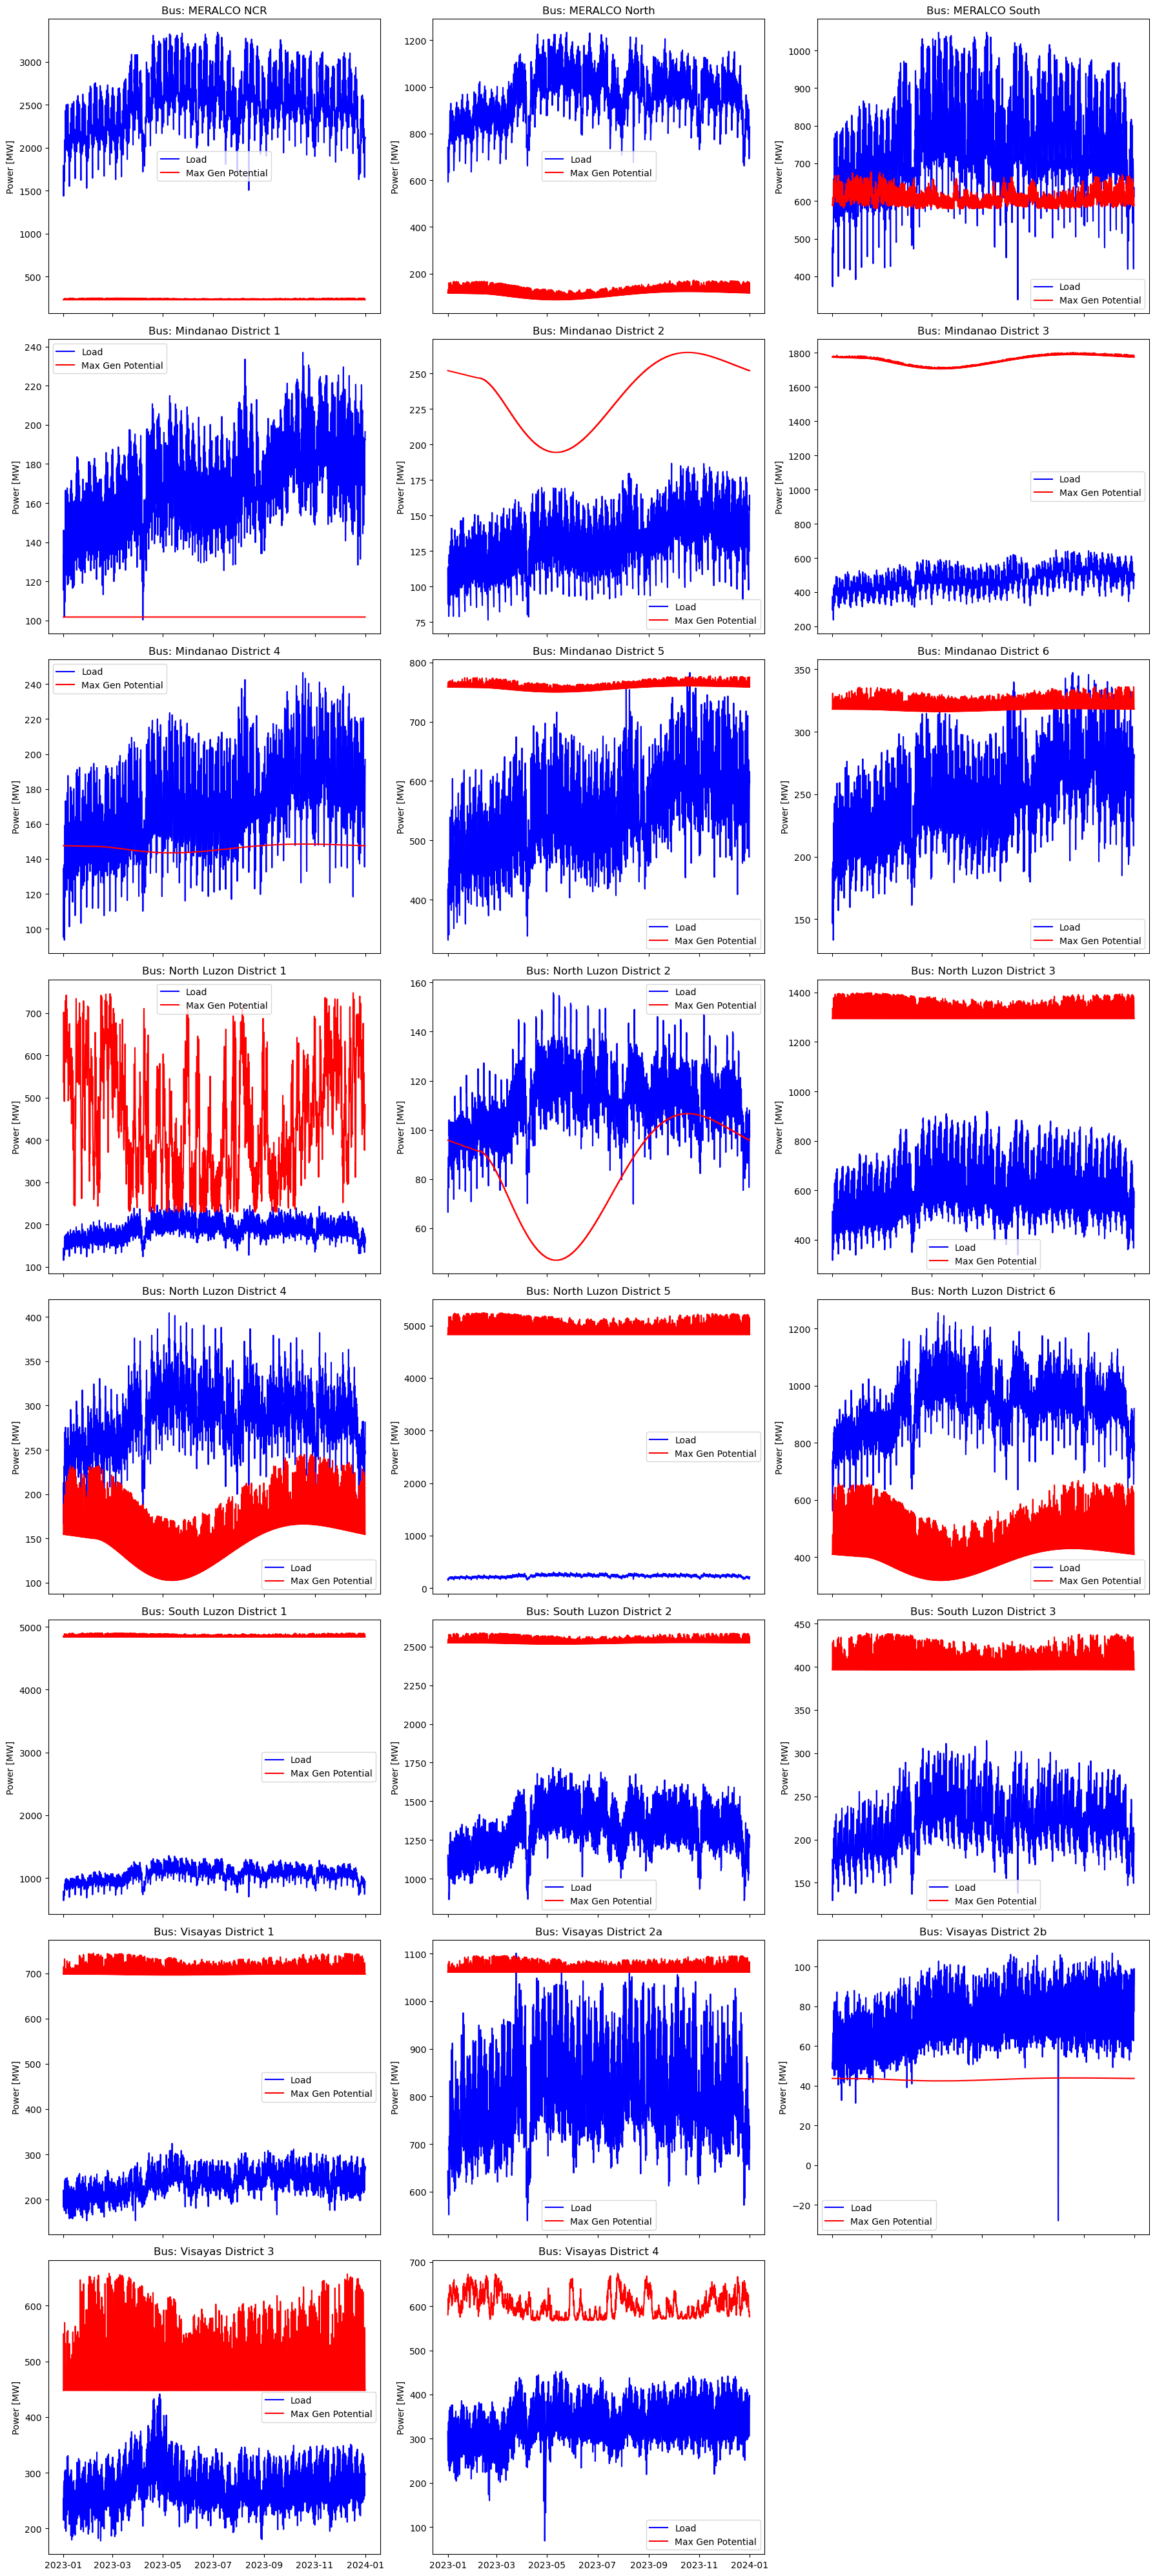

In [86]:
# Get all unique buses in the network
buses = n.buses.index

# Set up the plotting grid with 3 columns
n_rows = (len(buses) + 2) // 3  # Calculate the number of rows needed
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5 * n_rows), sharex=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop over each bus
for i, bus in enumerate(buses):
    ax = axes[i]
    
    # Plot the load curve
    if bus in n.loads.bus.values:
        load_at_bus = n.loads_t.p_set.loc[:, n.loads[n.loads.bus == bus].index].sum(axis=1)
        ax.plot(n.snapshots, load_at_bus, label='Load', color='blue')

    # Plot the time series of maximum generation potential
    if bus in n.generators.bus.values:
        gens_at_bus = n.generators[n.generators.bus == bus]
        max_gen_potential = (n.generators_t.p_max_pu.loc[:, gens_at_bus.index] * gens_at_bus.p_nom).sum(axis=1)
        ax.plot(n.snapshots, max_gen_potential, label='Max Gen Potential', color='red')

    # Title and labels
    ax.set_title(f'Bus: {bus}')
    ax.set_ylabel('Power [MW]')
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 03.05 Adding Storage Units

In [87]:
for index, row in storageunits_df.iterrows():
    tech = tech_map.get(row['carrier'])
    bus = bus_mapping.get(row['bus'], row['bus'])
    
    # Check if the bus exists in the network
    if bus not in n.buses.index:
        # Add the bus if it doesn't exist
        n.add("Bus", name=bus)
    
    # Add the storage unit
    n.add("StorageUnit", row['name'], bus=bus, 
          p_nom=row['p_nom'], carrier=row['carrier'],
          max_hours=4, efficiency_dispatch=costs_data.at[tech, "efficiency"],
          efficiency_store=costs_data.at[tech, "efficiency"],
          capital_cost=costs_data.at[tech, "capital_cost"],
          marginal_cost=costs_data.at[tech, "marginal_cost"],
          lifetime=row['build_year']+costs_data.at[tech, "lifetime"],
          p_nom_extendable=False)

#### 03.06 Adding Lines

In [88]:
# Correct the code for adding lines to use the `bus_mapping`
def get_standard_current(voltage):
    if 60 <= voltage < 100:
        return 550  # for voltages roughly in the 69 kV range
    elif 100 <= voltage < 200:
        return 900  # for voltages roughly in the 138 kV range
    elif 200 <= voltage < 400:
        return 1100 # for voltages roughly in the 230 kV range
    elif 400 <= voltage <= 500:
        return 1750 # for voltages roughly in the 500 kV range
    else:
        return 1000 # default or estimate for other voltages

def calculate_s_nom_from_voltage(voltage):
    I = get_standard_current(voltage)
    S_nom = 1.732 * voltage * I / 1000 # S_nom in MVA if voltage in kV, I in A
    return S_nom

for index, row in lines_df.iterrows():
    bus0 = bus_mapping.get(row['bus0'], row['bus0'])
    bus1 = bus_mapping.get(row['bus1'], row['bus1'])
    if not (bus0 == bus1):
        for i in range(int(row['cables']), 0, -1):
            n.add("Line", f"{row['name']}_{i}", bus0=bus0, bus1=bus1,
                  x=row['x'], r=row['r'], 
                  s_nom= calculate_s_nom_from_voltage(row['s_nom']), 
                  s_nom_extendable=True)

#### 03.07 Adding Carriers

In [89]:
carrier_list = n.generators.carrier.unique()
for carrier in carrier_list:
        n.add("Carrier", carrier, co2_emissions=costs_data.at[tech_map.get(carrier), 'CO2 intensity'])
n.add("Carrier", "AC", co2_emissions=0)
n.add("Carrier", "Battery", co2_emissions=0)
n.add("Carrier", "Pump Hydro", co2_emissions=0)

In [90]:
carrier_colors = {
    "Biomass": '#127E2A',
    "Hydro": '#1E81D4',
    "Coal": '#342C27',
    "Solar": '#FDB324',
    "Wind": '#3BBFE5',
    "Diesel": '#B41E25',
    "Gas": '#564A41',
    "Geothermal": '#E6622D',
    "ROR": '#8ab2d4',
    "Battery": '#814ad4',
    "Pump Hydro": '#104775'}

for carrier, color in carrier_colors.items():
    n.carriers.loc[carrier, 'color'] = color

### 04 Optimizing the Network Baseline Model

This section focuses on optimizing the baseline PyPSA-PH network model. Here, the model is solved using a linear optimization solver to determine the optimal dispatch of generators, storage, and transmission assets, subject to technical and economic constraints. The results provide insights into system operation, bottlenecks, and the cost-effectiveness of the current network configuration. Subsequent cells also include exporting results, analyzing infeasibilities, and visualizing key outputs to verify and interpret the optimization outcomes.

In [91]:
# Optimize the network, select solver as needed
n.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-13


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-05-13
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]
INFO:linopy.io: Writing time: 28.29s


Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-8bfo4rs_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-8bfo4rs_.lp


Reading time = 8.79 seconds


INFO:gurobipy:Reading time = 8.79 seconds


obj: 3886624 rows, 1755024 columns, 6900040 nonzeros


INFO:gurobipy:obj: 3886624 rows, 1755024 columns, 6900040 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Apple M1


INFO:gurobipy:CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 3886624 rows, 1755024 columns and 6900040 nonzeros


INFO:gurobipy:Optimize a model with 3886624 rows, 1755024 columns and 6900040 nonzeros


Model fingerprint: 0xaabeb031


INFO:gurobipy:Model fingerprint: 0xaabeb031


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [4e-01, 2e+02]


INFO:gurobipy:  Matrix range     [4e-01, 2e+02]


  Objective range  [1e-02, 2e+02]


INFO:gurobipy:  Objective range  [1e-02, 2e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e-04, 3e+03]


INFO:gurobipy:  RHS range        [2e-04, 3e+03]


Presolve removed 3799024 rows and 1439373 columns


INFO:gurobipy:Presolve removed 3799024 rows and 1439373 columns


Presolve time: 4.56s


INFO:gurobipy:Presolve time: 4.56s


Presolved: 87600 rows, 315651 columns, 611927 nonzeros


INFO:gurobipy:Presolved: 87600 rows, 315651 columns, 611927 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Free vars  : 14600


INFO:gurobipy: Free vars  : 14600


 AA' NZ     : 1.255e+05


INFO:gurobipy: AA' NZ     : 1.255e+05


 Factor NZ  : 9.196e+05 (roughly 120 MB of memory)


INFO:gurobipy: Factor NZ  : 9.196e+05 (roughly 120 MB of memory)


 Factor Ops : 1.655e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.655e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.60987874e+10 -1.06425135e+11  2.62e+04 1.19e+02  4.08e+06     5s


INFO:gurobipy:   0   1.60987874e+10 -1.06425135e+11  2.62e+04 1.19e+02  4.08e+06     5s


   1   2.75072046e+09 -6.04983823e+10  2.40e+03 1.87e-02  4.65e+05     5s


INFO:gurobipy:   1   2.75072046e+09 -6.04983823e+10  2.40e+03 1.87e-02  4.65e+05     5s


   2   1.34640193e+09 -1.98998012e+10  9.01e+01 3.41e-03  5.82e+04     6s


INFO:gurobipy:   2   1.34640193e+09 -1.98998012e+10  9.01e+01 3.41e-03  5.82e+04     6s


   3   8.74937324e+08 -4.89521115e+09  2.32e+00 9.74e-04  1.36e+04     6s


INFO:gurobipy:   3   8.74937324e+08 -4.89521115e+09  2.32e+00 9.74e-04  1.36e+04     6s


   4   7.08542704e+08 -4.35718567e+08  2.08e-01 1.03e-03  2.68e+03     6s


INFO:gurobipy:   4   7.08542704e+08 -4.35718567e+08  2.08e-01 1.03e-03  2.68e+03     6s


   5   5.96733675e+08  3.32378190e+08  2.86e-02 5.40e-04  6.19e+02     6s


INFO:gurobipy:   5   5.96733675e+08  3.32378190e+08  2.86e-02 5.40e-04  6.19e+02     6s


   6   5.58881697e+08  4.93908534e+08  7.17e-03 3.22e-04  1.52e+02     6s


INFO:gurobipy:   6   5.58881697e+08  4.93908534e+08  7.17e-03 3.22e-04  1.52e+02     6s


   7   5.43693616e+08  5.28906430e+08  1.85e-03 2.11e-04  3.46e+01     6s


INFO:gurobipy:   7   5.43693616e+08  5.28906430e+08  1.85e-03 2.11e-04  3.46e+01     6s


   8   5.37498406e+08  5.36004506e+08  9.60e-05 1.35e-04  3.50e+00     6s


INFO:gurobipy:   8   5.37498406e+08  5.36004506e+08  9.60e-05 1.35e-04  3.50e+00     6s


   9   5.36892059e+08  5.36795884e+08  3.29e-06 5.11e-05  2.25e-01     6s


INFO:gurobipy:   9   5.36892059e+08  5.36795884e+08  3.29e-06 5.11e-05  2.25e-01     6s


  10   5.36855435e+08  5.36845207e+08  2.08e-07 1.07e-05  2.40e-02     6s


INFO:gurobipy:  10   5.36855435e+08  5.36845207e+08  2.08e-07 1.07e-05  2.40e-02     6s


  11   5.36850872e+08  5.36849210e+08  1.09e-08 2.82e-06  3.89e-03     6s


INFO:gurobipy:  11   5.36850872e+08  5.36849210e+08  1.09e-08 2.82e-06  3.89e-03     6s


  12   5.36850522e+08  5.36850515e+08  4.55e-12 9.81e-08  1.62e-05     7s


INFO:gurobipy:  12   5.36850522e+08  5.36850515e+08  4.55e-12 9.81e-08  1.62e-05     7s


  13   5.36850519e+08  5.36850519e+08  4.09e-12 1.57e-11  6.03e-11     7s


INFO:gurobipy:  13   5.36850519e+08  5.36850519e+08  4.09e-12 1.57e-11  6.03e-11     7s


INFO:gurobipy:


Barrier solved model in 13 iterations and 6.63 seconds (4.45 work units)


INFO:gurobipy:Barrier solved model in 13 iterations and 6.63 seconds (4.45 work units)


Optimal objective 5.36850519e+08


INFO:gurobipy:Optimal objective 5.36850519e+08


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   40880 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:   40880 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:


   11680 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:   11680 PPushes remaining with PInf 0.0000000e+00                 7s


       0 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.1382709e-11      7s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.1382709e-11      7s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   52563    5.3685052e+08   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:   52563    5.3685052e+08   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2927 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:    2927 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:


   10231 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:   10231 PPushes remaining with PInf 0.0000000e+00                 7s


       0 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3847008e-10      7s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3847008e-10      7s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   65724    5.3685052e+08   0.000000e+00   0.000000e+00     10s


INFO:gurobipy:   65724    5.3685052e+08   0.000000e+00   0.000000e+00     10s


INFO:gurobipy:


Solved in 65724 iterations and 9.73 seconds (6.16 work units)


INFO:gurobipy:Solved in 65724 iterations and 9.73 seconds (6.16 work units)


Optimal objective  5.368505189e+08


INFO:gurobipy:Optimal objective  5.368505189e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1755024 primals, 3886624 duals
Objective: 5.37e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-ext-s-lower, Line-ext-s-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

### 05 Baseline Model Results

This section presents the results of the baseline PyPSA-PH model simulation. It includes key performance indicators such as network statistics, exported model files, visualizations of network topology, generation dispatch, generation mix, and verification of results. These outputs provide insights into the operational characteristics, bottlenecks, and overall performance of the current power system configuration in the Philippines.

#### 05.01 Storing Baseline Model

In [92]:
n.statistics()

Optimal Capacity  Installed Capacity        Supply  \
Generator   Biomass           466.100000            466.1000  1.361012e+06   
            Coal            12374.100000          12374.1000  1.614035e+07   
            Diesel           2811.400000           2811.4000  0.000000e+00   
            Gas              3732.300000           3732.3000  1.089832e+07   
            Geothermal       1754.900000           1754.9000  5.124308e+06   
            Hydro            1966.500000           1966.5000  1.200241e+06   
            ROR              1067.500000           1067.5000  6.515420e+05   
            Solar            2271.300000           2271.3000  1.065691e+06   
            Wind              569.500000            569.5000  6.452306e+05   
Line        AC              37178.697476          47095.8512  6.249242e+07   
Load        -                   0.000000              0.0000  3.720684e+01   
StorageUnit Battery           597.000000            597.0000  0.000000e+00   
            Pump Hydro        735.600000            735.6000  0.000000e+00   

                          Withdrawal      Dispatch  Transmission  \
Generator   Biomass     0.000000e+00  1.361012e+06  0.000000e+00   
            Coal        0.000000e+00  1.614035e+07  0.000000e+00   
            Diesel      0.000000e+00  0.000000e+00  0.000000e+00   
            Gas         0.000000e+00  1.089832e+07  0.000000e+00   
            Geothermal  0.000000e+00  5.124308e+06  0.000000e+00   
            Hydro       0.000000e+00  1.200241e+06  0.000000e+00   
            ROR         0.000000e+00  6.515420e+05  0.000000e+00   
            Solar       0.000000e+00  1.065691e+06  0.000000e+00   
            Wind        0.000000e+00  6.452306e+05  0.000000e+00   
Line        AC          6.249242e+07  0.000000e+00  5.081456e+06   
Load        -           3.708673e+07 -3.708669e+07  0.000000e+00   
StorageUnit Battery     0.000000e+00  0.000000e+00  0.000000e+00   
            Pump Hydro  0.000000e+00  0.000000e+00  0.000000e+00   

                        Capacity Factor   Curtailment  Capital Expenditure  \
Generator   Biomass            1.000000  0.000000e+00         4.071566e+07   
            Coal               0.446700  1.999202e+07         4.172646e+09   
            Diesel             0.000000  8.197608e+06         1.137464e+08   
            Gas                1.000000  0.000000e+00         2.510852e+07   
            Geothermal         1.000000  0.000000e+00         4.635047e+07   
            Hydro              0.209022  4.508516e-08         3.592771e+08   
            ROR                0.209022  1.284238e-08         3.289719e+08   
            Solar              0.160685  1.887141e-07         1.710830e+08   
            Wind               0.388006  1.004982e-07         6.468620e+07   
Line        AC                 0.575639  0.000000e+00         0.000000e+00   
Load        -                       NaN  0.000000e+00         0.000000e+00   
StorageUnit Battery            0.000000  0.000000e+00         1.123436e+08   
            Pump Hydro         0.000000  0.000000e+00         5.037580e+08   

                        Operational Expenditure       Revenue  Market Value  
Generator   Biomass                3.808792e+06  4.384272e+07  3.221332e+01  
            Coal                   5.199342e+08  5.199342e+08  3.221332e+01  
            Diesel                 0.000000e+00  0.000000e+00  0.000000e+00  
            Gas                    1.207206e+07  3.510710e+08  3.221332e+01  
            Geothermal             0.000000e+00  1.650710e+08  3.221332e+01  
            Hydro                  0.000000e+00  3.866375e+07  3.221332e+01  
            ROR                    0.000000e+00  2.098833e+07  3.221332e+01  
            Solar                  1.129633e+04  3.432946e+07  3.221332e+01  
            Wind                   1.024175e+06  2.078502e+07  3.221332e+01  
Line        AC                     0.000000e+00  0.000000e+00  6.799479e-16  
Load        -              

In [93]:
n.export_to_netcdf("results/PyPSA-PH.nc")

INFO:pypsa.io:Exported network PyPSA-PH.nc has loads, buses, storage_units, generators, carriers, lines


<xarray.Dataset>
Dimensions:                            (snapshots: 2920, investment_periods: 0,
                                        loads_i: 23, loads_t_p_set_i: 23,
                                        loads_t_p_i: 23, buses_i: 23,
                                        buses_t_p_i: 23, buses_t_v_ang_i: 23,
                                        buses_t_marginal_price_i: 23,
                                        storage_units_i: 24,
                                        storage_units_t_state_of_charge_i: 24,
                                        generators_i: 425,
                                        generators_t_p_max_pu_i: 165,
                                        generators_t_p_i: 305, carriers_i: 12,
                                        lines_i: 104, lines_t_p0_i: 104,
                                        lines_t_p1_i: 104)
Coordinates: (12/18)
  * snapshots                          (snapshots) int64 0 1 2 ... 2918 2919
  * investment_periods                 (investment_periods) int64 
  * loads_i                            (loads_i) object 'MERALCO NCR' ... 'Vi...
  * loads_t_p_set_i                    (loads_t_p_set_i) object 'MERALCO NCR'...
  * loads_t_p_i                        (loads_t_p_i) object 'MERALCO NCR' ......
  * buses_i                            (buses_i) object 'MERALCO NCR' ... 'Vi...
    ...                                 ...
  * generators_t_p_max_pu_i            (generators_t_p_max_pu_i) object '01AM...
  * generators_t_p_i                   (generators_t_p_i) object '01ACNPC_G01...
  * carriers_i                         (carriers_i) object 'Biomass' ... 'Pum...
  * lines_i                            (lines_i) object '230_01SNESTBN_01BAKU...
  * lines_t_p0_i                       (lines_t_p0_i) object '230_01SNESTBN_0...
  * lines_t_p1_i                       (lines_t_p1_i) object '230_01SNESTBN_0...
Data variables: (12/53)
    snapshots_snapshot                 (snapshots) datetime64[ns] 2023-01-01 ...
    snapshots_objective                (snapshots) float64 1.0 1.0 ... 1.0 1.0
    snapshots_stores                   (snapshots) float64 1.0 1.0 ... 1.0 1.0
    snapshots_generators               (snapshots) float64 1.0 1.0 ... 1.0 1.0
    investment_periods_objective       (investment_periods) object 
    investment_periods_years           (investment_periods) object 
    ...                                 ...
    lines_x_pu_eff                     (lines_i) float64 0.000115 ... 0.0001201
    lines_r_pu_eff                     (lines_i) float64 0.0002384 ... 0.000249
    lines_s_nom_opt                    (lines_i) float64 28.22 45.39 ... 314.1
    lines_v_nom                        (lines_i) float64 230.0 230.0 ... 230.0
    lines_t_p0                         (snapshots, lines_t_p0_i) float64 12.8...
    lines_t_p1                         (snapshots, lines_t_p1_i) float64 -12....
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           536850518.9214988
    network_objective_constant:  0.0
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

In [94]:
n.generators.carrier.unique()

array(['Biomass', 'Hydro', 'Coal', 'ROR', 'Solar', 'Wind', 'Diesel',
       'Gas', 'Geothermal'], dtype=object)

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



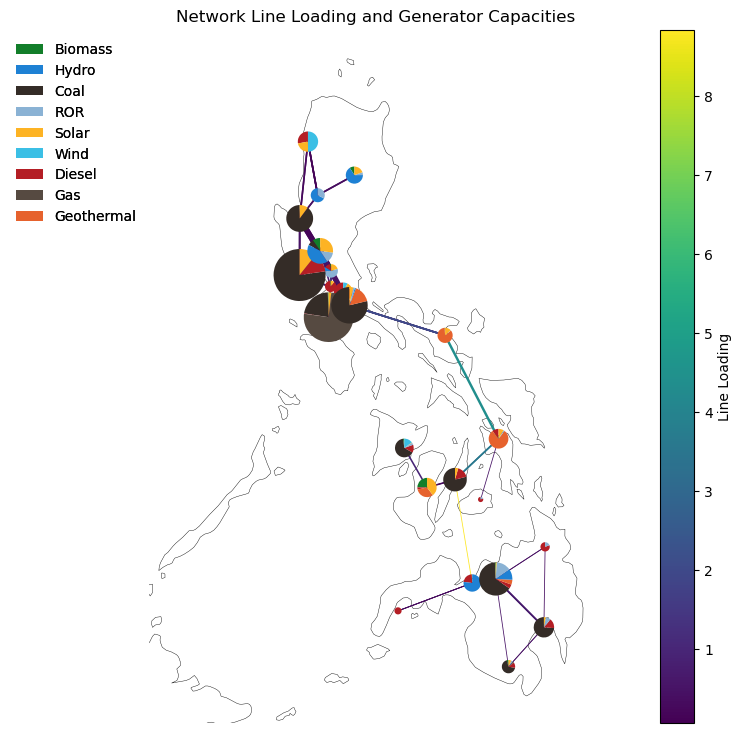

In [95]:
def plot_network(n,show_buses=True,show_loading=True,show_linecap=True):
    # Calculate bus generation capacities
    capacities = n.generators.groupby(["bus", "carrier"]).p_nom_opt.sum()
    
    # Calculate line loading
    n.lines['loading'] = n.lines_t.p0.abs().max() / n.lines.s_nom
    
    # Plotting the network with line loadings
    fig = plt.figure(figsize=(15, 9))
    ax = plt.axes(projection=ccrs.Mercator())
    
    n.plot(
        ax=ax,
        line_colors=n.lines['loading'] if show_loading==True else 10,
        line_cmap=plt.cm.viridis,
        line_widths=n.lines.s_nom.div(n.lines.s_nom.max()/.04e2)  if show_linecap==True else 10,  # Adjust this multiplier for better visibility
        bus_sizes=capacities / (capacities.max()*4)  if show_buses==True else 10, #Set to capacities if you want to see generator mix
        boundaries=(117, 127, 5, 20)  # Adjust the boundaries as per your region
    )

    if show_loading==True:
        # Add a colorbar for the line loading
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=n.lines['loading'].min(), vmax=n.lines['loading'].max()))
        sm._A = []
        plt.colorbar(sm, ax=ax, orientation='vertical', label='Line Loading')
    
    if show_buses==True:
        # Ensure that the colors and labels are aligned
        unique_carriers = n.generators.carrier.unique()
        carrier_colors = [n.carriers.loc[carrier, 'color'] for carrier in unique_carriers if carrier in n.carriers.index]

        # Add legend patches for the generators
        add_legend_patches(
            ax, carrier_colors, unique_carriers, legend_kw=dict(frameon=False, bbox_to_anchor=(0, 1))
        )
    
    plt.title('Network Line Loading and Generator Capacities')
    plt.show()

plot_network(n,show_buses=True,show_loading=True,show_linecap=True)

/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/ipykernel_15946/466612590.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



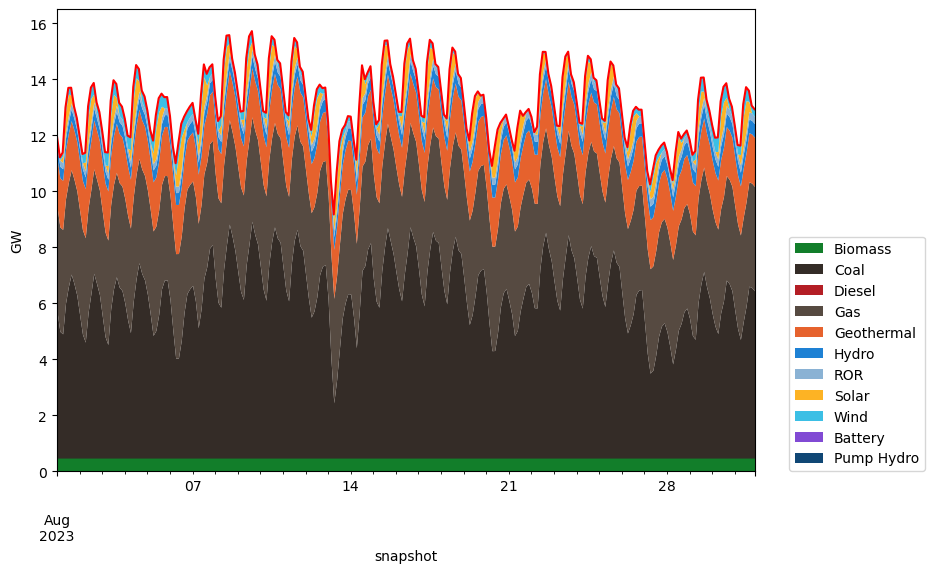

In [96]:
def plot_dispatch(n, time="2023"):
    # Sum the power generation by carrier and convert to GW
    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)

    # Include storage units if they exist
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.groupby(n.storage_units.carrier).sum().T.div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)

    # Include hydrogen store if they exist
    if not n.stores.empty:
        sto_h = n.stores_t.p.T.groupby(n.stores.carrier).sum().T.div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto_h], axis=1)

    fig, ax = plt.subplots(figsize=(9, 6))

    color = p_by_carrier.columns.map(n.carriers.color)

    # Plot positive values
    #print(p_by_carrier.where(p_by_carrier > 0).loc[time].head(24))
    p_by_carrier.where(p_by_carrier > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )

    # Plot negative values (charging)
    charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).loc[time]
    #print(charge.head(24))
    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
        )

    # Plot the load
    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="r")

    # Calculate the data range for setting y-limits
    max_peak = p_by_carrier.where(p_by_carrier > 0).loc[time].sum(axis=1).max()
    min_peak = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).sum(axis=1).min()
    
    # Set the y-axis limits with 10% padding
    y_max = max_peak * 1.05
    y_min = min_peak * 1.05 if min_peak < 0 else min_peak * 0

    ax.set_ylim(y_min, y_max)

    # Adjust the legend and labels
    plt.legend(loc=(1.05, 0))
    ax.set_ylabel("GW")
    plt.show()

plot_dispatch(n, time="2023-08")

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



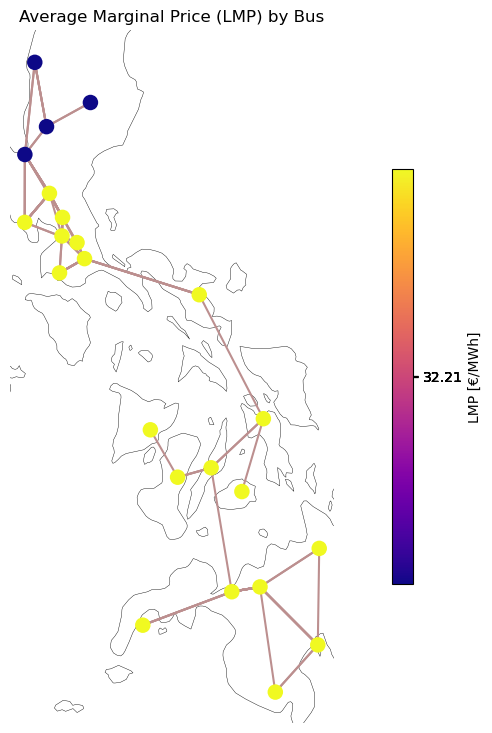

In [97]:
def plot_lmp(network, bus_carrier_filter=None, print_values=False):
    fig = plt.figure(figsize=(15, 9))
    ax = plt.axes(projection=ccrs.Mercator())

    # Calculate mean marginal price for each bus over all snapshots
    bus_lmp = network.buses_t.marginal_price.mean()

    # Optionally filter buses by carrier
    if bus_carrier_filter is not None:
        buses_to_plot = network.buses.index[network.buses.carrier.isin(bus_carrier_filter)]
        bus_lmp = bus_lmp.loc[buses_to_plot]

    if print_values:
        print("Bus LMP values:")
        print(bus_lmp)

    if bus_lmp.empty:
        print("No buses to plot after filtering. Please check the bus_carrier_filter or the network data.")
        return

    # Normalize color scale to the data range
    norm = plt.Normalize(vmin=bus_lmp.min(), vmax=bus_lmp.max())

    m=network.copy()
    m.buses= m.buses.loc[bus_lmp.index]  # Filter buses in the network to match bus_lmp

    m.plot(
        ax=ax,
        bus_colors=bus_lmp,
        bus_cmap="plasma",
        bus_norm=norm,
    )

    # Create the colorbar with correct normalization and boundaries
    sm = mpl.cm.ScalarMappable(cmap="plasma", norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label="LMP [€/MWh]", shrink=0.6)
    ticks = np.linspace(bus_lmp.min(), bus_lmp.max(), num=6)
    cbar.set_ticks(ticks)
    # Set the min and max as the limits of the tick labels
    cbar.set_ticklabels([f"{v:.2f}" for v in ticks])
    plt.title("Average Marginal Price (LMP) by Bus")
    plt.show()


plot_lmp(n, bus_carrier_filter=["AC"], print_values=False) #bus_carrier_filter=["AC", "Hydrogen"] 

/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/ipykernel_15946/3002366324.py:5: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



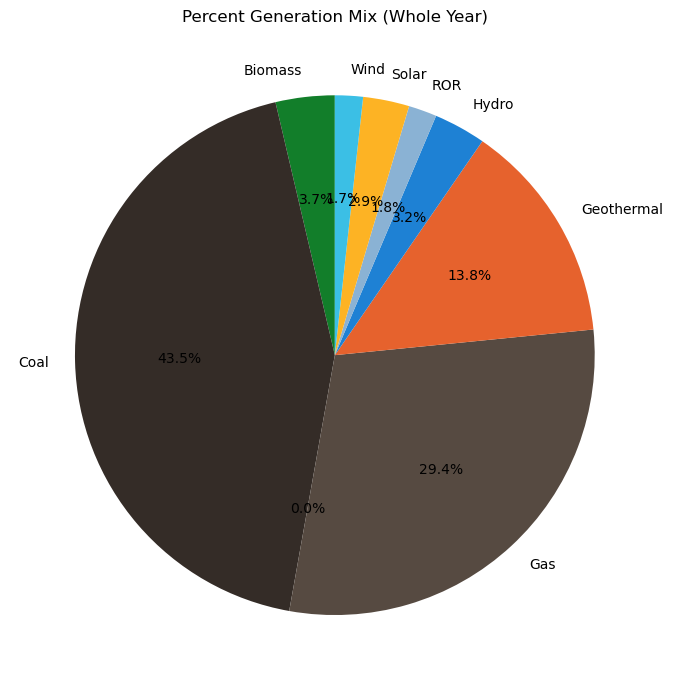

In [98]:
def plot_generation_mix_pie(network):
    """
    Plot the percent generation mix for the whole year by carrier as a pie chart.
    """
    gen_mix = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum().sum()
    gen_mix_percent = gen_mix / gen_mix.sum() * 100

    plt.figure(figsize=(7, 7))
    colors = [
        network.carriers.loc[carrier, 'color']
        if carrier in network.carriers.index and 'color' in network.carriers.columns else None
        for carrier in gen_mix_percent.index
    ]
    gen_mix_percent.plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)
    plt.ylabel('')
    plt.title('Percent Generation Mix (Whole Year)')
    plt.tight_layout()
    plt.show()

plot_generation_mix_pie(n)

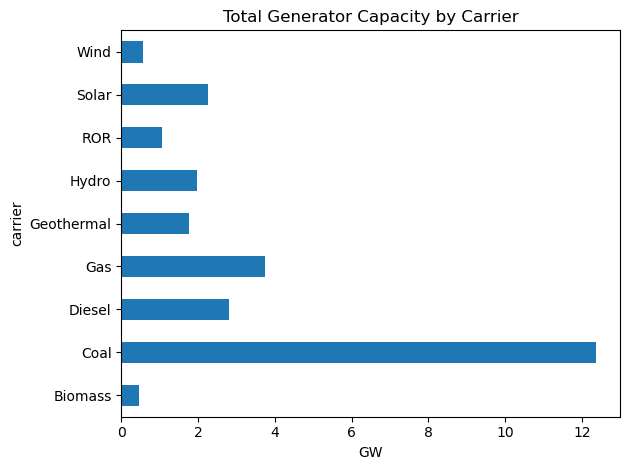

In [99]:
def plot_generator_capacity_by_carrier(network):
    """
    Plot total generator capacity by carrier for a given PyPSA network.
    """
    network.generators.groupby("carrier").p_nom_opt.sum().div(1e3).plot.barh()
    plt.xlabel("GW")
    plt.title("Total Generator Capacity by Carrier")
    plt.tight_layout()
    plt.show()

plot_generator_capacity_by_carrier(n)

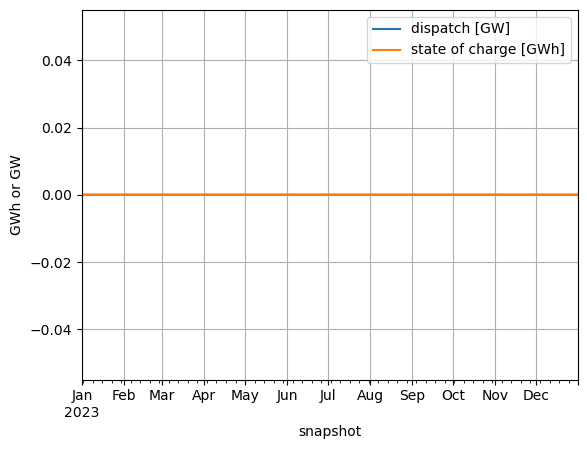

In [100]:
def plot_storage_dispatch(network, include_stores=True, carrier=None):
    """
    Plot storage dispatch and state of charge for a selected storage carrier.
    If carrier is None, plot the sum across all storage units (and stores if include_stores=True).
    """
    fig, ax = plt.subplots()

    # StorageUnits
    if carrier is not None:
        mask_su = network.storage_units.carrier == carrier
        storage_names = network.storage_units.index[mask_su]
        p_storage = network.storage_units_t.p[storage_names].sum(axis=1).div(1e3)
        if hasattr(network.storage_units_t, "state_of_charge"):
            state_of_charge = network.storage_units_t.state_of_charge[storage_names].sum(axis=1).div(1e3)
        else:
            state_of_charge = None
        label_prefix = f"{carrier} "
    else:
        p_storage = network.storage_units_t.p.sum(axis=1).div(1e3)
        if hasattr(network.storage_units_t, "state_of_charge"):
            state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1).div(1e3)
        else:
            state_of_charge = None
        label_prefix = ""

    # Stores (optional)
    if include_stores and not network.stores.empty:
        if carrier is not None:
            mask_store = network.stores.carrier == carrier
            store_names = network.stores.index[mask_store]
            p_store = network.stores_t.p[store_names].sum(axis=1).div(1e3)
            if hasattr(network.stores_t, "e"):
                soc_store = network.stores_t.e[store_names].sum(axis=1).div(1e3)
            else:
                soc_store = None
        else:
            p_store = network.stores_t.p.sum(axis=1).div(1e3)
            if hasattr(network.stores_t, "e"):
                soc_store = network.stores_t.e.sum(axis=1).div(1e3)
            else:
                soc_store = None

        # Add store data to storage data
        p_storage = p_storage.add(p_store, fill_value=0)
        if state_of_charge is not None and soc_store is not None:
            state_of_charge = state_of_charge.add(soc_store, fill_value=0)
        elif soc_store is not None:
            state_of_charge = soc_store

    p_storage.plot(label=f"{label_prefix}dispatch [GW]", ax=ax)
    if state_of_charge is not None:
        state_of_charge.plot(label=f"{label_prefix}state of charge [GWh]", ax=ax)

    ax.grid()
    ax.legend()
    ax.set_ylabel("GWh or GW")
    plt.show()

# Example usage:
plot_storage_dispatch(n)

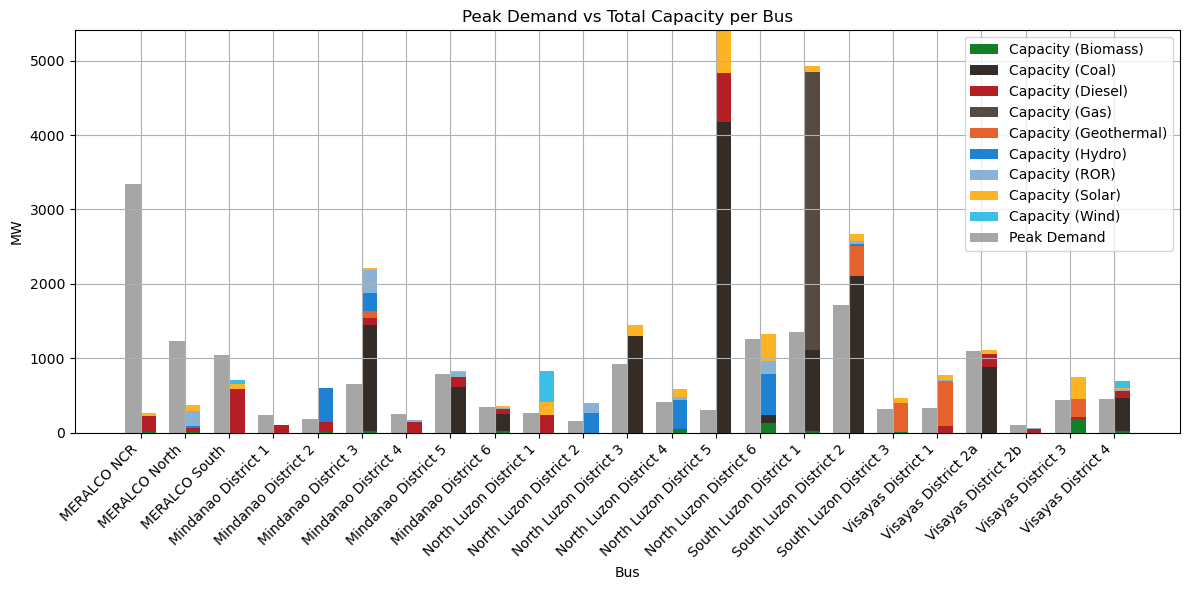

In [101]:
def plot_peak_demand_vs_capacity(network, stack_carrier=False):
    # Calculate the maximum hourly demand per bus
    max_demand_per_bus = network.loads_t.p_set.max()
    max_demand_per_bus.name = "Max Demand"

    # Calculate the total available capacity per bus and carrier
    capacity_by_bus_carrier = network.generators.groupby(['bus', 'carrier']).p_nom_opt.sum().unstack(fill_value=0)
    total_capacity_per_bus = capacity_by_bus_carrier.sum(axis=1)
    total_capacity_per_bus.name = "Total Capacity"

    # Combine the data into a DataFrame and keep only buses with demand or capacity
    capacity_vs_demand = pd.concat([max_demand_per_bus, total_capacity_per_bus], axis=1).fillna(0)
    capacity_vs_demand = capacity_vs_demand.loc[(capacity_vs_demand["Max Demand"] > 0) | (capacity_vs_demand["Total Capacity"] > 0)]

    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    bar_positions = np.arange(len(capacity_vs_demand))

    if stack_carrier:
        # Plot stacked capacity by carrier
        carriers = [c for c in capacity_by_bus_carrier.columns if c in network.carriers.index]
        bottom = np.zeros(len(capacity_vs_demand))
        for carrier in carriers:
            values = capacity_by_bus_carrier.reindex(capacity_vs_demand.index).get(carrier, 0)
            color = network.carriers.loc[carrier, 'color'] if 'color' in network.carriers.columns else None
            ax.bar(bar_positions + bar_width/2, values, bar_width, label=f'Capacity ({carrier})', bottom=bottom, color=color)
            bottom += values.values

        # Plot demand as a single bar
        ax.bar(bar_positions - bar_width/2, capacity_vs_demand["Max Demand"], bar_width, label='Peak Demand', color='gray', alpha=0.7)
    else:
        # Plot total demand as a single bar
        ax.bar(bar_positions - bar_width/2, capacity_vs_demand["Max Demand"], bar_width, label='Peak Demand', color='gray', alpha=0.7)
        # Plot total capacity as a single bar
        ax.bar(bar_positions + bar_width/2, capacity_vs_demand["Total Capacity"], bar_width, label='Total Capacity', color='tab:blue')

    ax.set_xlabel('Bus')
    ax.set_ylabel('MW')
    ax.set_title('Peak Demand vs Total Capacity per Bus')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(capacity_vs_demand.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

plot_peak_demand_vs_capacity(n, stack_carrier=True)


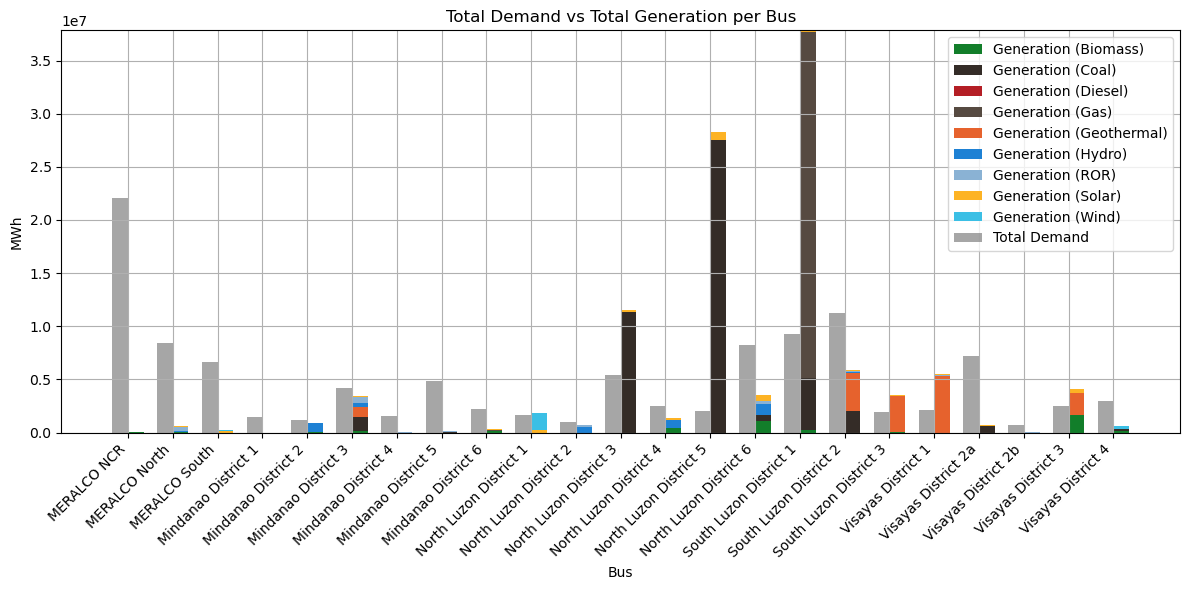

In [102]:
def plot_total_demand_vs_generation(network, temp_reso=1, stack_carrier=False):
    # Calculate the total demand per bus
    total_demand_per_bus = network.loads_t.p_set.sum()*temp_reso
    total_demand_per_bus.name = "Total Demand"

    # Calculate the total available capacity per bus and carrier
    generation_by_bus_carrier = network.generators[['bus', 'carrier']].assign(total_generation=network.generators_t.p.sum()).groupby(['bus', 'carrier'])['total_generation'].sum().unstack(fill_value=0)*temp_reso
    total_generation_per_bus = generation_by_bus_carrier.sum(axis=1)
    total_generation_per_bus.name = "Total Generation"

    # Combine the data into a DataFrame and keep only buses with demand or capacity
    generation_vs_demand = pd.concat([total_demand_per_bus, total_generation_per_bus], axis=1).fillna(0)
    generation_vs_demand = generation_vs_demand.loc[(generation_vs_demand["Total Demand"] > 0) | (generation_vs_demand["Total Generation"] > 0)]

    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    bar_positions = np.arange(len(generation_vs_demand))

    if stack_carrier:
        # Plot stacked generation by carrier
        carriers = [c for c in generation_by_bus_carrier.columns if c in network.carriers.index]
        bottom = np.zeros(len(generation_vs_demand))
        for carrier in carriers:
            values = generation_by_bus_carrier.reindex(generation_vs_demand.index).get(carrier, 0)
            color = network.carriers.loc[carrier, 'color'] if 'color' in network.carriers.columns else None
            ax.bar(bar_positions + bar_width/2, values, bar_width, label=f'Generation ({carrier})', bottom=bottom, color=color)
            bottom += values.values

        # Plot demand as a single bar
        ax.bar(bar_positions - bar_width/2, generation_vs_demand["Total Demand"], bar_width, label='Total Demand', color='gray', alpha=0.7)
    else:
        # Plot total demand as a single bar
        ax.bar(bar_positions - bar_width/2, generation_vs_demand["Total Demand"], bar_width, label='Total Demand', color='gray', alpha=0.7)
        # Plot total capacity as a single bar
        ax.bar(bar_positions + bar_width/2, generation_vs_demand["Total Generation"], bar_width, label='Total Generation', color='tab:blue')

    ax.set_xlabel('Bus')
    ax.set_ylabel('MWh')
    ax.set_title('Total Demand vs Total Generation per Bus')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(generation_vs_demand.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

plot_total_demand_vs_generation(n, temp_reso=3, stack_carrier=True)


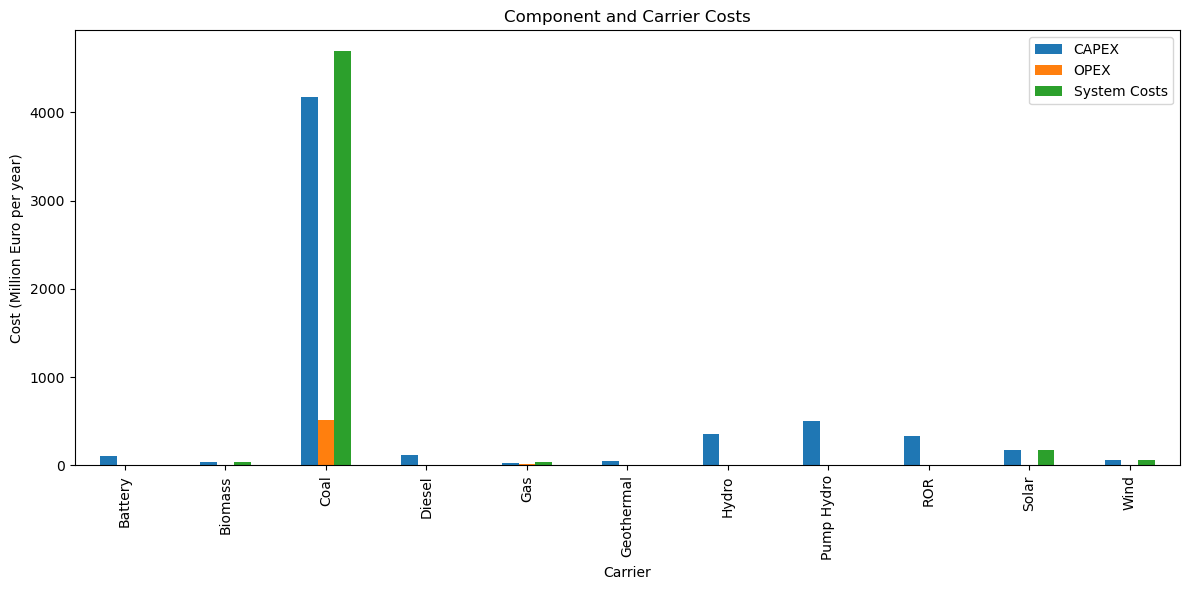

Total System Cost: 6475.54 Million Euro per Year


In [103]:
def combined_cost_plot(network, stacked=False):
    def system_cost(n):
        tsc = n.statistics.capex() + n.statistics.opex()
        return tsc.groupby(level=1).sum().div(1e6)  # million €/a

    def capex_data(n):
        return n.statistics.capex().groupby(level=1).sum().div(1e6)  # million €/a

    def opex_data(n):
        return n.statistics.opex().groupby(level=1).sum().div(1e6)  # million €/a

    capex = capex_data(network)
    opex = opex_data(network)
    system_costs = system_cost(network)

    all_carriers = capex.index.union(opex.index).union(system_costs.index)
    capex = capex.reindex(all_carriers).fillna(0)
    opex = opex.reindex(all_carriers).fillna(0)
    system_costs = system_costs.reindex(all_carriers).fillna(0)

    combined_df = pd.DataFrame({
        'CAPEX': capex,
        'OPEX': opex,
        'System Costs': system_costs
    })

    fig, ax = plt.subplots(figsize=(12, 6))
    if stacked:
        combined_df[['CAPEX', 'OPEX']].plot(kind='bar', stacked=True, ax=ax)
        ax.plot(combined_df.index, combined_df['System Costs'], color='black', marker='o', label='System Costs')
    else:
        combined_df.plot(kind='bar', ax=ax)

    ax.set_title('Component and Carrier Costs')
    ax.set_ylabel('Cost (Million Euro per year)')
    ax.set_xlabel('Carrier')
    plt.tight_layout()
    plt.legend()
    plt.show()

    total_capex = capex.sum()
    total_opex = opex.sum()
    total_costs = total_capex + total_opex
    print(f"Total System Cost: {total_costs:.2f} Million Euro per Year")

combined_cost_plot(n, stacked=False)

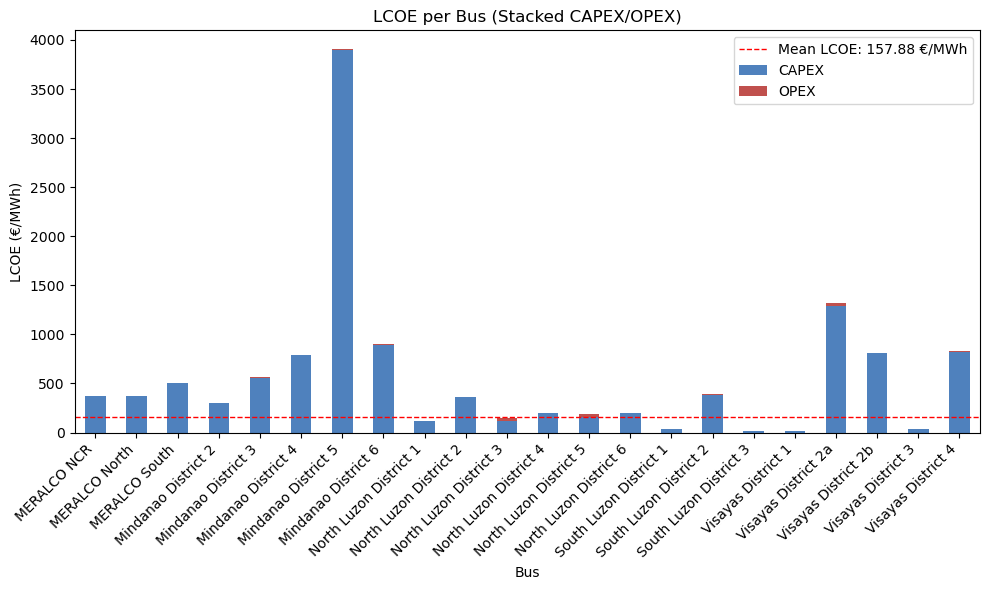

In [104]:
def plot_lcoe_by_bus(network, show_components=False):
    # Calculate annual energy production per generator (MWh)
    annual_energy_production = network.generators_t.p.sum(axis=0)
    # Aggregate annual energy production by bus
    annual_energy_production_by_bus = annual_energy_production.groupby(network.generators.bus).sum()
    # Prepare DataFrames for CAPEX and OPEX per bus
    buses = network.buses.index
    capex_by_bus = pd.Series(0.0, index=buses)
    opex_by_bus = pd.Series(0.0, index=buses)
    total_costs_by_bus = pd.Series(0.0, index=buses)
    for bus in buses:
        generators_at_bus = network.generators[network.generators.bus == bus]
        for gen in generators_at_bus.index:
            capex = network.generators[network.generators.bus == bus].at[gen, 'capital_cost']
            opex = network.generators[network.generators.bus == bus].at[gen, 'marginal_cost']
            p_nom_opt = network.generators.at[gen, 'p_nom_opt']
            capex_by_bus[bus] += capex * p_nom_opt
            opex_by_bus[bus] += opex * annual_energy_production[gen]
            total_costs_by_bus[bus] += capex * p_nom_opt + opex * annual_energy_production[gen]
    # Calculate LCOE per bus, exclude buses with zero annual energy production
    LCOE_by_bus = total_costs_by_bus / annual_energy_production_by_bus
    LCOE_by_bus = LCOE_by_bus.replace([float('inf'), -float('inf')], pd.NA).dropna()
    mean_LCOE = (LCOE_by_bus * annual_energy_production_by_bus.reindex(LCOE_by_bus.index)).sum() / annual_energy_production_by_bus.reindex(LCOE_by_bus.index).sum()
    if show_components:
        # Compute component LCOEs
        capex_lcoe = capex_by_bus / annual_energy_production_by_bus
        opex_lcoe = opex_by_bus / annual_energy_production_by_bus
        capex_lcoe = capex_lcoe.reindex(LCOE_by_bus.index)
        opex_lcoe = opex_lcoe.reindex(LCOE_by_bus.index)
        df = pd.DataFrame({'CAPEX': capex_lcoe, 'OPEX': opex_lcoe})
        ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#4F81BD', '#C0504D'])
        ax.set_ylabel('LCOE (€/MWh)')
        ax.set_title('LCOE per Bus (Stacked CAPEX/OPEX)')
        ax.axhline(mean_LCOE, color='red', linestyle='--', linewidth=1, label=f'Mean LCOE: {mean_LCOE:.2f} €/MWh')
        ax.set_xticklabels(df.index, rotation=45, ha='right')
        ax.legend()
        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = LCOE_by_bus.plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title('LCOE per Bus')
        ax.set_xlabel('Bus')
        ax.set_ylabel('LCOE (€/MWh)')
        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', color='black', rotation=90)
        ax.axhline(mean_LCOE, color='red', linestyle='--', linewidth=1, label=f'Mean LCOE: {mean_LCOE:.2f} €/MWh')
        ax.set_xticklabels(LCOE_by_bus.index, rotation=45, ha='right')
        ax.legend()
        plt.tight_layout()
        plt.show()

plot_lcoe_by_bus(n, show_components=True)

### 06 Future Case Scenario Simulations with Projected Demand Growth, CO2 Reduction and Hydrogen Sector Coupling

This section explores future scenarios for the Philippine power system by projecting demand, technology costs, and system configurations to future years. It includes functions for scenario analysis, demand forecasting, and the evaluation of key metrics such as LCOE, emissions, and generation mix under different policy and technology pathways. The workflow enables comparison of baseline and future cases to inform planning and decision-making.

**IMPORTANT NOTES BEFORE RUNNING THIS SECTION:** 

1. Currently, this section only works when the `AGGREGATE_BUSES = 'custom_TDP2'` since the future projection data for the demand were only available for NGCP Transmission Districts. 

2. Since each scenario requires too much memory space, it is advice to run them individually and store them as `{scenario name}.nc` file first. To analyses scenario results, import the PyPSA network, then use the visualization tools available here.

#### 06.01 Code Functions for Projection to Future Scenarios

This section provides the core Python functions used to project the PyPSA-PH network into future scenarios. These functions enable the simulation of demand growth, technology evolution, CO₂ reduction targets, and sector coupling (e.g., hydrogen integration). Each function is documented below with its purpose, inputs, and outputs.

---

**Function Definitions:**

- **restart_network(n):**  
    *Purpose:* Resets a PyPSA network object by removing all buses and associated components, preparing it for reconstruction.  
    *Inputs:*  
        - `n`: PyPSA Network object to be cleared.  
    *Outputs:*  
        - None (modifies the network in place).

- **project_network(n, y, co2_red=0, add_gen_tech, add_store_tech, H2_SU, H2_S, H2_p_set, load_growth_factor):**  
    *Purpose:* Projects the given network to a future year, optionally adding new technologies, enforcing CO₂ constraints, and integrating hydrogen sector coupling.  
    *Inputs:*  
        - `n`: Base PyPSA Network object.  
        - `y`: Target year for cost reference and demand projection (int).  
        - `co2_red`: Fractional CO₂ reduction target (float, 0–1).  
        - `add_gen_tech`: List of generator technologies to add (list of str).  
        - `add_store_tech`: List of storage technologies to add (list of str).  
        - `H2_SU`: Enable hydrogen sector coupling (bool).  
        - `H2_S`: Add synthetic hydrogen demand (bool).  
        - `H2_p_set`: Value for hydrogen demand per bus (float).  
        - `load_growth_factor`: Optional custom load growth factor (Series or None).  
    *Outputs:*  
        - `n_new`: Projected PyPSA Network object for the future scenario.

- **solup_net(n):**  
    *Purpose:* Optimizes the network and removes components with zero optimal capacity, returning network statistics.  
    *Inputs:*  
        - `n`: PyPSA Network object to optimize.  
    *Outputs:*  
        - Network statistics (DataFrame).

- **total_generation(n):**  
    *Purpose:* Calculates the average annual generation per carrier in GW.  
    *Inputs:*  
        - `n`: PyPSA Network object.  
    *Outputs:*  
        - DataFrame with columns: `Carrier`, `Generation_GW`.

- **total_emissions(n):**  
    *Purpose:* Computes total CO₂ emissions per carrier in Mt CO₂.  
    *Inputs:*  
        - `n`: PyPSA Network object.  
    *Outputs:*  
        - DataFrame with columns: `Carrier`, `Emission_tCO2/MWh_th`.

- **calc_LCOE(n):**  
    *Purpose:* Calculates the Levelized Cost of Electricity (LCOE) for the network.  
    *Inputs:*  
        - `n`: PyPSA Network object.  
    *Outputs:*  
        - List: `[total_capex, total_opex, total_electricity, LCOE, LCOE_PHP_MWh]`.


These functions form the basis for scenario analysis, enabling systematic exploration of future Philippine power system pathways.

In [105]:
def restart_network(n):
    # Remove all buses, which will automatically remove connected components like generators, lines, etc.
    n.mremove("Bus", n.buses.index)
    
    # Remove all generators
    n.mremove("Generator", n.generators.index)
    
    # Remove all loads
    n.mremove("Load", n.loads.index)
    
    # Remove all lines
    n.mremove("Line", n.lines.index)

    # Remove all links
    n.mremove("Link", n.links.index)
    
    # Remove all storage units
    n.mremove("StorageUnit", n.storage_units.index)

    # Remove all stores
    n.mremove("Store", n.stores.index)
    
    # Remove all other components (optional)
    n.mremove("GlobalConstraint", n.global_constraints.index)
    n.mremove("Carrier", n.carriers.index)
    n.mremove("SubNetwork", n.sub_networks.index)

In [ ]:
def project_network(n, y, re_percent=None , co2_red=None, add_gen_tech=["Solar", "Wind", "Coal"], add_store_tech=["Battery"],  H2_SU=False, H2_S=False, H2_p_set=0, load_growth_factor=None):
    n_new = pypsa.Network()

    # Restart n_new
    restart_network(n_new)

    # Add snapshots
    n_new.set_snapshots(n.snapshots.copy())

    # Copy buses
    bus_data = n.buses[['x', 'y', 'v_nom', 'carrier']].copy()
    for bus in bus_data.index:
        n_new.add("Bus", bus, x=bus_data.at[bus, 'x'], y=bus_data.at[bus, 'y'], v_nom=bus_data.at[bus, 'v_nom'], carrier=bus_data.at[bus, 'carrier'])

    # Copy and update loads and loads_t, else apply load growth factor
    present_load = n.loads_t['p_set'].mean(axis=0).copy()
    if load_growth_factor is not None:
        load_growth = present_load*load_growth_factor
    else:
        load_growth = present_load if y <= 2020 else future_loads.loc[present_load.index, str(y)]/present_load 
        
    for i in load_growth.index:
        load_growth[i] = load_growth[i] if load_growth[i] >= 1 else 1

    for bus in present_load.index:
        n_new.add("Load", bus, bus=bus)
        n_new.loads_t.p_set.loc[:, bus] = n.loads_t.p_set.loc[:, bus].copy()*load_growth[bus]

    # Copy generators and generators_t
    for i, gen in n.generators.iterrows():
        if gen['lifetime'] > y:
            n_new.add("Generator", i, bus=gen['bus'], p_nom=gen['p_nom_opt'], 
                      carrier=gen['carrier'], efficiency=gen['efficiency'],
                      capital_cost=gen['capital_cost'], marginal_cost=gen['marginal_cost'], 
                      lifetime=gen['lifetime'], p_nom_extendable=False)
    n_new.generators_t.p_max_pu = n.generators_t.p_max_pu.loc[:, n_new.generators.index].copy()

    # Copy storage units
    for i, su in n.storage_units.iterrows():
        if su['lifetime'] > y:
            n_new.add("StorageUnit", i, bus=su['bus'], p_nom=su['p_nom_opt'], carrier=su['carrier'], max_hours=su['max_hours'], efficiency_store=su['efficiency_store'], efficiency_dispatch=su['efficiency_dispatch'],capital_cost=su['capital_cost'], marginal_cost=su['marginal_cost'], lifetime=su['lifetime'], p_nom_extendable=False)

    # Copy stores
    for i, s in n.stores.iterrows():
        if s['lifetime'] > y:
            n_new.add("Store", i, bus=s['bus'], e_nom=s['e_nom_opt'], carrier=s['carrier'], capital_cost=s['capital_cost'], marginal_cost=s['marginal_cost'], lifetime=s['lifetime'], e_nom_extendable=False)

    # Copy carriers
    carrier_data = n.carriers[['co2_emissions', 'color']].copy()
    for carrier in carrier_data.index:
        n_new.add("Carrier", carrier, co2_emissions=carrier_data.at[carrier, 'co2_emissions'], color=carrier_data.at[carrier, 'color'])

    # Copy lines
    for i, line in n.lines.iterrows():
        n_new.add("Line", i, bus0=line['bus0'], bus1=line['bus1'], x=line['x'], r=line['r'], s_nom=line['s_nom_opt'], s_nom_extendable=True)

    # Copy links
    for i, link in n.links.iterrows():
        if link['lifetime'] > y:
            n_new.add("Link", i, bus0=link['bus0'], bus1=link['bus1'], carrier=link['carrier'], efficiency=link['efficiency'] , marginal_cost=link['marginal_cost'] , capital_cost=link['capital_cost'] ,p_nom=link['p_nom_opt'], p_nom_extendable=False)

    # Add new capacities (e.g., generators, storage units)
    costs_data = get_costs_data(y)
    tech_map = {"Gas": "gas boiler steam", "Solar": "solar", "Wind": "onwind", "Diesel": "oil", "Coal": "coal", "Hydro": "hydro", "Geothermal": "geothermal", "Biomass": "solid biomass boiler steam", "ROR": "ror", "Battery": "battery storage", "Pump Hydro": "Pumped-Storage-Hydro-store"}

    # Update cost data of existing generators
    for carrier in n_new.generators.carrier.unique():
        tech = tech_map.get(carrier)
        # n_new.generators.loc[n_new.generators['carrier'] == carrier, 'efficiency'] = costs_data.at[tech, "efficiency"]
        n_new.generators.loc[n_new.generators['carrier'] == carrier, 'marginal_cost'] = costs_data.at[tech, "marginal_cost"]
        # n_new.generators.loc[n_new.generators['carrier'] == carrier, 'capital_cost'] = costs_data.at[tech, "capital cost"]
    
    # Update cost data of storage units
    for carrier in n_new.storage_units.carrier.unique():
        tech = tech_map.get(carrier)
        #n_new.storage_units.loc[n_new.storage_units['carrier'] == carrier, 'efficiency_dispatch'] = costs_data.at[tech, "efficiency"]
        #n_new.storage_units.loc[n_new.storage_units['carrier'] == carrier, 'efficiency_store'] = costs_data.at[tech, "efficiency"]
        n_new.storage_units.loc[n_new.storage_units['carrier'] == carrier, 'marginal_cost'] = costs_data.at[tech, "marginal_cost"]
        #n_new.storage_units.loc[n_new.storage_units['carrier'] == carrier, 'capital_cost'] = costs_data.at[tech, "capital_cost"]
    
    if H2_SU == True:
        if "Hydrogen" not in n_new.carriers.index:
            n_new.add("Carrier", "Hydrogen", co2_emissions=0, color="#b01787")

    if H2_S == True:
        #Building main H2 bus for national H2 demand
        if "main_H2" not in n_new.buses.index:
            n_new.add("Bus", "main_H2",
                        x=n.buses.x.mean(),
                        y=n.buses.y.mean(),
                        carrier="Hydrogen")  
            #Add national H2 demand on main_H2 bus
            n_new.add("Load", f"main_H2_load", bus="main_H2", carrier="Hydrogen", p_set=H2_p_set)  # in MW_H2, could be assumed 258MW at the moment to supply off-grid MW_diesel demand divided among all H2 buses
        else:
            n_new.loads.loc["main_H2_load", "p_set"] = H2_p_set


    for bus in n_new.buses.index[n_new.buses['carrier'].isin(["AC"])]:

        #Addition of Storage Units
        for carrier in add_store_tech: # ["Battery", "Pump Hydro"]
            tech = tech_map[carrier]
            n_new.add("StorageUnit", 
                      f"{bus}_{carrier}_{y}", 
                      bus=bus, 
                      carrier=carrier, 
                      max_hours= 4 if carrier=="Battery" else 6, 
                      efficiency_dispatch=0.95 if carrier=="Battery" else 1, 
                      efficiency_store=0.95 if carrier=="Battery" else 1, 
                      capital_cost=costs_data.at[tech, "capital_cost"], 
                      marginal_cost=costs_data.at[tech, "marginal_cost"], 
                      lifetime=y + costs_data.at[tech, "lifetime"], 
                      p_nom_extendable=True)
                #Addition of Generators
        for carrier in add_gen_tech: # ["Solar", "Wind", "Coal", "Gas", "Diesel", "Hydro", "ROR", "Biomass", "Geothermal"]
            tech = tech_map[carrier]
            n_new.add("Generator", 
                      f"{bus}_{carrier}_{y}", 
                      bus=bus, carrier=carrier, 
                      efficiency=costs_data.at[tech, "efficiency"], 
                      marginal_cost=costs_data.at[tech, "marginal_cost"], 
                      capital_cost=costs_data.at[tech, "capital_cost"], 
                      lifetime=y + costs_data.at[tech, "lifetime"], 
                      p_nom_extendable=True)
            if carrier in ["Solar", "Wind"]:
                n_new.generators_t.p_max_pu[f"{bus}_{carrier}_{y}"] = district_RE[f"{bus}_{carrier}"]
            else:
                n_new.generators_t.p_max_pu[f"{bus}_{carrier}_{y}"] = np.ones(len(n.generators_t.p_max_pu))

        #Addition of Hydrogen Assemblies: H2_SU allows building H2 assemblies to support grid, H2_S allows building H2 assemblies to supply H2 gas demand of the country
        if H2_SU or H2_S == True:
            if f"{bus}_H2" not in n_new.buses.index:
                #Hydrogen bus
                n_new.add("Bus", f"{bus}_H2", 
                          x=n.buses.at[bus, 'x'], 
                          y=n.buses.at[bus, 'y'],
                          carrier="Hydrogen") 
                #Electrolyzer Link
                n_new.add(
                    "Link",
                    f"{bus}_H2_electrolysis",
                    bus0=bus,
                    bus1=f"{bus}_H2",
                    carrier="Hydrogen",
                    p_nom_extendable=True,
                    efficiency=costs_data.at["electrolysis", "efficiency"],
                    capital_cost=costs_data.at["electrolysis", "capital_cost"],
                    marginal_cost=costs_data.at["electrolysis", "marginal_cost"],
                    lifetime=y + costs_data.at["electrolysis", "lifetime"]) 
                #Hydrogen Store Tank
                n_new.add(
                    "Store",
                    f"{bus}_H2_storage",
                    bus=f"{bus}_H2",
                    carrier="Hydrogen",
                    capital_cost=costs_data.at["hydrogen storage tank type 1 including compressor", "capital_cost"], 
                    marginal_cost=costs_data.at["hydrogen storage tank type 1 including compressor", "marginal_cost"],
                    lifetime=y + costs_data.at["hydrogen storage tank type 1 including compressor", "lifetime"],
                    e_nom_extendable=True,
                    e_cyclic=True)  
                #Fuel Cell Link, only activates if H2_SU is True, allowing H2 to be converted back to electricity
                if H2_SU == True:
                    n_new.add(
                        "Link",
                        f"{bus}_H2_fuel cell",
                        bus0=f"{bus}_H2",
                        bus1=bus,
                        carrier="Hydrogen",
                        p_nom_extendable=True,
                        efficiency=costs_data.at["fuel cell", "efficiency"],
                        capital_cost=costs_data.at["fuel cell", "capital_cost"],
                        marginal_cost=costs_data.at["fuel cell", "marginal_cost"],
                        lifetime=y + costs_data.at["fuel cell", "lifetime"]) 
                #H2 Transport link from one H2 to main_H2 bus 
                if H2_S == True:
                    n_new.add("Link", f"{bus}_H2_transport",
                            bus0=f"{bus}_H2",
                            bus1="main_H2",
                            carrier="Hydrogen",
                            p_nom_extendable=True,
                            efficiency=1.0,  # Assuming no loses during transport
                            capital_cost=0,#costs_data.at["H2 (l) transport ship", "capital_cost"],
                            marginal_cost=0, #costs_data.at["H2 (l) transport ship", "marginal_cost"],
                            lifetime=y + costs_data.at["H2 (l) transport ship", "lifetime"])

    # Add global constraint on CO2 emission
    if co2_red is not None:   
        reference_emissions = (n.generators_t['p'] / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions)).sum().sum()
        n_new.add("GlobalConstraint", "CO2Limit", carrier_attribute="co2_emissions", sense="<=", constant=reference_emissions * (1 - co2_red)) #type='primary energy'  Add

    # Add global constraint on minimum renewable energy share
    if re_percent is not None:
        # Identify renewable carriers
        renewable_carriers = ["Solar", "Wind", "Hydro", "ROR", "Biomass", "Geothermal"]
        # Map to carrier names in the network
        renewable_gens = n_new.generators.index[n_new.generators['carrier'].isin(renewable_carriers)]
        # Create an expression for total renewable generation
        re_expr = (n_new.generators_t['p_max_pu'][renewable_gens].multiply(n_new.generators.loc[renewable_gens, 'p_nom'], axis=1)).sum(axis=1).sum()
        # Create an expression for total generation
        total_expr = (n_new.generators_t['p_max_pu'].multiply(n_new.generators['p_nom'], axis=1)).sum(axis=1).sum()
        
        # Add global constraint for minimum RE share
        n_new.add("GlobalConstraint", "MaxREShare", sense=">=", constant=re_percent, 
                  type="primary_energy", 
                  expression=(re_expr / total_expr))

        # If brute force will be done to the previous scenario to ensure that it is the non-RE dispatchable generators who are being lessened in total generation share instead of RE which could have less ( note p <= p_nom_pu*p_nom)
        # n_new.add("GlobalConstraint", "MaxNonREShare", sense="<=", constant=re_percent, 
        #     type="primary_energy", 
        #     expression=((total_expr-re_expr) / total_expr))

        # Maximum brute force to obtain the exact RE_percent goal [It doesn't work with a sense of "==" and I think assumes maximum value immediately]
        # n_new.add("GlobalConstraint", "REShare", sense="==", constant=re_percent, 
        #           type="primary_energy", 
        #           expression=(re_expr / total_expr))


    return n_new

In [107]:
def solup_net(n):
# Optimize the network
    n.optimize(solver_name='gurobi')
    
    # Remove generators with zero p_nom_opt
    # Also remove generators_t with p_nom_opt zero
    n.generators = n.generators[n.generators['p_nom_opt'] != 0].copy()
    
    # Remove storage units with zero p_nom_opt
    n.storage_units = n.storage_units[n.storage_units['p_nom_opt'] != 0].copy()

    # Remove stores and hydrogen assemblies with stores of zero e_nom_opt
    storeremove = n.stores[n.stores['e_nom_opt'] == 0].copy()
    n.buses = n.buses[~n.buses.index.isin(storeremove['bus'])].copy()
    n.links = n.links[~n.links.bus0.isin(storeremove['bus'])].copy()
    n.links = n.links[~n.links.bus1.isin(storeremove['bus'])].copy()
    n.links = n.links[n.links['p_nom_opt'] != 0].copy()
    n.stores = n.stores[n.stores['e_nom_opt'] != 0].copy()
    
    return n.statistics()

In [108]:
def total_generation(n):
    generation = n.generators_t.p.T.groupby(n.generators.carrier).sum().mean(axis=1).div(1e3) # in GWh_ave
    generation_df = generation.reset_index()
    generation_df.columns = ['Carrier', 'Generation_GWh']
    return generation_df

In [109]:
def total_emissions(n):
    # Calculate total CO2 emissions per carrier
    emissions = ((n.generators_t.p/n.generators.efficiency) * n.generators['carrier'].map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().div(1e6).sum(axis=1)  # in Mt CO₂
    emissions_df = emissions.reset_index()
    emissions_df.columns = ['Carrier', 'Emission_tCO2/MWh_th']
    return emissions_df

In [110]:
def calc_LCOE(n, exchange_rate=None, calc_LFSCOE=False):
    if calc_LFSCOE:
        components = ["Generator", "StorageUnit", "Store", "Line", "Link"]
    else:
        components = ["Generator"]
    total_capex = n.statistics.capex(components).sum()
    total_opex = n.statistics.opex(components).sum()
    total_electricity = n.statistics.supply(["Generator"]).sum()
    LCOE = (total_capex + total_opex)/total_electricity
    LCOEdat=[total_capex, total_opex, total_electricity, LCOE, LCOE*exchange_rate if exchange_rate is not None else None]
    return LCOEdat

#### 06.02 Definition of Functions for Future Simulations

This section defines and documents the functions and scenario setups used for projecting the Philippine power system into the future. Five distinct future scenarios are explored to assess the impacts of demand growth, CO₂ reduction targets, and hydrogen sector coupling. These scenarios are constructed using the `project_network` function, which allows flexible configuration of technology additions, CO₂ constraints, and hydrogen integration. The results from these scenarios provide insights into the role of hydrogen, storage, and sector coupling in achieving deep decarbonization of the Philippine power system.

**NOTE:** Since each scenario requires too much memory space, it is advice to run them individually and store them as `{scenario name}.nc` file first. To analyses scenario results, import the desired future case PyPSA network on the next section, then use the visualization tools available there.

1. **nf_h**:  
    *Full Hydrogen Sector Coupling*  
    Projects the network to 2040 with 100% CO₂ reduction and enables hydrogen sector coupling (H₂ assemblies added at all buses). This scenario evaluates the system when hydrogen is integrated for flexibility and sector coupling, but without explicit hydrogen demand.

In [111]:
raise RuntimeError("Stopping execution here. Kindly read the instructions above on running this section of the code.")

RuntimeError: Stopping execution here. Kindly read the instructions above on running this section of the code.

In [ ]:
nf_h = project_network(n, y=2040, co2_red=1.0, H2_SU=True)
solup_net(nf_h)
nf_h.export_to_netcdf("results/PyPSA-PH_2040_H2.nc")

2. **nf_hs**:  
    *Hydrogen Sector Coupling with Synthetic Demand*  
    Similar to `nf_h`, but includes a synthetic hydrogen demand (H₂_S=True, H₂_p_set=250/4 MW per bus). This scenario represents the case where hydrogen is produced to meet a specified demand, such as for industry or export.

In [ ]:
raise RuntimeError("Stopping execution here. Kindly read the instructions above on running this section of the code.")

In [ ]:
nf_hs = project_network(n, y=2040, co2_red=1.0, H2_SU=True, H2_S=True, H2_p_set=250/4)
solup_net(nf_hs)
nf_h.export_to_netcdf("results/PyPSA-PH_2040_H2S.nc")

3. **nf_hsh**:  
    *Hydrogen Sector Coupling with Projected Export Demand*  
    Builds on `nf_hs` by scaling hydrogen demand according to projected export requirements (H₂_p_set grows with time). This scenario explores the impact of large-scale hydrogen production for export markets.

In [ ]:
raise RuntimeError("Stopping execution here. Kindly read the instructions above on running this section of the code.")

In [ ]:
nf_hsh = project_network(n, y=2040, co2_red=1.0, H2_SU=True, H2_S=True, H2_p_set=(250*(1.02**40))/4)
solup_net(nf_hsh)
nf_h.export_to_netcdf("results/PyPSA-PH_2040_H2SH.nc")

4. **nf_nh**:  
    *No Hydrogen Sector Coupling*  
    Projects the network to 2040 with 100% CO₂ reduction but without hydrogen sector coupling. This serves as a reference scenario to compare the effects of hydrogen integration.

In [ ]:
raise RuntimeError("Stopping execution here. Kindly read the instructions above on running this section of the code.")

In [ ]:
nf_nh = project_network(n, y=2040, co2_red=1.0)
solup_net(nf_nh)
nf_h.export_to_netcdf("results/PyPSA-PH_2040.nc")

5. **nf_oh**:  
    *Hydrogen Sector Coupling without Additional Storage*  
    Similar to `nf_h`, but disables the addition of new storage technologies (add_store_tech=[]). This scenario isolates the effect of hydrogen sector coupling without the influence of new battery or pumped hydro storage.

In [ ]:
raise RuntimeError("Stopping execution here. Kindly read the instructions above on running this section of the code.")

In [ ]:
nf_oh = project_network(n, y=2040, co2_red=1.0, add_store_tech=[], H2_SU=True)
solup_net(nf_oh)
nf_h.export_to_netcdf("results/PyPSA-PH_2040_OH.nc")

6. **nf_custom**:  
    *Define user custom future scenario*  
    Allow user to set their own parameter values for setting the future case scenario. This function also allows the user to perform **multi-year modeling** by taking the intermediate future scenario network output as the baseline network for the next iteration in modelling the succedding future scenario till the end of the planning period is reached. Rename the custom future scenario file as necessary.

In [ ]:
raise RuntimeError("Stopping execution here. Kindly read the instructions above on running this section of the code.")

In [ ]:
nf_custom = project_network(
    n=n, 
    y=2030, 
    re_percent=None,
    co2_red=None, 
    add_gen_tech=["Solar", "Wind", "Coal"], 
    add_store_tech=["Battery"],  
    H2_SU=False, 
    H2_S=False, 
    H2_p_set=0, 
    load_growth_factor=None)
solup_net(nf_custom)
nf_custom.export_to_netcdf("results/PyPSA-PH_custom.nc")

7. **Looping**:  
    Allow user to loop the custom scenario function for multiple years with the same scenario paramters.

In [ ]:
years = [2030, 2040, 2050] #Loop only up to four year scenarios to not crash the memory
NDC = {2030: 0.41, 2040: 0.65, 2050: 0.73} #Nationally Determined Contributions for CO2 reduction in the Philippines
PEP = {2030: 0.35, 2040: 0.5, 2050: 0.65} #Philippine Energy Plan for Renewable Energy share, 2050 extrapolated from 2040
H2_load_projection = {2030: 250, 2040: 400, 2050: 800} #H2 load projection in MW, 2050 extrapolated from 2040
scenario_name = "SUSH2_PEPreshare_new"

n_store = n.copy() # Copy of base network

output_dir = f"results/{scenario_name}"
os.makedirs(output_dir, exist_ok=True)
n_store.export_to_netcdf(f"{output_dir}/PyPSA-PH_{scenario_name}_2020.nc")

# configure scenario parameters here:
for year in years:
    n_custom = project_network(
        n=n_store, 
        y=year, 
        re_percent=PEP[year],
        co2_red=None, 
        add_gen_tech=["Solar", "Wind", "Coal"], 
        add_store_tech=["Battery"],  
        H2_SU=True, 
        H2_S=True, 
        H2_p_set=H2_load_projection[year], 
        load_growth_factor=None)
    solup_net(n_custom)
    n_custom.export_to_netcdf(f"{output_dir}/PyPSA-PH_{scenario_name}_{year}.nc")
    n_store = n_custom.copy()

Looping to perform sensitivity analyses on input parameters.

In [ ]:
H2_load_projection = {1:1, 2:250, 3:500, 4:1000} #H2 load demand senstitivity analysis;
scenario_name = "2040CO2red75"

output_dir = f"results/{scenario_name}"
os.makedirs(output_dir, exist_ok=True)

# configure scenario parameters here:
for key in H2_load_projection.keys():
    n_custom = project_network(
        n=n.copy(), 
        y=2040, 
        re_percent=None,
        co2_red=0.75, 
        add_gen_tech=["Solar", "Wind", "Coal"], 
        add_store_tech=["Battery"],  
        H2_SU=True, 
        H2_S=True, 
        H2_p_set=H2_load_projection[key], 
        load_growth_factor=None)
    solup_net(n_custom)
    n_custom.export_to_netcdf(f"{output_dir}/PyPSA-PH_{scenario_name}_{key}-H2dem{H2_load_projection[key]}.nc")


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-13


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-05-13
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s]
INFO:linopy.io: Writing time: 27.1s


Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-eq0nuz2t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-eq0nuz2t.lp


Reading time = 8.67 seconds


INFO:gurobipy:Reading time = 8.67 seconds


obj: 4517529 rows, 2038448 columns, 9192710 nonzeros


INFO:gurobipy:obj: 4517529 rows, 2038448 columns, 9192710 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Apple M1


INFO:gurobipy:CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 4517529 rows, 2038448 columns and 9192710 nonzeros


INFO:gurobipy:Optimize a model with 4517529 rows, 2038448 columns and 9192710 nonzeros


Model fingerprint: 0x7448724a


INFO:gurobipy:Model fingerprint: 0x7448724a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+02]


INFO:gurobipy:  Matrix range     [1e-03, 2e+02]


  Objective range  [1e-02, 3e+05]


INFO:gurobipy:  Objective range  [1e-02, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e-04, 5e+06]


INFO:gurobipy:  RHS range        [2e-04, 5e+06]


Presolve removed 3383698 rows and 670000 columns (presolve time = 5s) ...


INFO:gurobipy:Presolve removed 3383698 rows and 670000 columns (presolve time = 5s) ...


Presolve removed 3726206 rows and 1105004 columns (presolve time = 11s) ...


INFO:gurobipy:Presolve removed 3726206 rows and 1105004 columns (presolve time = 11s) ...


Presolve removed 3726206 rows and 1105004 columns


INFO:gurobipy:Presolve removed 3726206 rows and 1105004 columns


Presolve time: 11.75s


INFO:gurobipy:Presolve time: 11.75s


Presolved: 791323 rows, 933444 columns, 2945950 nonzeros


INFO:gurobipy:Presolved: 791323 rows, 933444 columns, 2945950 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 4.92s


INFO:gurobipy:Ordering time: 4.92s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 101


INFO:gurobipy: Dense cols : 101


 Free vars  : 20158


INFO:gurobipy: Free vars  : 20158


 AA' NZ     : 1.235e+06


INFO:gurobipy: AA' NZ     : 1.235e+06


 Factor NZ  : 9.511e+06 (roughly 500 MB of memory)


INFO:gurobipy: Factor NZ  : 9.511e+06 (roughly 500 MB of memory)


 Factor Ops : 1.141e+09 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.141e+09 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.50943594e+13 -1.19329565e+12  7.45e+09 1.82e-12  5.57e+09    21s


INFO:gurobipy:   0   1.50943594e+13 -1.19329565e+12  7.45e+09 1.82e-12  5.57e+09    21s


   1   3.62804902e+13 -1.30708533e+12  1.98e+09 9.96e+03  1.98e+09    21s


INFO:gurobipy:   1   3.62804902e+13 -1.30708533e+12  1.98e+09 9.96e+03  1.98e+09    21s


   2   3.76854147e+13 -1.16414953e+12  2.05e+08 1.33e+03  2.68e+08    21s


INFO:gurobipy:   2   3.76854147e+13 -1.16414953e+12  2.05e+08 1.33e+03  2.68e+08    21s


   3   1.76521559e+13 -8.63107272e+11  1.36e+07 1.21e+02  3.32e+07    22s


INFO:gurobipy:   3   1.76521559e+13 -8.63107272e+11  1.36e+07 1.21e+02  3.32e+07    22s


   4   5.80699450e+12 -5.53637871e+11  2.39e+06 3.13e+01  8.53e+06    22s


INFO:gurobipy:   4   5.80699450e+12 -5.53637871e+11  2.39e+06 3.13e+01  8.53e+06    22s


   5   1.99176054e+12 -2.72564031e+11  6.79e+05 6.33e+00  2.43e+06    23s


INFO:gurobipy:   5   1.99176054e+12 -2.72564031e+11  6.79e+05 6.33e+00  2.43e+06    23s


   6   4.31319816e+11 -5.63265268e+10  1.24e+05 5.63e-01  4.49e+05    23s


INFO:gurobipy:   6   4.31319816e+11 -5.63265268e+10  1.24e+05 5.63e-01  4.49e+05    23s


   7   1.01426299e+11 -1.34349360e+10  2.44e+04 1.32e-01  1.02e+05    24s


INFO:gurobipy:   7   1.01426299e+11 -1.34349360e+10  2.44e+04 1.32e-01  1.02e+05    24s


   8   7.61457426e+10 -2.96634779e+09  1.72e+04 8.41e-02  6.99e+04    25s


INFO:gurobipy:   8   7.61457426e+10 -2.96634779e+09  1.72e+04 8.41e-02  6.99e+04    25s


   9   7.21768164e+10 -1.43820673e+09  1.60e+04 1.11e-01  6.50e+04    25s


INFO:gurobipy:   9   7.21768164e+10 -1.43820673e+09  1.60e+04 1.11e-01  6.50e+04    25s


  10   5.47685915e+10  6.06024929e+09  1.04e+04 7.49e-02  4.29e+04    26s


INFO:gurobipy:  10   5.47685915e+10  6.06024929e+09  1.04e+04 7.49e-02  4.29e+04    26s


  11   5.08345792e+10  1.10135755e+10  9.00e+03 6.12e-02  3.50e+04    27s


INFO:gurobipy:  11   5.08345792e+10  1.10135755e+10  9.00e+03 6.12e-02  3.50e+04    27s


  12   4.19350327e+10  1.39182116e+10  6.05e+03 7.49e-02  2.46e+04    28s


INFO:gurobipy:  12   4.19350327e+10  1.39182116e+10  6.05e+03 7.49e-02  2.46e+04    28s


  13   3.81883990e+10  1.58660471e+10  4.79e+03 6.45e-02  1.95e+04    29s


INFO:gurobipy:  13   3.81883990e+10  1.58660471e+10  4.79e+03 6.45e-02  1.95e+04    29s


  14   3.65513231e+10  1.61513342e+10  4.21e+03 6.28e-02  1.78e+04    29s


INFO:gurobipy:  14   3.65513231e+10  1.61513342e+10  4.21e+03 6.28e-02  1.78e+04    29s


  15   3.47146670e+10  1.77834705e+10  3.53e+03 5.22e-02  1.48e+04    30s


INFO:gurobipy:  15   3.47146670e+10  1.77834705e+10  3.53e+03 5.22e-02  1.48e+04    30s


  16   3.41604252e+10  1.85235580e+10  3.33e+03 4.75e-02  1.37e+04    31s


INFO:gurobipy:  16   3.41604252e+10  1.85235580e+10  3.33e+03 4.75e-02  1.37e+04    31s


  17   3.37900754e+10  1.88004297e+10  3.19e+03 4.63e-02  1.31e+04    31s


INFO:gurobipy:  17   3.37900754e+10  1.88004297e+10  3.19e+03 4.63e-02  1.31e+04    31s


  18   3.29863986e+10  1.94564028e+10  2.90e+03 4.79e-02  1.18e+04    32s


INFO:gurobipy:  18   3.29863986e+10  1.94564028e+10  2.90e+03 4.79e-02  1.18e+04    32s


  19   3.24343279e+10  1.99544808e+10  2.69e+03 4.71e-02  1.09e+04    32s


INFO:gurobipy:  19   3.24343279e+10  1.99544808e+10  2.69e+03 4.71e-02  1.09e+04    32s


  20   3.20972070e+10  2.04355503e+10  2.54e+03 4.94e-02  1.02e+04    33s


INFO:gurobipy:  20   3.20972070e+10  2.04355503e+10  2.54e+03 4.94e-02  1.02e+04    33s


  21   3.07020353e+10  2.13908283e+10  1.90e+03 5.34e-02  8.12e+03    34s


INFO:gurobipy:  21   3.07020353e+10  2.13908283e+10  1.90e+03 5.34e-02  8.12e+03    34s


  22   3.04811143e+10  2.18292821e+10  1.80e+03 4.94e-02  7.54e+03    35s


INFO:gurobipy:  22   3.04811143e+10  2.18292821e+10  1.80e+03 4.94e-02  7.54e+03    35s


  23   3.01704508e+10  2.22236737e+10  1.67e+03 4.57e-02  6.93e+03    36s


INFO:gurobipy:  23   3.01704508e+10  2.22236737e+10  1.67e+03 4.57e-02  6.93e+03    36s


  24   2.98238291e+10  2.24894348e+10  1.52e+03 4.28e-02  6.39e+03    37s


INFO:gurobipy:  24   2.98238291e+10  2.24894348e+10  1.52e+03 4.28e-02  6.39e+03    37s


  25   2.94545214e+10  2.28230971e+10  1.36e+03 4.56e-02  5.78e+03    38s


INFO:gurobipy:  25   2.94545214e+10  2.28230971e+10  1.36e+03 4.56e-02  5.78e+03    38s


  26   2.91839092e+10  2.31543231e+10  1.25e+03 4.52e-02  5.25e+03    39s


INFO:gurobipy:  26   2.91839092e+10  2.31543231e+10  1.25e+03 4.52e-02  5.25e+03    39s


  27   2.83081434e+10  2.34410026e+10  8.99e+02 4.31e-02  4.23e+03    41s


INFO:gurobipy:  27   2.83081434e+10  2.34410026e+10  8.99e+02 4.31e-02  4.23e+03    41s


  28   2.82091098e+10  2.37913512e+10  8.57e+02 3.83e-02  3.84e+03    42s


INFO:gurobipy:  28   2.82091098e+10  2.37913512e+10  8.57e+02 3.83e-02  3.84e+03    42s


  29   2.78793994e+10  2.39334460e+10  7.21e+02 3.64e-02  3.43e+03    44s


INFO:gurobipy:  29   2.78793994e+10  2.39334460e+10  7.21e+02 3.64e-02  3.43e+03    44s


  30   2.76189260e+10  2.41130110e+10  6.13e+02 3.36e-02  3.05e+03    45s


INFO:gurobipy:  30   2.76189260e+10  2.41130110e+10  6.13e+02 3.36e-02  3.05e+03    45s


  31   2.75485968e+10  2.41998289e+10  5.84e+02 3.23e-02  2.91e+03    45s


INFO:gurobipy:  31   2.75485968e+10  2.41998289e+10  5.84e+02 3.23e-02  2.91e+03    45s


  32   2.73435231e+10  2.44594939e+10  4.99e+02 2.84e-02  2.51e+03    46s


INFO:gurobipy:  32   2.73435231e+10  2.44594939e+10  4.99e+02 2.84e-02  2.51e+03    46s


  33   2.72199584e+10  2.45982267e+10  4.48e+02 2.62e-02  2.28e+03    47s


INFO:gurobipy:  33   2.72199584e+10  2.45982267e+10  4.48e+02 2.62e-02  2.28e+03    47s


  34   2.71016015e+10  2.47143289e+10  4.00e+02 2.43e-02  2.07e+03    48s


INFO:gurobipy:  34   2.71016015e+10  2.47143289e+10  4.00e+02 2.43e-02  2.07e+03    48s


  35   2.69816646e+10  2.48436331e+10  3.51e+02 2.21e-02  1.86e+03    48s


INFO:gurobipy:  35   2.69816646e+10  2.48436331e+10  3.51e+02 2.21e-02  1.86e+03    48s


  36   2.69530392e+10  2.49025706e+10  3.39e+02 2.12e-02  1.78e+03    49s


INFO:gurobipy:  36   2.69530392e+10  2.49025706e+10  3.39e+02 2.12e-02  1.78e+03    49s


  37   2.68103006e+10  2.50151212e+10  2.81e+02 2.01e-02  1.56e+03    49s


INFO:gurobipy:  37   2.68103006e+10  2.50151212e+10  2.81e+02 2.01e-02  1.56e+03    49s


  38   2.67445530e+10  2.50729950e+10  2.55e+02 2.01e-02  1.45e+03    50s


INFO:gurobipy:  38   2.67445530e+10  2.50729950e+10  2.55e+02 2.01e-02  1.45e+03    50s


  39   2.67218154e+10  2.51171824e+10  2.45e+02 2.09e-02  1.39e+03    51s


INFO:gurobipy:  39   2.67218154e+10  2.51171824e+10  2.45e+02 2.09e-02  1.39e+03    51s


  40   2.66854442e+10  2.51818170e+10  2.31e+02 2.21e-02  1.30e+03    51s


INFO:gurobipy:  40   2.66854442e+10  2.51818170e+10  2.31e+02 2.21e-02  1.30e+03    51s


  41   2.66415014e+10  2.52243741e+10  2.14e+02 2.27e-02  1.23e+03    52s


INFO:gurobipy:  41   2.66415014e+10  2.52243741e+10  2.14e+02 2.27e-02  1.23e+03    52s


  42   2.66180636e+10  2.52380863e+10  2.05e+02 2.27e-02  1.20e+03    53s


INFO:gurobipy:  42   2.66180636e+10  2.52380863e+10  2.05e+02 2.27e-02  1.20e+03    53s


  43   2.65419018e+10  2.52938202e+10  1.76e+02 2.22e-02  1.08e+03    54s


INFO:gurobipy:  43   2.65419018e+10  2.52938202e+10  1.76e+02 2.22e-02  1.08e+03    54s


  44   2.64981936e+10  2.53542884e+10  1.60e+02 2.21e-02  9.92e+02    54s


INFO:gurobipy:  44   2.64981936e+10  2.53542884e+10  1.60e+02 2.21e-02  9.92e+02    54s


  45   2.64739331e+10  2.53809965e+10  1.51e+02 2.19e-02  9.48e+02    55s


INFO:gurobipy:  45   2.64739331e+10  2.53809965e+10  1.51e+02 2.19e-02  9.48e+02    55s


  46   2.64549031e+10  2.54138596e+10  1.44e+02 2.15e-02  9.03e+02    56s


INFO:gurobipy:  46   2.64549031e+10  2.54138596e+10  1.44e+02 2.15e-02  9.03e+02    56s


  47   2.63776907e+10  2.55070178e+10  1.18e+02 2.05e-02  7.55e+02    57s


INFO:gurobipy:  47   2.63776907e+10  2.55070178e+10  1.18e+02 2.05e-02  7.55e+02    57s


  48   2.63318520e+10  2.55733935e+10  1.02e+02 1.96e-02  6.58e+02    57s


INFO:gurobipy:  48   2.63318520e+10  2.55733935e+10  1.02e+02 1.96e-02  6.58e+02    57s


  49   2.63242430e+10  2.55904393e+10  1.00e+02 1.89e-02  6.36e+02    58s


INFO:gurobipy:  49   2.63242430e+10  2.55904393e+10  1.00e+02 1.89e-02  6.36e+02    58s


  50   2.62970986e+10  2.56456272e+10  9.09e+01 1.61e-02  5.65e+02    58s


INFO:gurobipy:  50   2.62970986e+10  2.56456272e+10  9.09e+01 1.61e-02  5.65e+02    58s


  51   2.62623190e+10  2.56939746e+10  7.96e+01 1.52e-02  4.93e+02    59s


INFO:gurobipy:  51   2.62623190e+10  2.56939746e+10  7.96e+01 1.52e-02  4.93e+02    59s


  52   2.62534450e+10  2.57044703e+10  7.68e+01 1.52e-02  4.76e+02    60s


INFO:gurobipy:  52   2.62534450e+10  2.57044703e+10  7.68e+01 1.52e-02  4.76e+02    60s


  53   2.62151978e+10  2.57243288e+10  6.46e+01 1.47e-02  4.26e+02    61s


INFO:gurobipy:  53   2.62151978e+10  2.57243288e+10  6.46e+01 1.47e-02  4.26e+02    61s


  54   2.62050880e+10  2.57623611e+10  6.14e+01 1.32e-02  3.84e+02    62s


INFO:gurobipy:  54   2.62050880e+10  2.57623611e+10  6.14e+01 1.32e-02  3.84e+02    62s


  55   2.61932845e+10  2.57749485e+10  5.79e+01 1.28e-02  3.63e+02    65s


INFO:gurobipy:  55   2.61932845e+10  2.57749485e+10  5.79e+01 1.28e-02  3.63e+02    65s


  56   2.61800230e+10  2.57943062e+10  5.38e+01 1.21e-02  3.34e+02    69s


INFO:gurobipy:  56   2.61800230e+10  2.57943062e+10  5.38e+01 1.21e-02  3.34e+02    69s


  57   2.61659107e+10  2.58072664e+10  4.95e+01 1.15e-02  3.11e+02    72s


INFO:gurobipy:  57   2.61659107e+10  2.58072664e+10  4.95e+01 1.15e-02  3.11e+02    72s


  58   2.61606487e+10  2.58152286e+10  4.78e+01 1.11e-02  2.99e+02    73s


INFO:gurobipy:  58   2.61606487e+10  2.58152286e+10  4.78e+01 1.11e-02  2.99e+02    73s


  59   2.61356933e+10  2.58305964e+10  4.04e+01 1.03e-02  2.64e+02    75s


INFO:gurobipy:  59   2.61356933e+10  2.58305964e+10  4.04e+01 1.03e-02  2.64e+02    75s


  60   2.61319160e+10  2.58412955e+10  3.93e+01 1.01e-02  2.52e+02    76s


INFO:gurobipy:  60   2.61319160e+10  2.58412955e+10  3.93e+01 1.01e-02  2.52e+02    76s


  61   2.61220403e+10  2.58556749e+10  3.63e+01 1.20e-02  2.31e+02    78s


INFO:gurobipy:  61   2.61220403e+10  2.58556749e+10  3.63e+01 1.20e-02  2.31e+02    78s


  62   2.61159541e+10  2.58566038e+10  3.45e+01 1.19e-02  2.25e+02    80s


INFO:gurobipy:  62   2.61159541e+10  2.58566038e+10  3.45e+01 1.19e-02  2.25e+02    80s


  63   2.61091850e+10  2.58733925e+10  3.25e+01 1.26e-02  2.04e+02    82s


INFO:gurobipy:  63   2.61091850e+10  2.58733925e+10  3.25e+01 1.26e-02  2.04e+02    82s


  64   2.60993853e+10  2.58879550e+10  2.96e+01 1.25e-02  1.83e+02    84s


INFO:gurobipy:  64   2.60993853e+10  2.58879550e+10  2.96e+01 1.25e-02  1.83e+02    84s


  65   2.60902594e+10  2.59008160e+10  2.71e+01 1.23e-02  1.64e+02    85s


INFO:gurobipy:  65   2.60902594e+10  2.59008160e+10  2.71e+01 1.23e-02  1.64e+02    85s


  66   2.60842034e+10  2.59108279e+10  2.53e+01 1.20e-02  1.50e+02    86s


INFO:gurobipy:  66   2.60842034e+10  2.59108279e+10  2.53e+01 1.20e-02  1.50e+02    86s


  67   2.60726501e+10  2.59150621e+10  2.21e+01 1.21e-02  1.37e+02    87s


INFO:gurobipy:  67   2.60726501e+10  2.59150621e+10  2.21e+01 1.21e-02  1.37e+02    87s


  68   2.60683811e+10  2.59228136e+10  2.09e+01 1.17e-02  1.26e+02    88s


INFO:gurobipy:  68   2.60683811e+10  2.59228136e+10  2.09e+01 1.17e-02  1.26e+02    88s


  69   2.60642083e+10  2.59239171e+10  1.97e+01 1.12e-02  1.22e+02    89s


INFO:gurobipy:  69   2.60642083e+10  2.59239171e+10  1.97e+01 1.12e-02  1.22e+02    89s


  70   2.60597635e+10  2.59367607e+10  1.84e+01 8.77e-03  1.07e+02    91s


INFO:gurobipy:  70   2.60597635e+10  2.59367607e+10  1.84e+01 8.77e-03  1.07e+02    91s


  71   2.60490109e+10  2.59427749e+10  1.53e+01 9.13e-03  9.21e+01    92s


INFO:gurobipy:  71   2.60490109e+10  2.59427749e+10  1.53e+01 9.13e-03  9.21e+01    92s


  72   2.60396468e+10  2.59545819e+10  1.27e+01 9.83e-03  7.37e+01    93s


INFO:gurobipy:  72   2.60396468e+10  2.59545819e+10  1.27e+01 9.83e-03  7.37e+01    93s


  73   2.60356661e+10  2.59573526e+10  1.16e+01 1.00e-02  6.79e+01    94s


INFO:gurobipy:  73   2.60356661e+10  2.59573526e+10  1.16e+01 1.00e-02  6.79e+01    94s


  74   2.60322612e+10  2.59622386e+10  1.06e+01 1.03e-02  6.07e+01    96s


INFO:gurobipy:  74   2.60322612e+10  2.59622386e+10  1.06e+01 1.03e-02  6.07e+01    96s


  75   2.60280388e+10  2.59672179e+10  9.49e+00 1.04e-02  5.27e+01    97s


INFO:gurobipy:  75   2.60280388e+10  2.59672179e+10  9.49e+00 1.04e-02  5.27e+01    97s


  76   2.60245895e+10  2.59737637e+10  8.55e+00 1.05e-02  4.40e+01    98s


INFO:gurobipy:  76   2.60245895e+10  2.59737637e+10  8.55e+00 1.05e-02  4.40e+01    98s


  77   2.60181874e+10  2.59745084e+10  6.77e+00 1.06e-02  3.78e+01    99s


INFO:gurobipy:  77   2.60181874e+10  2.59745084e+10  6.77e+00 1.06e-02  3.78e+01    99s


  78   2.60157313e+10  2.59763505e+10  6.09e+00 1.06e-02  3.41e+01   100s


INFO:gurobipy:  78   2.60157313e+10  2.59763505e+10  6.09e+00 1.06e-02  3.41e+01   100s


  79   2.60143186e+10  2.59773718e+10  5.69e+00 1.07e-02  3.20e+01   101s


INFO:gurobipy:  79   2.60143186e+10  2.59773718e+10  5.69e+00 1.07e-02  3.20e+01   101s


  80   2.60135739e+10  2.59780971e+10  5.49e+00 1.06e-02  3.07e+01   102s


INFO:gurobipy:  80   2.60135739e+10  2.59780971e+10  5.49e+00 1.06e-02  3.07e+01   102s


  81   2.60116688e+10  2.59792398e+10  4.96e+00 1.07e-02  2.81e+01   103s


INFO:gurobipy:  81   2.60116688e+10  2.59792398e+10  4.96e+00 1.07e-02  2.81e+01   103s


  82   2.60096050e+10  2.59821480e+10  4.39e+00 1.06e-02  2.38e+01   104s


INFO:gurobipy:  82   2.60096050e+10  2.59821480e+10  4.39e+00 1.06e-02  2.38e+01   104s


  83   2.60084031e+10  2.59827420e+10  4.02e+00 1.06e-02  2.22e+01   105s


INFO:gurobipy:  83   2.60084031e+10  2.59827420e+10  4.02e+00 1.06e-02  2.22e+01   105s


  84   2.60061477e+10  2.59843119e+10  3.37e+00 1.06e-02  1.89e+01   106s


INFO:gurobipy:  84   2.60061477e+10  2.59843119e+10  3.37e+00 1.06e-02  1.89e+01   106s


  85   2.60056766e+10  2.59850321e+10  3.23e+00 1.05e-02  1.79e+01   107s


INFO:gurobipy:  85   2.60056766e+10  2.59850321e+10  3.23e+00 1.05e-02  1.79e+01   107s


  86   2.60045854e+10  2.59861153e+10  2.92e+00 1.04e-02  1.60e+01   110s


INFO:gurobipy:  86   2.60045854e+10  2.59861153e+10  2.92e+00 1.04e-02  1.60e+01   110s


  87   2.60042841e+10  2.59869511e+10  2.84e+00 1.03e-02  1.50e+01   111s


INFO:gurobipy:  87   2.60042841e+10  2.59869511e+10  2.84e+00 1.03e-02  1.50e+01   111s


  88   2.60038714e+10  2.59870963e+10  2.71e+00 1.02e-02  1.45e+01   113s


INFO:gurobipy:  88   2.60038714e+10  2.59870963e+10  2.71e+00 1.02e-02  1.45e+01   113s


  89   2.60032566e+10  2.59875194e+10  2.52e+00 1.01e-02  1.36e+01   116s


INFO:gurobipy:  89   2.60032566e+10  2.59875194e+10  2.52e+00 1.01e-02  1.36e+01   116s


  90   2.60026704e+10  2.59882152e+10  2.34e+00 9.82e-03  1.25e+01   117s


INFO:gurobipy:  90   2.60026704e+10  2.59882152e+10  2.34e+00 9.82e-03  1.25e+01   117s


  91   2.60018068e+10  2.59893718e+10  2.10e+00 9.15e-03  1.08e+01   118s


INFO:gurobipy:  91   2.60018068e+10  2.59893718e+10  2.10e+00 9.15e-03  1.08e+01   118s


  92   2.60010316e+10  2.59895342e+10  1.87e+00 9.06e-03  9.97e+00   120s


INFO:gurobipy:  92   2.60010316e+10  2.59895342e+10  1.87e+00 9.06e-03  9.97e+00   120s


  93   2.60002573e+10  2.59911047e+10  1.67e+00 8.03e-03  7.93e+00   121s


INFO:gurobipy:  93   2.60002573e+10  2.59911047e+10  1.67e+00 8.03e-03  7.93e+00   121s


  94   2.59995850e+10  2.59916454e+10  1.48e+00 8.29e-03  6.88e+00   122s


INFO:gurobipy:  94   2.59995850e+10  2.59916454e+10  1.48e+00 8.29e-03  6.88e+00   122s


  95   2.59994152e+10  2.59921478e+10  1.43e+00 8.48e-03  6.30e+00   122s


INFO:gurobipy:  95   2.59994152e+10  2.59921478e+10  1.43e+00 8.48e-03  6.30e+00   122s


  96   2.59987207e+10  2.59928733e+10  1.24e+00 8.86e-03  5.07e+00   123s


INFO:gurobipy:  96   2.59987207e+10  2.59928733e+10  1.24e+00 8.86e-03  5.07e+00   123s


  97   2.59969877e+10  2.59933040e+10  7.34e-01 8.69e-03  3.19e+00   124s


INFO:gurobipy:  97   2.59969877e+10  2.59933040e+10  7.34e-01 8.69e-03  3.19e+00   124s


  98   2.59962801e+10  2.59935990e+10  5.33e-01 7.80e-03  2.32e+00   125s


INFO:gurobipy:  98   2.59962801e+10  2.59935990e+10  5.33e-01 7.80e-03  2.32e+00   125s


  99   2.59955078e+10  2.59938667e+10  2.96e-01 6.20e-03  1.42e+00   126s


INFO:gurobipy:  99   2.59955078e+10  2.59938667e+10  2.96e-01 6.20e-03  1.42e+00   126s


 100   2.59952130e+10  2.59940628e+10  2.10e-01 6.41e-03  9.96e-01   128s


INFO:gurobipy: 100   2.59952130e+10  2.59940628e+10  2.10e-01 6.41e-03  9.96e-01   128s


 101   2.59950324e+10  2.59942074e+10  1.57e-01 6.90e-03  7.14e-01   129s


INFO:gurobipy: 101   2.59950324e+10  2.59942074e+10  1.57e-01 6.90e-03  7.14e-01   129s


 102   2.59949762e+10  2.59942616e+10  1.41e-01 6.89e-03  6.18e-01   130s


INFO:gurobipy: 102   2.59949762e+10  2.59942616e+10  1.41e-01 6.89e-03  6.18e-01   130s


 103   2.59949303e+10  2.59943141e+10  1.25e-01 6.82e-03  5.33e-01   131s


INFO:gurobipy: 103   2.59949303e+10  2.59943141e+10  1.25e-01 6.82e-03  5.33e-01   131s


 104   2.59948426e+10  2.59943290e+10  9.75e-02 6.75e-03  4.44e-01   132s


INFO:gurobipy: 104   2.59948426e+10  2.59943290e+10  9.75e-02 6.75e-03  4.44e-01   132s


 105   2.59947655e+10  2.59943674e+10  7.42e-02 6.38e-03  3.44e-01   133s


INFO:gurobipy: 105   2.59947655e+10  2.59943674e+10  7.42e-02 6.38e-03  3.44e-01   133s


 106   2.59946724e+10  2.59943987e+10  4.42e-02 5.95e-03  2.36e-01   133s


INFO:gurobipy: 106   2.59946724e+10  2.59943987e+10  4.42e-02 5.95e-03  2.36e-01   133s


 107   2.59946503e+10  2.59944073e+10  3.76e-02 5.67e-03  2.10e-01   134s


INFO:gurobipy: 107   2.59946503e+10  2.59944073e+10  3.76e-02 5.67e-03  2.10e-01   134s


 108   2.59946090e+10  2.59944476e+10  2.54e-02 4.49e-03  1.39e-01   135s


INFO:gurobipy: 108   2.59946090e+10  2.59944476e+10  2.54e-02 4.49e-03  1.39e-01   135s


 109   2.59945833e+10  2.59944637e+10  1.77e-02 3.73e-03  1.03e-01   135s


INFO:gurobipy: 109   2.59945833e+10  2.59944637e+10  1.77e-02 3.73e-03  1.03e-01   135s


 110   2.59945535e+10  2.59944743e+10  8.81e-03 3.22e-03  6.80e-02   136s


INFO:gurobipy: 110   2.59945535e+10  2.59944743e+10  8.81e-03 3.22e-03  6.80e-02   136s


 111   2.59945349e+10  2.59944950e+10  3.15e-03 1.96e-03  3.41e-02   138s


INFO:gurobipy: 111   2.59945349e+10  2.59944950e+10  3.15e-03 1.96e-03  3.41e-02   138s


 112   2.59945283e+10  2.59945116e+10  1.48e-03 7.51e-04  1.43e-02   139s


INFO:gurobipy: 112   2.59945283e+10  2.59945116e+10  1.48e-03 7.51e-04  1.43e-02   139s


 113   2.59945264e+10  2.59945165e+10  9.89e-04 3.96e-04  8.42e-03   140s


INFO:gurobipy: 113   2.59945264e+10  2.59945165e+10  9.89e-04 3.96e-04  8.42e-03   140s


 114   2.59945242e+10  2.59945204e+10  4.64e-04 1.38e-04  3.33e-03   141s


INFO:gurobipy: 114   2.59945242e+10  2.59945204e+10  4.64e-04 1.38e-04  3.33e-03   141s


 115   2.59945235e+10  2.59945213e+10  2.85e-04 7.37e-05  1.90e-03   144s


INFO:gurobipy: 115   2.59945235e+10  2.59945213e+10  2.85e-04 7.37e-05  1.90e-03   144s


 116   2.59945231e+10  2.59945218e+10  1.76e-04 4.33e-05  1.12e-03   144s


INFO:gurobipy: 116   2.59945231e+10  2.59945218e+10  1.76e-04 4.33e-05  1.12e-03   144s


 117   2.59945229e+10  2.59945221e+10  1.40e-04 1.64e-05  6.66e-04   145s


INFO:gurobipy: 117   2.59945229e+10  2.59945221e+10  1.40e-04 1.64e-05  6.66e-04   145s


 118   2.59945226e+10  2.59945223e+10  6.81e-05 2.76e-06  2.81e-04   146s


INFO:gurobipy: 118   2.59945226e+10  2.59945223e+10  6.81e-05 2.76e-06  2.81e-04   146s


 119   2.59945224e+10  2.59945223e+10  1.00e-05 1.20e-06  5.09e-05   146s


INFO:gurobipy: 119   2.59945224e+10  2.59945223e+10  1.00e-05 1.20e-06  5.09e-05   146s


 120   2.59945223e+10  2.59945223e+10  1.48e-06 1.17e-07  6.89e-06   147s


INFO:gurobipy: 120   2.59945223e+10  2.59945223e+10  1.48e-06 1.17e-07  6.89e-06   147s


 121   2.59945223e+10  2.59945223e+10  9.29e-07 4.52e-08  1.72e-07   147s


INFO:gurobipy: 121   2.59945223e+10  2.59945223e+10  9.29e-07 4.52e-08  1.72e-07   147s


 122   2.59945223e+10  2.59945223e+10  7.87e-09 6.19e-08  6.46e-11   148s


INFO:gurobipy: 122   2.59945223e+10  2.59945223e+10  7.87e-09 6.19e-08  6.46e-11   148s


INFO:gurobipy:


Barrier solved model in 122 iterations and 147.90 seconds (48.51 work units)


INFO:gurobipy:Barrier solved model in 122 iterations and 147.90 seconds (48.51 work units)


Optimal objective 2.59945223e+10


INFO:gurobipy:Optimal objective 2.59945223e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  300801 variables added to crossover basis                      150s


INFO:gurobipy:  300801 variables added to crossover basis                      150s


INFO:gurobipy:


  151084 DPushes remaining with DInf 0.0000000e+00               153s


INFO:gurobipy:  151084 DPushes remaining with DInf 0.0000000e+00               153s


     227 DPushes remaining with DInf 0.0000000e+00               160s


INFO:gurobipy:     227 DPushes remaining with DInf 0.0000000e+00               160s


       0 DPushes remaining with DInf 0.0000000e+00               160s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               160s


INFO:gurobipy:


  103949 PPushes remaining with PInf 0.0000000e+00               160s


INFO:gurobipy:  103949 PPushes remaining with PInf 0.0000000e+00               160s


   95439 PPushes remaining with PInf 0.0000000e+00               177s


INFO:gurobipy:   95439 PPushes remaining with PInf 0.0000000e+00               177s


   86851 PPushes remaining with PInf 0.0000000e+00               193s


INFO:gurobipy:   86851 PPushes remaining with PInf 0.0000000e+00               193s


   81242 PPushes remaining with PInf 0.0000000e+00               205s


INFO:gurobipy:   81242 PPushes remaining with PInf 0.0000000e+00               205s


   77936 PPushes remaining with PInf 0.0000000e+00               212s


INFO:gurobipy:   77936 PPushes remaining with PInf 0.0000000e+00               212s


   75829 PPushes remaining with PInf 0.0000000e+00               218s


INFO:gurobipy:   75829 PPushes remaining with PInf 0.0000000e+00               218s


   74100 PPushes remaining with PInf 0.0000000e+00               224s


INFO:gurobipy:   74100 PPushes remaining with PInf 0.0000000e+00               224s


   72929 PPushes remaining with PInf 0.0000000e+00               229s


INFO:gurobipy:   72929 PPushes remaining with PInf 0.0000000e+00               229s


   71974 PPushes remaining with PInf 0.0000000e+00               232s


INFO:gurobipy:   71974 PPushes remaining with PInf 0.0000000e+00               232s


   71133 PPushes remaining with PInf 0.0000000e+00               236s


INFO:gurobipy:   71133 PPushes remaining with PInf 0.0000000e+00               236s


   57770 PPushes remaining with PInf 0.0000000e+00               240s


INFO:gurobipy:   57770 PPushes remaining with PInf 0.0000000e+00               240s


   31804 PPushes remaining with PInf 0.0000000e+00               245s


INFO:gurobipy:   31804 PPushes remaining with PInf 0.0000000e+00               245s


   16694 PPushes remaining with PInf 0.0000000e+00               250s


INFO:gurobipy:   16694 PPushes remaining with PInf 0.0000000e+00               250s


    9704 PPushes remaining with PInf 0.0000000e+00               256s


INFO:gurobipy:    9704 PPushes remaining with PInf 0.0000000e+00               256s


    1758 PPushes remaining with PInf 0.0000000e+00               261s


INFO:gurobipy:    1758 PPushes remaining with PInf 0.0000000e+00               261s


       0 PPushes remaining with PInf 0.0000000e+00               263s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               263s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6248680e-08    263s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6248680e-08    263s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  150090    2.5994522e+10   0.000000e+00   0.000000e+00    264s


INFO:gurobipy:  150090    2.5994522e+10   0.000000e+00   0.000000e+00    264s


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  689005 variables added to crossover basis                      265s


INFO:gurobipy:  689005 variables added to crossover basis                      265s


  745622 variables added to crossover basis                      270s


INFO:gurobipy:  745622 variables added to crossover basis                      270s


INFO:gurobipy:


   45613 DPushes remaining with DInf 0.0000000e+00               271s


INFO:gurobipy:   45613 DPushes remaining with DInf 0.0000000e+00               271s


      70 DPushes remaining with DInf 0.0000000e+00               305s


INFO:gurobipy:      70 DPushes remaining with DInf 0.0000000e+00               305s


      60 DPushes remaining with DInf 0.0000000e+00               305s


INFO:gurobipy:      60 DPushes remaining with DInf 0.0000000e+00               305s


       0 DPushes remaining with DInf 0.0000000e+00               306s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               306s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  103360 PPushes remaining with PInf 1.2900459e-05               307s


INFO:gurobipy:  103360 PPushes remaining with PInf 1.2900459e-05               307s


   94117 PPushes remaining with PInf 3.3780316e-06               320s


INFO:gurobipy:   94117 PPushes remaining with PInf 3.3780316e-06               320s


   88887 PPushes remaining with PInf 8.6763161e-06               328s


INFO:gurobipy:   88887 PPushes remaining with PInf 8.6763161e-06               328s


   85707 PPushes remaining with PInf 0.0000000e+00               334s


INFO:gurobipy:   85707 PPushes remaining with PInf 0.0000000e+00               334s


   83497 PPushes remaining with PInf 1.4625732e-04               338s


INFO:gurobipy:   83497 PPushes remaining with PInf 1.4625732e-04               338s


   81621 PPushes remaining with PInf 1.3762644e-06               343s


INFO:gurobipy:   81621 PPushes remaining with PInf 1.3762644e-06               343s


   80297 PPushes remaining with PInf 6.7478515e-05               347s


INFO:gurobipy:   80297 PPushes remaining with PInf 6.7478515e-05               347s


   78331 PPushes remaining with PInf 1.0167176e-06               353s


INFO:gurobipy:   78331 PPushes remaining with PInf 1.0167176e-06               353s


   77463 PPushes remaining with PInf 0.0000000e+00               356s


INFO:gurobipy:   77463 PPushes remaining with PInf 0.0000000e+00               356s


   70119 PPushes remaining with PInf 0.0000000e+00               361s


INFO:gurobipy:   70119 PPushes remaining with PInf 0.0000000e+00               361s


   59388 PPushes remaining with PInf 0.0000000e+00               365s


INFO:gurobipy:   59388 PPushes remaining with PInf 0.0000000e+00               365s


   52529 PPushes remaining with PInf 0.0000000e+00               370s


INFO:gurobipy:   52529 PPushes remaining with PInf 0.0000000e+00               370s


   47547 PPushes remaining with PInf 0.0000000e+00               375s


INFO:gurobipy:   47547 PPushes remaining with PInf 0.0000000e+00               375s


   42153 PPushes remaining with PInf 0.0000000e+00               380s


INFO:gurobipy:   42153 PPushes remaining with PInf 0.0000000e+00               380s


   39718 PPushes remaining with PInf 0.0000000e+00               385s


INFO:gurobipy:   39718 PPushes remaining with PInf 0.0000000e+00               385s


   34673 PPushes remaining with PInf 0.0000000e+00               390s


INFO:gurobipy:   34673 PPushes remaining with PInf 0.0000000e+00               390s


   31015 PPushes remaining with PInf 0.0000000e+00               396s


INFO:gurobipy:   31015 PPushes remaining with PInf 0.0000000e+00               396s


   25842 PPushes remaining with PInf 0.0000000e+00               400s


INFO:gurobipy:   25842 PPushes remaining with PInf 0.0000000e+00               400s


   24030 PPushes remaining with PInf 0.0000000e+00               405s


INFO:gurobipy:   24030 PPushes remaining with PInf 0.0000000e+00               405s


   22674 PPushes remaining with PInf 1.2613398e-06               411s


INFO:gurobipy:   22674 PPushes remaining with PInf 1.2613398e-06               411s


   19408 PPushes remaining with PInf 0.0000000e+00               415s


INFO:gurobipy:   19408 PPushes remaining with PInf 0.0000000e+00               415s


   17145 PPushes remaining with PInf 0.0000000e+00               421s


INFO:gurobipy:   17145 PPushes remaining with PInf 0.0000000e+00               421s


   14424 PPushes remaining with PInf 0.0000000e+00               426s


INFO:gurobipy:   14424 PPushes remaining with PInf 0.0000000e+00               426s


   12163 PPushes remaining with PInf 4.6620774e-06               431s


INFO:gurobipy:   12163 PPushes remaining with PInf 4.6620774e-06               431s


   10807 PPushes remaining with PInf 0.0000000e+00               436s


INFO:gurobipy:   10807 PPushes remaining with PInf 0.0000000e+00               436s


    9451 PPushes remaining with PInf 5.5316637e-05               440s


INFO:gurobipy:    9451 PPushes remaining with PInf 5.5316637e-05               440s


    7643 PPushes remaining with PInf 0.0000000e+00               446s


INFO:gurobipy:    7643 PPushes remaining with PInf 0.0000000e+00               446s


    6739 PPushes remaining with PInf 3.6690362e-06               452s


INFO:gurobipy:    6739 PPushes remaining with PInf 3.6690362e-06               452s


    5264 PPushes remaining with PInf 2.0656538e-02               456s


INFO:gurobipy:    5264 PPushes remaining with PInf 2.0656538e-02               456s


    3908 PPushes remaining with PInf 0.0000000e+00               460s


INFO:gurobipy:    3908 PPushes remaining with PInf 0.0000000e+00               460s


    2100 PPushes remaining with PInf 5.2244764e-05               466s


INFO:gurobipy:    2100 PPushes remaining with PInf 5.2244764e-05               466s


    1196 PPushes remaining with PInf 0.0000000e+00               470s


INFO:gurobipy:    1196 PPushes remaining with PInf 0.0000000e+00               470s


     292 PPushes remaining with PInf 0.0000000e+00               476s


INFO:gurobipy:     292 PPushes remaining with PInf 0.0000000e+00               476s


       0 PPushes remaining with PInf 0.0000000e+00               478s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               478s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8400327e-07    479s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8400327e-07    479s


INFO:gurobipy:


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  299067    2.5994522e+10   0.000000e+00   0.000000e+00    486s


INFO:gurobipy:  299067    2.5994522e+10   0.000000e+00   0.000000e+00    486s


INFO:gurobipy:


Solved in 299067 iterations and 485.63 seconds (291.48 work units)


INFO:gurobipy:Solved in 299067 iterations and 485.63 seconds (291.48 work units)


Optimal objective  2.599452231e+10


INFO:gurobipy:Optimal objective  2.599452231e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2038448 primals, 4517529 duals
Objective: 2.60e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance, Store-energy_bala

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-13


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-05-13
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
INFO:linopy.io: Writing time: 29.5s


Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-tloy7j1e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-tloy7j1e.lp


Reading time = 11.14 seconds


INFO:gurobipy:Reading time = 11.14 seconds


obj: 4517529 rows, 2038448 columns, 9192710 nonzeros


INFO:gurobipy:obj: 4517529 rows, 2038448 columns, 9192710 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Apple M1


INFO:gurobipy:CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 4517529 rows, 2038448 columns and 9192710 nonzeros


INFO:gurobipy:Optimize a model with 4517529 rows, 2038448 columns and 9192710 nonzeros


Model fingerprint: 0x5a510f91


INFO:gurobipy:Model fingerprint: 0x5a510f91


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+02]


INFO:gurobipy:  Matrix range     [1e-03, 2e+02]


  Objective range  [1e-02, 3e+05]


INFO:gurobipy:  Objective range  [1e-02, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e-04, 5e+06]


INFO:gurobipy:  RHS range        [2e-04, 5e+06]


Presolve removed 3726206 rows and 1012508 columns (presolve time = 5s) ...


INFO:gurobipy:Presolve removed 3726206 rows and 1012508 columns (presolve time = 5s) ...


Presolve removed 3726206 rows and 1105004 columns (presolve time = 10s) ...


INFO:gurobipy:Presolve removed 3726206 rows and 1105004 columns (presolve time = 10s) ...


Presolve removed 3726206 rows and 1105004 columns


INFO:gurobipy:Presolve removed 3726206 rows and 1105004 columns


Presolve time: 10.91s


INFO:gurobipy:Presolve time: 10.91s


Presolved: 791323 rows, 933444 columns, 2945950 nonzeros


INFO:gurobipy:Presolved: 791323 rows, 933444 columns, 2945950 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 5.86s


INFO:gurobipy:Ordering time: 5.86s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 101


INFO:gurobipy: Dense cols : 101


 Free vars  : 20158


INFO:gurobipy: Free vars  : 20158


 AA' NZ     : 1.235e+06


INFO:gurobipy: AA' NZ     : 1.235e+06


 Factor NZ  : 9.511e+06 (roughly 500 MB of memory)


INFO:gurobipy: Factor NZ  : 9.511e+06 (roughly 500 MB of memory)


 Factor Ops : 1.141e+09 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.141e+09 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.50953113e+13 -1.19329757e+12  7.45e+09 1.82e-12  5.57e+09    21s


INFO:gurobipy:   0   1.50953113e+13 -1.19329757e+12  7.45e+09 1.82e-12  5.57e+09    21s


   1   3.62846299e+13 -1.31261974e+12  1.98e+09 9.96e+03  1.98e+09    22s


INFO:gurobipy:   1   3.62846299e+13 -1.31261974e+12  1.98e+09 9.96e+03  1.98e+09    22s


   2   3.76864857e+13 -1.17682323e+12  2.05e+08 1.33e+03  2.67e+08    22s


INFO:gurobipy:   2   3.76864857e+13 -1.17682323e+12  2.05e+08 1.33e+03  2.67e+08    22s


   3   1.76523320e+13 -8.76613186e+11  1.36e+07 1.21e+02  3.32e+07    23s


INFO:gurobipy:   3   1.76523320e+13 -8.76613186e+11  1.36e+07 1.21e+02  3.32e+07    23s


   4   5.80589364e+12 -5.67132514e+11  2.39e+06 3.13e+01  8.53e+06    25s


INFO:gurobipy:   4   5.80589364e+12 -5.67132514e+11  2.39e+06 3.13e+01  8.53e+06    25s


   5   1.99068200e+12 -2.84054931e+11  6.77e+05 6.33e+00  2.43e+06    26s


INFO:gurobipy:   5   1.99068200e+12 -2.84054931e+11  6.77e+05 6.33e+00  2.43e+06    26s


   6   4.31620379e+11 -6.14324826e+10  1.24e+05 5.61e-01  4.51e+05    27s


INFO:gurobipy:   6   4.31620379e+11 -6.14324826e+10  1.24e+05 5.61e-01  4.51e+05    27s


   7   1.01722681e+11 -1.51218895e+10  2.44e+04 1.32e-01  1.03e+05    28s


INFO:gurobipy:   7   1.01722681e+11 -1.51218895e+10  2.44e+04 1.32e-01  1.03e+05    28s


   8   7.63332021e+10 -4.00855661e+09  1.72e+04 8.40e-02  7.05e+04    28s


INFO:gurobipy:   8   7.63332021e+10 -4.00855661e+09  1.72e+04 8.40e-02  7.05e+04    28s


   9   7.23087466e+10 -2.39842026e+09  1.60e+04 1.12e-01  6.55e+04    29s


INFO:gurobipy:   9   7.23087466e+10 -2.39842026e+09  1.60e+04 1.12e-01  6.55e+04    29s


  10   5.47987758e+10  5.67730772e+09  1.03e+04 7.42e-02  4.29e+04    30s


INFO:gurobipy:  10   5.47987758e+10  5.67730772e+09  1.03e+04 7.42e-02  4.29e+04    30s


  11   4.97777144e+10  1.15778572e+10  8.63e+03 7.40e-02  3.33e+04    30s


INFO:gurobipy:  11   4.97777144e+10  1.15778572e+10  8.63e+03 7.40e-02  3.33e+04    30s


  12   4.12542663e+10  1.36124477e+10  5.80e+03 7.94e-02  2.41e+04    31s


INFO:gurobipy:  12   4.12542663e+10  1.36124477e+10  5.80e+03 7.94e-02  2.41e+04    31s


  13   3.73403302e+10  1.53278864e+10  4.43e+03 6.98e-02  1.92e+04    33s


INFO:gurobipy:  13   3.73403302e+10  1.53278864e+10  4.43e+03 6.98e-02  1.92e+04    33s


  14   3.42040143e+10  1.61775707e+10  3.29e+03 6.46e-02  1.57e+04    34s


INFO:gurobipy:  14   3.42040143e+10  1.61775707e+10  3.29e+03 6.46e-02  1.57e+04    34s


  15   3.38434960e+10  1.73458600e+10  3.15e+03 5.67e-02  1.43e+04    35s


INFO:gurobipy:  15   3.38434960e+10  1.73458600e+10  3.15e+03 5.67e-02  1.43e+04    35s


  16   3.32701263e+10  1.82307113e+10  2.93e+03 5.13e-02  1.31e+04    38s


INFO:gurobipy:  16   3.32701263e+10  1.82307113e+10  2.93e+03 5.13e-02  1.31e+04    38s


  17   3.26346849e+10  1.87210537e+10  2.70e+03 4.81e-02  1.21e+04    39s


INFO:gurobipy:  17   3.26346849e+10  1.87210537e+10  2.70e+03 4.81e-02  1.21e+04    39s


  18   3.22834683e+10  1.94569463e+10  2.55e+03 4.42e-02  1.11e+04    39s


INFO:gurobipy:  18   3.22834683e+10  1.94569463e+10  2.55e+03 4.42e-02  1.11e+04    39s


  19   3.08397519e+10  2.07038692e+10  1.88e+03 5.49e-02  8.80e+03    40s


INFO:gurobipy:  19   3.08397519e+10  2.07038692e+10  1.88e+03 5.49e-02  8.80e+03    40s


  20   2.99087108e+10  2.13850092e+10  1.48e+03 5.16e-02  7.40e+03    41s


INFO:gurobipy:  20   2.99087108e+10  2.13850092e+10  1.48e+03 5.16e-02  7.40e+03    41s


  21   2.94336132e+10  2.18804204e+10  1.27e+03 4.68e-02  6.55e+03    41s


INFO:gurobipy:  21   2.94336132e+10  2.18804204e+10  1.27e+03 4.68e-02  6.55e+03    41s


  22   2.87192140e+10  2.23067865e+10  9.72e+02 4.27e-02  5.56e+03    43s


INFO:gurobipy:  22   2.87192140e+10  2.23067865e+10  9.72e+02 4.27e-02  5.56e+03    43s


  23   2.86161255e+10  2.26804935e+10  9.29e+02 3.88e-02  5.15e+03    45s


INFO:gurobipy:  23   2.86161255e+10  2.26804935e+10  9.29e+02 3.88e-02  5.15e+03    45s


  24   2.83729064e+10  2.29944192e+10  8.29e+02 3.60e-02  4.66e+03    47s


INFO:gurobipy:  24   2.83729064e+10  2.29944192e+10  8.29e+02 3.60e-02  4.66e+03    47s


  25   2.82890830e+10  2.33493352e+10  7.94e+02 3.22e-02  4.28e+03    48s


INFO:gurobipy:  25   2.82890830e+10  2.33493352e+10  7.94e+02 3.22e-02  4.28e+03    48s


  26   2.81406871e+10  2.35454596e+10  7.32e+02 3.01e-02  3.98e+03    49s


INFO:gurobipy:  26   2.81406871e+10  2.35454596e+10  7.32e+02 3.01e-02  3.98e+03    49s


  27   2.79895394e+10  2.36329985e+10  6.70e+02 2.93e-02  3.78e+03    49s


INFO:gurobipy:  27   2.79895394e+10  2.36329985e+10  6.70e+02 2.93e-02  3.78e+03    49s


  28   2.78771090e+10  2.39652117e+10  6.24e+02 2.60e-02  3.39e+03    50s


INFO:gurobipy:  28   2.78771090e+10  2.39652117e+10  6.24e+02 2.60e-02  3.39e+03    50s


  29   2.77903915e+10  2.40331561e+10  5.89e+02 2.53e-02  3.26e+03    51s


INFO:gurobipy:  29   2.77903915e+10  2.40331561e+10  5.89e+02 2.53e-02  3.26e+03    51s


  30   2.75162633e+10  2.42317253e+10  4.76e+02 2.32e-02  2.85e+03    52s


INFO:gurobipy:  30   2.75162633e+10  2.42317253e+10  4.76e+02 2.32e-02  2.85e+03    52s


  31   2.74560339e+10  2.42950828e+10  4.52e+02 2.27e-02  2.74e+03    53s


INFO:gurobipy:  31   2.74560339e+10  2.42950828e+10  4.52e+02 2.27e-02  2.74e+03    53s


  32   2.74109037e+10  2.43811748e+10  4.34e+02 2.23e-02  2.63e+03    54s


INFO:gurobipy:  32   2.74109037e+10  2.43811748e+10  4.34e+02 2.23e-02  2.63e+03    54s


  33   2.72592389e+10  2.46479080e+10  3.75e+02 2.14e-02  2.26e+03    55s


INFO:gurobipy:  33   2.72592389e+10  2.46479080e+10  3.75e+02 2.14e-02  2.26e+03    55s


  34   2.72210942e+10  2.47868357e+10  3.60e+02 2.02e-02  2.11e+03    56s


INFO:gurobipy:  34   2.72210942e+10  2.47868357e+10  3.60e+02 2.02e-02  2.11e+03    56s


  35   2.70424300e+10  2.49338908e+10  2.90e+02 2.10e-02  1.83e+03    56s


INFO:gurobipy:  35   2.70424300e+10  2.49338908e+10  2.90e+02 2.10e-02  1.83e+03    56s


  36   2.69682169e+10  2.51223572e+10  2.61e+02 2.11e-02  1.60e+03    57s


INFO:gurobipy:  36   2.69682169e+10  2.51223572e+10  2.61e+02 2.11e-02  1.60e+03    57s


  37   2.68592196e+10  2.51662826e+10  2.19e+02 2.08e-02  1.47e+03    58s


INFO:gurobipy:  37   2.68592196e+10  2.51662826e+10  2.19e+02 2.08e-02  1.47e+03    58s


  38   2.67957785e+10  2.52645730e+10  1.95e+02 1.99e-02  1.33e+03    58s


INFO:gurobipy:  38   2.67957785e+10  2.52645730e+10  1.95e+02 1.99e-02  1.33e+03    58s


  39   2.67477689e+10  2.53184836e+10  1.77e+02 1.94e-02  1.24e+03    59s


INFO:gurobipy:  39   2.67477689e+10  2.53184836e+10  1.77e+02 1.94e-02  1.24e+03    59s


  40   2.67054857e+10  2.54112446e+10  1.62e+02 1.81e-02  1.12e+03    60s


INFO:gurobipy:  40   2.67054857e+10  2.54112446e+10  1.62e+02 1.81e-02  1.12e+03    60s


  41   2.66813579e+10  2.54517972e+10  1.52e+02 1.74e-02  1.07e+03    60s


INFO:gurobipy:  41   2.66813579e+10  2.54517972e+10  1.52e+02 1.74e-02  1.07e+03    60s


  42   2.66533402e+10  2.55800332e+10  1.42e+02 1.68e-02  9.30e+02    61s


INFO:gurobipy:  42   2.66533402e+10  2.55800332e+10  1.42e+02 1.68e-02  9.30e+02    61s


  43   2.66189251e+10  2.56143196e+10  1.30e+02 1.70e-02  8.71e+02    62s


INFO:gurobipy:  43   2.66189251e+10  2.56143196e+10  1.30e+02 1.70e-02  8.71e+02    62s


  44   2.65774292e+10  2.56913081e+10  1.15e+02 1.73e-02  7.68e+02    63s


INFO:gurobipy:  44   2.65774292e+10  2.56913081e+10  1.15e+02 1.73e-02  7.68e+02    63s


  45   2.65530293e+10  2.57622048e+10  1.06e+02 1.69e-02  6.85e+02    64s


INFO:gurobipy:  45   2.65530293e+10  2.57622048e+10  1.06e+02 1.69e-02  6.85e+02    64s


  46   2.65386574e+10  2.57868553e+10  1.01e+02 1.69e-02  6.51e+02    64s


INFO:gurobipy:  46   2.65386574e+10  2.57868553e+10  1.01e+02 1.69e-02  6.51e+02    64s


  47   2.64806660e+10  2.58332644e+10  8.11e+01 1.70e-02  5.61e+02    66s


INFO:gurobipy:  47   2.64806660e+10  2.58332644e+10  8.11e+01 1.70e-02  5.61e+02    66s


  48   2.64615863e+10  2.58417551e+10  7.45e+01 1.70e-02  5.37e+02    67s


INFO:gurobipy:  48   2.64615863e+10  2.58417551e+10  7.45e+01 1.70e-02  5.37e+02    67s


  49   2.64251745e+10  2.59234355e+10  6.24e+01 1.54e-02  4.35e+02    68s


INFO:gurobipy:  49   2.64251745e+10  2.59234355e+10  6.24e+01 1.54e-02  4.35e+02    68s


  50   2.64055390e+10  2.59531525e+10  5.60e+01 1.46e-02  3.92e+02    69s


INFO:gurobipy:  50   2.64055390e+10  2.59531525e+10  5.60e+01 1.46e-02  3.92e+02    69s


  51   2.63934565e+10  2.60018487e+10  5.21e+01 1.30e-02  3.39e+02    69s


INFO:gurobipy:  51   2.63934565e+10  2.60018487e+10  5.21e+01 1.30e-02  3.39e+02    69s


  52   2.63758585e+10  2.60527694e+10  4.63e+01 1.49e-02  2.80e+02    70s


INFO:gurobipy:  52   2.63758585e+10  2.60527694e+10  4.63e+01 1.49e-02  2.80e+02    70s


  53   2.63620384e+10  2.60665109e+10  4.18e+01 1.54e-02  2.56e+02    71s


INFO:gurobipy:  53   2.63620384e+10  2.60665109e+10  4.18e+01 1.54e-02  2.56e+02    71s


  54   2.63502567e+10  2.60772983e+10  3.79e+01 1.49e-02  2.37e+02    72s


INFO:gurobipy:  54   2.63502567e+10  2.60772983e+10  3.79e+01 1.49e-02  2.37e+02    72s


  55   2.63290109e+10  2.60937690e+10  3.09e+01 1.34e-02  2.04e+02    72s


INFO:gurobipy:  55   2.63290109e+10  2.60937690e+10  3.09e+01 1.34e-02  2.04e+02    72s


  56   2.63260862e+10  2.61018814e+10  3.00e+01 1.24e-02  1.94e+02    73s


INFO:gurobipy:  56   2.63260862e+10  2.61018814e+10  3.00e+01 1.24e-02  1.94e+02    73s


  57   2.63154650e+10  2.61198615e+10  2.66e+01 1.07e-02  1.69e+02    74s


INFO:gurobipy:  57   2.63154650e+10  2.61198615e+10  2.66e+01 1.07e-02  1.69e+02    74s


  58   2.63075535e+10  2.61255225e+10  2.40e+01 1.10e-02  1.58e+02    75s


INFO:gurobipy:  58   2.63075535e+10  2.61255225e+10  2.40e+01 1.10e-02  1.58e+02    75s


  59   2.62982211e+10  2.61475995e+10  2.08e+01 9.70e-03  1.31e+02    75s


INFO:gurobipy:  59   2.62982211e+10  2.61475995e+10  2.08e+01 9.70e-03  1.31e+02    75s


  60   2.62911812e+10  2.61549793e+10  1.86e+01 8.44e-03  1.18e+02    76s


INFO:gurobipy:  60   2.62911812e+10  2.61549793e+10  1.86e+01 8.44e-03  1.18e+02    76s


  61   2.62862925e+10  2.61669984e+10  1.70e+01 7.58e-03  1.03e+02    77s


INFO:gurobipy:  61   2.62862925e+10  2.61669984e+10  1.70e+01 7.58e-03  1.03e+02    77s


  62   2.62819427e+10  2.61782284e+10  1.56e+01 8.29e-03  8.99e+01    77s


INFO:gurobipy:  62   2.62819427e+10  2.61782284e+10  1.56e+01 8.29e-03  8.99e+01    77s


  63   2.62747555e+10  2.61837358e+10  1.36e+01 8.89e-03  7.89e+01    78s


INFO:gurobipy:  63   2.62747555e+10  2.61837358e+10  1.36e+01 8.89e-03  7.89e+01    78s


  64   2.62711320e+10  2.61885315e+10  1.25e+01 9.22e-03  7.16e+01    79s


INFO:gurobipy:  64   2.62711320e+10  2.61885315e+10  1.25e+01 9.22e-03  7.16e+01    79s


  65   2.62676082e+10  2.61898639e+10  1.14e+01 9.32e-03  6.74e+01    79s


INFO:gurobipy:  65   2.62676082e+10  2.61898639e+10  1.14e+01 9.32e-03  6.74e+01    79s


  66   2.62653990e+10  2.61968616e+10  1.07e+01 9.79e-03  5.94e+01    80s


INFO:gurobipy:  66   2.62653990e+10  2.61968616e+10  1.07e+01 9.79e-03  5.94e+01    80s


  67   2.62633703e+10  2.62011670e+10  1.00e+01 1.00e-02  5.39e+01    81s


INFO:gurobipy:  67   2.62633703e+10  2.62011670e+10  1.00e+01 1.00e-02  5.39e+01    81s


  68   2.62600941e+10  2.62044974e+10  8.97e+00 1.04e-02  4.82e+01    82s


INFO:gurobipy:  68   2.62600941e+10  2.62044974e+10  8.97e+00 1.04e-02  4.82e+01    82s


  69   2.62555060e+10  2.62068152e+10  7.45e+00 1.04e-02  4.22e+01    82s


INFO:gurobipy:  69   2.62555060e+10  2.62068152e+10  7.45e+00 1.04e-02  4.22e+01    82s


  70   2.62523890e+10  2.62122449e+10  6.51e+00 1.06e-02  3.48e+01    83s


INFO:gurobipy:  70   2.62523890e+10  2.62122449e+10  6.51e+00 1.06e-02  3.48e+01    83s


  71   2.62498052e+10  2.62149642e+10  5.72e+00 1.06e-02  3.02e+01    84s


INFO:gurobipy:  71   2.62498052e+10  2.62149642e+10  5.72e+00 1.06e-02  3.02e+01    84s


  72   2.62471015e+10  2.62158658e+10  4.91e+00 1.05e-02  2.71e+01    85s


INFO:gurobipy:  72   2.62471015e+10  2.62158658e+10  4.91e+00 1.05e-02  2.71e+01    85s


  73   2.62446668e+10  2.62165854e+10  4.11e+00 1.05e-02  2.43e+01    85s


INFO:gurobipy:  73   2.62446668e+10  2.62165854e+10  4.11e+00 1.05e-02  2.43e+01    85s


  74   2.62434639e+10  2.62168237e+10  3.75e+00 1.04e-02  2.31e+01    86s


INFO:gurobipy:  74   2.62434639e+10  2.62168237e+10  3.75e+00 1.04e-02  2.31e+01    86s


  75   2.62431590e+10  2.62178754e+10  3.62e+00 1.02e-02  2.19e+01    87s


INFO:gurobipy:  75   2.62431590e+10  2.62178754e+10  3.62e+00 1.02e-02  2.19e+01    87s


  76   2.62426503e+10  2.62189327e+10  3.46e+00 9.93e-03  2.06e+01    87s


INFO:gurobipy:  76   2.62426503e+10  2.62189327e+10  3.46e+00 9.93e-03  2.06e+01    87s


  77   2.62404731e+10  2.62224037e+10  2.78e+00 8.91e-03  1.57e+01    88s


INFO:gurobipy:  77   2.62404731e+10  2.62224037e+10  2.78e+00 8.91e-03  1.57e+01    88s


  78   2.62396915e+10  2.62238904e+10  2.50e+00 8.17e-03  1.37e+01    89s


INFO:gurobipy:  78   2.62396915e+10  2.62238904e+10  2.50e+00 8.17e-03  1.37e+01    89s


  79   2.62386553e+10  2.62259816e+10  2.19e+00 8.29e-03  1.10e+01    90s


INFO:gurobipy:  79   2.62386553e+10  2.62259816e+10  2.19e+00 8.29e-03  1.10e+01    90s


  80   2.62367151e+10  2.62272790e+10  1.61e+00 8.69e-03  8.17e+00    90s


INFO:gurobipy:  80   2.62367151e+10  2.62272790e+10  1.61e+00 8.69e-03  8.17e+00    90s


  81   2.62361838e+10  2.62278075e+10  1.46e+00 8.75e-03  7.25e+00    91s


INFO:gurobipy:  81   2.62361838e+10  2.62278075e+10  1.46e+00 8.75e-03  7.25e+00    91s


  82   2.62357962e+10  2.62281790e+10  1.35e+00 8.70e-03  6.60e+00    91s


INFO:gurobipy:  82   2.62357962e+10  2.62281790e+10  1.35e+00 8.70e-03  6.60e+00    91s


  83   2.62344205e+10  2.62287884e+10  9.43e-01 8.84e-03  4.88e+00    93s


INFO:gurobipy:  83   2.62344205e+10  2.62287884e+10  9.43e-01 8.84e-03  4.88e+00    93s


  84   2.62340684e+10  2.62294893e+10  8.32e-01 8.58e-03  3.97e+00    98s


INFO:gurobipy:  84   2.62340684e+10  2.62294893e+10  8.32e-01 8.58e-03  3.97e+00    98s


  85   2.62333779e+10  2.62298793e+10  6.10e-01 7.98e-03  3.03e+00    99s


INFO:gurobipy:  85   2.62333779e+10  2.62298793e+10  6.10e-01 7.98e-03  3.03e+00    99s


  86   2.62322974e+10  2.62308717e+10  2.67e-01 4.27e-03  1.23e+00   100s


INFO:gurobipy:  86   2.62322974e+10  2.62308717e+10  2.67e-01 4.27e-03  1.23e+00   100s


  87   2.62318991e+10  2.62312478e+10  1.40e-01 3.83e-03  5.63e-01   101s


INFO:gurobipy:  87   2.62318991e+10  2.62312478e+10  1.40e-01 3.83e-03  5.63e-01   101s


  88   2.62315139e+10  2.62313497e+10  2.62e-02 8.45e-03  1.41e-01   101s


INFO:gurobipy:  88   2.62315139e+10  2.62313497e+10  2.62e-02 8.45e-03  1.41e-01   101s


  89   2.62314790e+10  2.62313852e+10  1.60e-02 5.13e-03  8.07e-02   102s


INFO:gurobipy:  89   2.62314790e+10  2.62313852e+10  1.60e-02 5.13e-03  8.07e-02   102s


  90   2.62314583e+10  2.62313987e+10  1.00e-02 3.31e-03  5.13e-02   103s


INFO:gurobipy:  90   2.62314583e+10  2.62313987e+10  1.00e-02 3.31e-03  5.13e-02   103s


  91   2.62314329e+10  2.62314102e+10  2.81e-03 1.56e-03  1.95e-02   104s


INFO:gurobipy:  91   2.62314329e+10  2.62314102e+10  2.81e-03 1.56e-03  1.95e-02   104s


  92   2.62314285e+10  2.62314143e+10  1.64e-03 1.05e-03  1.21e-02   105s


INFO:gurobipy:  92   2.62314285e+10  2.62314143e+10  1.64e-03 1.05e-03  1.21e-02   105s


  93   2.62314257e+10  2.62314185e+10  9.14e-04 5.16e-04  6.21e-03   106s


INFO:gurobipy:  93   2.62314257e+10  2.62314185e+10  9.14e-04 5.16e-04  6.21e-03   106s


  94   2.62314241e+10  2.62314211e+10  4.78e-04 1.54e-04  2.55e-03   107s


INFO:gurobipy:  94   2.62314241e+10  2.62314211e+10  4.78e-04 1.54e-04  2.55e-03   107s


  95   2.62314225e+10  2.62314218e+10  7.66e-05 6.18e-05  6.45e-04   108s


INFO:gurobipy:  95   2.62314225e+10  2.62314218e+10  7.66e-05 6.18e-05  6.45e-04   108s


  96   2.62314224e+10  2.62314219e+10  5.22e-05 4.12e-05  4.36e-04   110s


INFO:gurobipy:  96   2.62314224e+10  2.62314219e+10  5.22e-05 4.12e-05  4.36e-04   110s


  97   2.62314223e+10  2.62314220e+10  2.90e-05 2.56e-05  2.59e-04   112s


INFO:gurobipy:  97   2.62314223e+10  2.62314220e+10  2.90e-05 2.56e-05  2.59e-04   112s


  98   2.62314223e+10  2.62314222e+10  1.42e-05 5.92e-06  9.14e-05   113s


INFO:gurobipy:  98   2.62314223e+10  2.62314222e+10  1.42e-05 5.92e-06  9.14e-05   113s


  99   2.62314222e+10  2.62314222e+10  2.72e-06 1.29e-06  2.06e-05   116s


INFO:gurobipy:  99   2.62314222e+10  2.62314222e+10  2.72e-06 1.29e-06  2.06e-05   116s


 100   2.62314222e+10  2.62314222e+10  2.55e-07 1.50e-07  2.94e-06   116s


INFO:gurobipy: 100   2.62314222e+10  2.62314222e+10  2.55e-07 1.50e-07  2.94e-06   116s


 101   2.62314222e+10  2.62314222e+10  7.70e-09 4.66e-08  3.63e-08   117s


INFO:gurobipy: 101   2.62314222e+10  2.62314222e+10  7.70e-09 4.66e-08  3.63e-08   117s


 102   2.62314222e+10  2.62314222e+10  1.37e-06 5.04e-08  4.76e-10   118s


INFO:gurobipy: 102   2.62314222e+10  2.62314222e+10  1.37e-06 5.04e-08  4.76e-10   118s


INFO:gurobipy:


Barrier solved model in 102 iterations and 117.58 seconds (44.03 work units)


INFO:gurobipy:Barrier solved model in 102 iterations and 117.58 seconds (44.03 work units)


Optimal objective 2.62314222e+10


INFO:gurobipy:Optimal objective 2.62314222e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  151086 DPushes remaining with DInf 0.0000000e+00               119s


INFO:gurobipy:  151086 DPushes remaining with DInf 0.0000000e+00               119s


     233 DPushes remaining with DInf 0.0000000e+00               122s


INFO:gurobipy:     233 DPushes remaining with DInf 0.0000000e+00               122s


       0 DPushes remaining with DInf 0.0000000e+00               122s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               122s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  105172 PPushes remaining with PInf 0.0000000e+00               123s


INFO:gurobipy:  105172 PPushes remaining with PInf 0.0000000e+00               123s


   97892 PPushes remaining with PInf 0.0000000e+00               135s


INFO:gurobipy:   97892 PPushes remaining with PInf 0.0000000e+00               135s


   89623 PPushes remaining with PInf 0.0000000e+00               146s


INFO:gurobipy:   89623 PPushes remaining with PInf 0.0000000e+00               146s


   85194 PPushes remaining with PInf 0.0000000e+00               153s


INFO:gurobipy:   85194 PPushes remaining with PInf 0.0000000e+00               153s


   82457 PPushes remaining with PInf 0.0000000e+00               158s


INFO:gurobipy:   82457 PPushes remaining with PInf 0.0000000e+00               158s


   80781 PPushes remaining with PInf 0.0000000e+00               162s


INFO:gurobipy:   80781 PPushes remaining with PInf 0.0000000e+00               162s


   79439 PPushes remaining with PInf 0.0000000e+00               167s


INFO:gurobipy:   79439 PPushes remaining with PInf 0.0000000e+00               167s


   77730 PPushes remaining with PInf 0.0000000e+00               171s


INFO:gurobipy:   77730 PPushes remaining with PInf 0.0000000e+00               171s


   76320 PPushes remaining with PInf 0.0000000e+00               176s


INFO:gurobipy:   76320 PPushes remaining with PInf 0.0000000e+00               176s


   62162 PPushes remaining with PInf 0.0000000e+00               180s


INFO:gurobipy:   62162 PPushes remaining with PInf 0.0000000e+00               180s


   48337 PPushes remaining with PInf 0.0000000e+00               185s


INFO:gurobipy:   48337 PPushes remaining with PInf 0.0000000e+00               185s


   36174 PPushes remaining with PInf 0.0000000e+00               190s


INFO:gurobipy:   36174 PPushes remaining with PInf 0.0000000e+00               190s


   27821 PPushes remaining with PInf 0.0000000e+00               195s


INFO:gurobipy:   27821 PPushes remaining with PInf 0.0000000e+00               195s


   18105 PPushes remaining with PInf 0.0000000e+00               200s


INFO:gurobipy:   18105 PPushes remaining with PInf 0.0000000e+00               200s


    9508 PPushes remaining with PInf 0.0000000e+00               205s


INFO:gurobipy:    9508 PPushes remaining with PInf 0.0000000e+00               205s


     759 PPushes remaining with PInf 0.0000000e+00               210s


INFO:gurobipy:     759 PPushes remaining with PInf 0.0000000e+00               210s


       0 PPushes remaining with PInf 0.0000000e+00               211s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               211s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.8378911e-08    211s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.8378911e-08    211s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  151290    2.6231422e+10   0.000000e+00   0.000000e+00    212s


INFO:gurobipy:  151290    2.6231422e+10   0.000000e+00   0.000000e+00    212s


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  744489 variables added to crossover basis                      215s


INFO:gurobipy:  744489 variables added to crossover basis                      215s


  747425 variables added to crossover basis                      220s


INFO:gurobipy:  747425 variables added to crossover basis                      220s


INFO:gurobipy:


   43250 DPushes remaining with DInf 0.0000000e+00               224s


INFO:gurobipy:   43250 DPushes remaining with DInf 0.0000000e+00               224s


     177 DPushes remaining with DInf 0.0000000e+00               281s


INFO:gurobipy:     177 DPushes remaining with DInf 0.0000000e+00               281s


       0 DPushes remaining with DInf 0.0000000e+00               281s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               281s


INFO:gurobipy:


  103635 PPushes remaining with PInf 0.0000000e+00               282s


INFO:gurobipy:  103635 PPushes remaining with PInf 0.0000000e+00               282s


   96736 PPushes remaining with PInf 0.0000000e+00               291s


INFO:gurobipy:   96736 PPushes remaining with PInf 0.0000000e+00               291s


   91109 PPushes remaining with PInf 0.0000000e+00               299s


INFO:gurobipy:   91109 PPushes remaining with PInf 0.0000000e+00               299s


   88198 PPushes remaining with PInf 0.0000000e+00               303s


INFO:gurobipy:   88198 PPushes remaining with PInf 0.0000000e+00               303s


   86006 PPushes remaining with PInf 0.0000000e+00               307s


INFO:gurobipy:   86006 PPushes remaining with PInf 0.0000000e+00               307s


   83074 PPushes remaining with PInf 0.0000000e+00               312s


INFO:gurobipy:   83074 PPushes remaining with PInf 0.0000000e+00               312s


   80861 PPushes remaining with PInf 0.0000000e+00               317s


INFO:gurobipy:   80861 PPushes remaining with PInf 0.0000000e+00               317s


   78889 PPushes remaining with PInf 0.0000000e+00               321s


INFO:gurobipy:   78889 PPushes remaining with PInf 0.0000000e+00               321s


   77152 PPushes remaining with PInf 0.0000000e+00               326s


INFO:gurobipy:   77152 PPushes remaining with PInf 0.0000000e+00               326s


   60208 PPushes remaining with PInf 0.0000000e+00               330s


INFO:gurobipy:   60208 PPushes remaining with PInf 0.0000000e+00               330s


   49321 PPushes remaining with PInf 0.0000000e+00               335s


INFO:gurobipy:   49321 PPushes remaining with PInf 0.0000000e+00               335s


   42115 PPushes remaining with PInf 0.0000000e+00               340s


INFO:gurobipy:   42115 PPushes remaining with PInf 0.0000000e+00               340s


   39339 PPushes remaining with PInf 0.0000000e+00               345s


INFO:gurobipy:   39339 PPushes remaining with PInf 0.0000000e+00               345s


   34920 PPushes remaining with PInf 0.0000000e+00               350s


INFO:gurobipy:   34920 PPushes remaining with PInf 0.0000000e+00               350s


   31031 PPushes remaining with PInf 0.0000000e+00               355s


INFO:gurobipy:   31031 PPushes remaining with PInf 0.0000000e+00               355s


   25821 PPushes remaining with PInf 0.0000000e+00               360s


INFO:gurobipy:   25821 PPushes remaining with PInf 0.0000000e+00               360s


   23557 PPushes remaining with PInf 0.0000000e+00               366s


INFO:gurobipy:   23557 PPushes remaining with PInf 0.0000000e+00               366s


   20816 PPushes remaining with PInf 0.0000000e+00               370s


INFO:gurobipy:   20816 PPushes remaining with PInf 0.0000000e+00               370s


   17637 PPushes remaining with PInf 0.0000000e+00               376s


INFO:gurobipy:   17637 PPushes remaining with PInf 0.0000000e+00               376s


   15369 PPushes remaining with PInf 0.0000000e+00               382s


INFO:gurobipy:   15369 PPushes remaining with PInf 0.0000000e+00               382s


   14459 PPushes remaining with PInf 0.0000000e+00               387s


INFO:gurobipy:   14459 PPushes remaining with PInf 0.0000000e+00               387s


   13555 PPushes remaining with PInf 0.0000000e+00               391s


INFO:gurobipy:   13555 PPushes remaining with PInf 0.0000000e+00               391s


   12648 PPushes remaining with PInf 0.0000000e+00               397s


INFO:gurobipy:   12648 PPushes remaining with PInf 0.0000000e+00               397s


   11742 PPushes remaining with PInf 0.0000000e+00               401s


INFO:gurobipy:   11742 PPushes remaining with PInf 0.0000000e+00               401s


    9934 PPushes remaining with PInf 0.0000000e+00               405s


INFO:gurobipy:    9934 PPushes remaining with PInf 0.0000000e+00               405s


    7959 PPushes remaining with PInf 0.0000000e+00               412s


INFO:gurobipy:    7959 PPushes remaining with PInf 0.0000000e+00               412s


    7055 PPushes remaining with PInf 0.0000000e+00               415s


INFO:gurobipy:    7055 PPushes remaining with PInf 0.0000000e+00               415s


    5699 PPushes remaining with PInf 0.0000000e+00               422s


INFO:gurobipy:    5699 PPushes remaining with PInf 0.0000000e+00               422s


    5247 PPushes remaining with PInf 0.0000000e+00               427s


INFO:gurobipy:    5247 PPushes remaining with PInf 0.0000000e+00               427s


    4795 PPushes remaining with PInf 0.0000000e+00               434s


INFO:gurobipy:    4795 PPushes remaining with PInf 0.0000000e+00               434s


    4343 PPushes remaining with PInf 0.0000000e+00               442s


INFO:gurobipy:    4343 PPushes remaining with PInf 0.0000000e+00               442s


    3439 PPushes remaining with PInf 0.0000000e+00               446s


INFO:gurobipy:    3439 PPushes remaining with PInf 0.0000000e+00               446s


    2083 PPushes remaining with PInf 0.0000000e+00               450s


INFO:gurobipy:    2083 PPushes remaining with PInf 0.0000000e+00               450s


     727 PPushes remaining with PInf 0.0000000e+00               455s


INFO:gurobipy:     727 PPushes remaining with PInf 0.0000000e+00               455s


       0 PPushes remaining with PInf 0.0000000e+00               460s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               460s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0735990e-07    460s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0735990e-07    460s


INFO:gurobipy:


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  298179    2.6231422e+10   0.000000e+00   0.000000e+00    467s


INFO:gurobipy:  298179    2.6231422e+10   0.000000e+00   0.000000e+00    467s


INFO:gurobipy:


Solved in 298179 iterations and 466.71 seconds (303.02 work units)


INFO:gurobipy:Solved in 298179 iterations and 466.71 seconds (303.02 work units)


Optimal objective  2.623142220e+10


INFO:gurobipy:Optimal objective  2.623142220e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2038448 primals, 4517529 duals
Objective: 2.62e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance, Store-energy_bala

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-13


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-05-13
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]
INFO:linopy.io: Writing time: 26.06s


Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-9msngb6z.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-9msngb6z.lp


Reading time = 9.92 seconds


INFO:gurobipy:Reading time = 9.92 seconds


obj: 4517529 rows, 2038448 columns, 9192710 nonzeros


INFO:gurobipy:obj: 4517529 rows, 2038448 columns, 9192710 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Apple M1


INFO:gurobipy:CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 4517529 rows, 2038448 columns and 9192710 nonzeros


INFO:gurobipy:Optimize a model with 4517529 rows, 2038448 columns and 9192710 nonzeros


Model fingerprint: 0x4e0f70f2


INFO:gurobipy:Model fingerprint: 0x4e0f70f2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+02]


INFO:gurobipy:  Matrix range     [1e-03, 2e+02]


  Objective range  [1e-02, 3e+05]


INFO:gurobipy:  Objective range  [1e-02, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e-04, 5e+06]


INFO:gurobipy:  RHS range        [2e-04, 5e+06]


Presolve removed 3383698 rows and 670000 columns (presolve time = 5s) ...


INFO:gurobipy:Presolve removed 3383698 rows and 670000 columns (presolve time = 5s) ...


Presolve removed 3726206 rows and 1105004 columns (presolve time = 10s) ...


INFO:gurobipy:Presolve removed 3726206 rows and 1105004 columns (presolve time = 10s) ...


Presolve removed 3726206 rows and 1105004 columns


INFO:gurobipy:Presolve removed 3726206 rows and 1105004 columns


Presolve time: 10.72s


INFO:gurobipy:Presolve time: 10.72s


Presolved: 791323 rows, 933444 columns, 2945950 nonzeros


INFO:gurobipy:Presolved: 791323 rows, 933444 columns, 2945950 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 5.53s


INFO:gurobipy:Ordering time: 5.53s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 101


INFO:gurobipy: Dense cols : 101


 Free vars  : 20158


INFO:gurobipy: Free vars  : 20158


 AA' NZ     : 1.235e+06


INFO:gurobipy: AA' NZ     : 1.235e+06


 Factor NZ  : 9.511e+06 (roughly 500 MB of memory)


INFO:gurobipy: Factor NZ  : 9.511e+06 (roughly 500 MB of memory)


 Factor Ops : 1.141e+09 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.141e+09 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.50962669e+13 -1.19329951e+12  7.45e+09 1.82e-12  5.57e+09    20s


INFO:gurobipy:   0   1.50962669e+13 -1.19329951e+12  7.45e+09 1.82e-12  5.57e+09    20s


   1   3.62887868e+13 -1.31817418e+12  1.98e+09 9.96e+03  1.98e+09    21s


INFO:gurobipy:   1   3.62887868e+13 -1.31817418e+12  1.98e+09 9.96e+03  1.98e+09    21s


   2   3.76875580e+13 -1.18952975e+12  2.04e+08 1.33e+03  2.67e+08    21s


INFO:gurobipy:   2   3.76875580e+13 -1.18952975e+12  2.04e+08 1.33e+03  2.67e+08    21s


   3   1.76525162e+13 -8.89982933e+11  1.36e+07 1.21e+02  3.32e+07    22s


INFO:gurobipy:   3   1.76525162e+13 -8.89982933e+11  1.36e+07 1.21e+02  3.32e+07    22s


   4   5.80477130e+12 -5.79215964e+11  2.38e+06 3.12e+01  8.54e+06    23s


INFO:gurobipy:   4   5.80477130e+12 -5.79215964e+11  2.38e+06 3.12e+01  8.54e+06    23s


   5   1.98956905e+12 -2.90923150e+11  6.75e+05 6.32e+00  2.43e+06    23s


INFO:gurobipy:   5   1.98956905e+12 -2.90923150e+11  6.75e+05 6.32e+00  2.43e+06    23s


   6   4.31853077e+11 -6.14890739e+10  1.24e+05 5.58e-01  4.51e+05    24s


INFO:gurobipy:   6   4.31853077e+11 -6.14890739e+10  1.24e+05 5.58e-01  4.51e+05    24s


   7   1.02035383e+11 -1.48468094e+10  2.45e+04 1.32e-01  1.03e+05    24s


INFO:gurobipy:   7   1.02035383e+11 -1.48468094e+10  2.45e+04 1.32e-01  1.03e+05    24s


   8   7.65373512e+10 -3.75725302e+09  1.72e+04 8.40e-02  7.05e+04    25s


INFO:gurobipy:   8   7.65373512e+10 -3.75725302e+09  1.72e+04 8.40e-02  7.05e+04    25s


   9   7.24854962e+10 -2.14227903e+09  1.60e+04 1.12e-01  6.54e+04    25s


INFO:gurobipy:   9   7.24854962e+10 -2.14227903e+09  1.60e+04 1.12e-01  6.54e+04    25s


  10   5.48987489e+10  6.03685215e+09  1.03e+04 7.36e-02  4.27e+04    26s


INFO:gurobipy:  10   5.48987489e+10  6.03685215e+09  1.03e+04 7.36e-02  4.27e+04    26s


  11   4.99303546e+10  1.18372048e+10  8.63e+03 7.51e-02  3.32e+04    26s


INFO:gurobipy:  11   4.99303546e+10  1.18372048e+10  8.63e+03 7.51e-02  3.32e+04    26s


  12   4.12576031e+10  1.38604623e+10  5.76e+03 8.10e-02  2.39e+04    27s


INFO:gurobipy:  12   4.12576031e+10  1.38604623e+10  5.76e+03 8.10e-02  2.39e+04    27s


  13   3.72694057e+10  1.54108814e+10  4.39e+03 7.20e-02  1.90e+04    27s


INFO:gurobipy:  13   3.72694057e+10  1.54108814e+10  4.39e+03 7.20e-02  1.90e+04    27s


  14   3.43346732e+10  1.61350519e+10  3.31e+03 6.74e-02  1.58e+04    28s


INFO:gurobipy:  14   3.43346732e+10  1.61350519e+10  3.31e+03 6.74e-02  1.58e+04    28s


  15   3.40104973e+10  1.72868895e+10  3.18e+03 5.95e-02  1.45e+04    28s


INFO:gurobipy:  15   3.40104973e+10  1.72868895e+10  3.18e+03 5.95e-02  1.45e+04    28s


  16   3.37968245e+10  1.76566598e+10  3.10e+03 5.70e-02  1.40e+04    29s


INFO:gurobipy:  16   3.37968245e+10  1.76566598e+10  3.10e+03 5.70e-02  1.40e+04    29s


  17   3.34716709e+10  1.85153537e+10  2.98e+03 5.09e-02  1.30e+04    30s


INFO:gurobipy:  17   3.34716709e+10  1.85153537e+10  2.98e+03 5.09e-02  1.30e+04    30s


  18   3.26947062e+10  1.91538405e+10  2.68e+03 4.70e-02  1.18e+04    30s


INFO:gurobipy:  18   3.26947062e+10  1.91538405e+10  2.68e+03 4.70e-02  1.18e+04    30s


  19   3.22756734e+10  2.00722206e+10  2.47e+03 5.02e-02  1.06e+04    31s


INFO:gurobipy:  19   3.22756734e+10  2.00722206e+10  2.47e+03 5.02e-02  1.06e+04    31s


  20   3.07849237e+10  2.10175285e+10  1.81e+03 5.74e-02  8.48e+03    32s


INFO:gurobipy:  20   3.07849237e+10  2.10175285e+10  1.81e+03 5.74e-02  8.48e+03    32s


  21   3.05479090e+10  2.15566887e+10  1.70e+03 5.29e-02  7.80e+03    32s


INFO:gurobipy:  21   3.05479090e+10  2.15566887e+10  1.70e+03 5.29e-02  7.80e+03    32s


  22   2.96510611e+10  2.20435257e+10  1.31e+03 4.87e-02  6.60e+03    35s


INFO:gurobipy:  22   2.96510611e+10  2.20435257e+10  1.31e+03 4.87e-02  6.60e+03    35s


  23   2.92289541e+10  2.24069789e+10  1.13e+03 4.52e-02  5.92e+03    35s


INFO:gurobipy:  23   2.92289541e+10  2.24069789e+10  1.13e+03 4.52e-02  5.92e+03    35s


  24   2.88042761e+10  2.27120809e+10  9.46e+02 4.20e-02  5.28e+03    36s


INFO:gurobipy:  24   2.88042761e+10  2.27120809e+10  9.46e+02 4.20e-02  5.28e+03    36s


  25   2.83814452e+10  2.30844294e+10  7.65e+02 3.82e-02  4.59e+03    37s


INFO:gurobipy:  25   2.83814452e+10  2.30844294e+10  7.65e+02 3.82e-02  4.59e+03    37s


  26   2.80437626e+10  2.34088831e+10  6.20e+02 3.49e-02  4.02e+03    37s


INFO:gurobipy:  26   2.80437626e+10  2.34088831e+10  6.20e+02 3.49e-02  4.02e+03    37s


  27   2.77596832e+10  2.38188686e+10  4.97e+02 3.03e-02  3.42e+03    38s


INFO:gurobipy:  27   2.77596832e+10  2.38188686e+10  4.97e+02 3.03e-02  3.42e+03    38s


  28   2.75167460e+10  2.40236090e+10  3.91e+02 2.82e-02  3.03e+03    39s


INFO:gurobipy:  28   2.75167460e+10  2.40236090e+10  3.91e+02 2.82e-02  3.03e+03    39s


  29   2.74250385e+10  2.42331713e+10  3.52e+02 2.60e-02  2.77e+03    40s


INFO:gurobipy:  29   2.74250385e+10  2.42331713e+10  3.52e+02 2.60e-02  2.77e+03    40s


  30   2.73443076e+10  2.43863457e+10  3.16e+02 2.42e-02  2.56e+03    40s


INFO:gurobipy:  30   2.73443076e+10  2.43863457e+10  3.16e+02 2.42e-02  2.56e+03    40s


  31   2.72453079e+10  2.45545464e+10  2.73e+02 2.24e-02  2.33e+03    41s


INFO:gurobipy:  31   2.72453079e+10  2.45545464e+10  2.73e+02 2.24e-02  2.33e+03    41s


  32   2.71491051e+10  2.47710591e+10  2.30e+02 2.03e-02  2.06e+03    42s


INFO:gurobipy:  32   2.71491051e+10  2.47710591e+10  2.30e+02 2.03e-02  2.06e+03    42s


  33   2.70908112e+10  2.49678124e+10  2.06e+02 1.81e-02  1.84e+03    43s


INFO:gurobipy:  33   2.70908112e+10  2.49678124e+10  2.06e+02 1.81e-02  1.84e+03    43s


  34   2.70530796e+10  2.50236547e+10  1.90e+02 1.76e-02  1.76e+03    43s


INFO:gurobipy:  34   2.70530796e+10  2.50236547e+10  1.90e+02 1.76e-02  1.76e+03    43s


  35   2.70288204e+10  2.50907056e+10  1.80e+02 1.68e-02  1.68e+03    44s


INFO:gurobipy:  35   2.70288204e+10  2.50907056e+10  1.80e+02 1.68e-02  1.68e+03    44s


  36   2.69470260e+10  2.52629131e+10  1.47e+02 1.50e-02  1.46e+03    45s


INFO:gurobipy:  36   2.69470260e+10  2.52629131e+10  1.47e+02 1.50e-02  1.46e+03    45s


  37   2.69206415e+10  2.53174011e+10  1.37e+02 1.44e-02  1.39e+03    45s


INFO:gurobipy:  37   2.69206415e+10  2.53174011e+10  1.37e+02 1.44e-02  1.39e+03    45s


  38   2.68852453e+10  2.54143342e+10  1.24e+02 1.34e-02  1.27e+03    46s


INFO:gurobipy:  38   2.68852453e+10  2.54143342e+10  1.24e+02 1.34e-02  1.27e+03    46s


  39   2.68571221e+10  2.54336255e+10  1.14e+02 1.34e-02  1.23e+03    47s


INFO:gurobipy:  39   2.68571221e+10  2.54336255e+10  1.14e+02 1.34e-02  1.23e+03    47s


  40   2.68166985e+10  2.55202583e+10  9.95e+01 1.31e-02  1.12e+03    47s


INFO:gurobipy:  40   2.68166985e+10  2.55202583e+10  9.95e+01 1.31e-02  1.12e+03    47s


  41   2.67984635e+10  2.56142694e+10  9.32e+01 1.24e-02  1.03e+03    48s


INFO:gurobipy:  41   2.67984635e+10  2.56142694e+10  9.32e+01 1.24e-02  1.03e+03    48s


  42   2.67797141e+10  2.57212456e+10  8.70e+01 1.21e-02  9.17e+02    49s


INFO:gurobipy:  42   2.67797141e+10  2.57212456e+10  8.70e+01 1.21e-02  9.17e+02    49s


  43   2.67690089e+10  2.57971530e+10  8.35e+01 1.29e-02  8.42e+02    49s


INFO:gurobipy:  43   2.67690089e+10  2.57971530e+10  8.35e+01 1.29e-02  8.42e+02    49s


  44   2.67323167e+10  2.58386166e+10  7.18e+01 1.31e-02  7.74e+02    50s


INFO:gurobipy:  44   2.67323167e+10  2.58386166e+10  7.18e+01 1.31e-02  7.74e+02    50s


  45   2.67039656e+10  2.59180314e+10  6.30e+01 1.35e-02  6.81e+02    50s


INFO:gurobipy:  45   2.67039656e+10  2.59180314e+10  6.30e+01 1.35e-02  6.81e+02    50s


  46   2.66748501e+10  2.59550026e+10  5.39e+01 1.37e-02  6.24e+02    51s


INFO:gurobipy:  46   2.66748501e+10  2.59550026e+10  5.39e+01 1.37e-02  6.24e+02    51s


  47   2.66495695e+10  2.59724495e+10  4.64e+01 1.36e-02  5.87e+02    52s


INFO:gurobipy:  47   2.66495695e+10  2.59724495e+10  4.64e+01 1.36e-02  5.87e+02    52s


  48   2.66334129e+10  2.60538165e+10  4.16e+01 1.30e-02  5.02e+02    52s


INFO:gurobipy:  48   2.66334129e+10  2.60538165e+10  4.16e+01 1.30e-02  5.02e+02    52s


  49   2.66005775e+10  2.61349667e+10  3.19e+01 1.69e-02  4.03e+02    53s


INFO:gurobipy:  49   2.66005775e+10  2.61349667e+10  3.19e+01 1.69e-02  4.03e+02    53s


  50   2.65975229e+10  2.61451053e+10  3.10e+01 1.72e-02  3.92e+02    54s


INFO:gurobipy:  50   2.65975229e+10  2.61451053e+10  3.10e+01 1.72e-02  3.92e+02    54s


  51   2.65875467e+10  2.61651386e+10  2.83e+01 1.83e-02  3.66e+02    54s


INFO:gurobipy:  51   2.65875467e+10  2.61651386e+10  2.83e+01 1.83e-02  3.66e+02    54s


  52   2.65792025e+10  2.62093006e+10  2.60e+01 2.21e-02  3.20e+02    55s


INFO:gurobipy:  52   2.65792025e+10  2.62093006e+10  2.60e+01 2.21e-02  3.20e+02    55s


  53   2.65720366e+10  2.62451241e+10  2.42e+01 2.37e-02  2.83e+02    56s


INFO:gurobipy:  53   2.65720366e+10  2.62451241e+10  2.42e+01 2.37e-02  2.83e+02    56s


  54   2.65606216e+10  2.62618175e+10  2.13e+01 2.38e-02  2.59e+02    56s


INFO:gurobipy:  54   2.65606216e+10  2.62618175e+10  2.13e+01 2.38e-02  2.59e+02    56s


  55   2.65520559e+10  2.62937978e+10  1.91e+01 2.27e-02  2.24e+02    57s


INFO:gurobipy:  55   2.65520559e+10  2.62937978e+10  1.91e+01 2.27e-02  2.24e+02    57s


  56   2.65495586e+10  2.63069994e+10  1.85e+01 2.26e-02  2.10e+02    57s


INFO:gurobipy:  56   2.65495586e+10  2.63069994e+10  1.85e+01 2.26e-02  2.10e+02    57s


  57   2.65303366e+10  2.63576683e+10  1.37e+01 1.84e-02  1.50e+02    58s


INFO:gurobipy:  57   2.65303366e+10  2.63576683e+10  1.37e+01 1.84e-02  1.50e+02    58s


  58   2.65189641e+10  2.63701832e+10  1.09e+01 1.85e-02  1.29e+02    59s


INFO:gurobipy:  58   2.65189641e+10  2.63701832e+10  1.09e+01 1.85e-02  1.29e+02    59s


  59   2.65116617e+10  2.63840518e+10  9.11e+00 1.57e-02  1.11e+02    59s


INFO:gurobipy:  59   2.65116617e+10  2.63840518e+10  9.11e+00 1.57e-02  1.11e+02    59s


  60   2.65056662e+10  2.63975664e+10  7.66e+00 1.34e-02  9.37e+01    60s


INFO:gurobipy:  60   2.65056662e+10  2.63975664e+10  7.66e+00 1.34e-02  9.37e+01    60s


  61   2.64984484e+10  2.64102199e+10  5.91e+00 1.19e-02  7.64e+01    61s


INFO:gurobipy:  61   2.64984484e+10  2.64102199e+10  5.91e+00 1.19e-02  7.64e+01    61s


  62   2.64945060e+10  2.64209567e+10  4.93e+00 1.06e-02  6.37e+01    61s


INFO:gurobipy:  62   2.64945060e+10  2.64209567e+10  4.93e+00 1.06e-02  6.37e+01    61s


  63   2.64920119e+10  2.64218817e+10  4.36e+00 1.05e-02  6.08e+01    62s


INFO:gurobipy:  63   2.64920119e+10  2.64218817e+10  4.36e+00 1.05e-02  6.08e+01    62s


  64   2.64914105e+10  2.64257542e+10  4.22e+00 9.67e-03  5.69e+01    62s


INFO:gurobipy:  64   2.64914105e+10  2.64257542e+10  4.22e+00 9.67e-03  5.69e+01    62s


  65   2.64888134e+10  2.64304200e+10  3.63e+00 8.69e-03  5.06e+01    63s


INFO:gurobipy:  65   2.64888134e+10  2.64304200e+10  3.63e+00 8.69e-03  5.06e+01    63s


  66   2.64869147e+10  2.64386580e+10  3.21e+00 8.53e-03  4.18e+01    64s


INFO:gurobipy:  66   2.64869147e+10  2.64386580e+10  3.21e+00 8.53e-03  4.18e+01    64s


  67   2.64866477e+10  2.64406196e+10  3.15e+00 8.59e-03  3.99e+01    64s


INFO:gurobipy:  67   2.64866477e+10  2.64406196e+10  3.15e+00 8.59e-03  3.99e+01    64s


  68   2.64848535e+10  2.64452716e+10  2.71e+00 8.47e-03  3.43e+01    65s


INFO:gurobipy:  68   2.64848535e+10  2.64452716e+10  2.71e+00 8.47e-03  3.43e+01    65s


  69   2.64830219e+10  2.64482768e+10  2.31e+00 8.28e-03  3.01e+01    66s


INFO:gurobipy:  69   2.64830219e+10  2.64482768e+10  2.31e+00 8.28e-03  3.01e+01    66s


  70   2.64815791e+10  2.64520284e+10  2.00e+00 8.11e-03  2.56e+01    67s


INFO:gurobipy:  70   2.64815791e+10  2.64520284e+10  2.00e+00 8.11e-03  2.56e+01    67s


  71   2.64798538e+10  2.64557876e+10  1.61e+00 7.59e-03  2.08e+01    67s


INFO:gurobipy:  71   2.64798538e+10  2.64557876e+10  1.61e+00 7.59e-03  2.08e+01    67s


  72   2.64787257e+10  2.64597779e+10  1.36e+00 6.82e-03  1.64e+01    70s


INFO:gurobipy:  72   2.64787257e+10  2.64597779e+10  1.36e+00 6.82e-03  1.64e+01    70s


  73   2.64772693e+10  2.64603253e+10  1.05e+00 6.87e-03  1.47e+01    70s


INFO:gurobipy:  73   2.64772693e+10  2.64603253e+10  1.05e+00 6.87e-03  1.47e+01    70s


  74   2.64758777e+10  2.64635690e+10  7.20e-01 7.80e-03  1.07e+01    71s


INFO:gurobipy:  74   2.64758777e+10  2.64635690e+10  7.20e-01 7.80e-03  1.07e+01    71s


  75   2.64747958e+10  2.64650363e+10  4.81e-01 8.23e-03  8.45e+00    72s


INFO:gurobipy:  75   2.64747958e+10  2.64650363e+10  4.81e-01 8.23e-03  8.45e+00    72s


  76   2.64743464e+10  2.64661287e+10  3.96e-01 8.57e-03  7.12e+00    72s


INFO:gurobipy:  76   2.64743464e+10  2.64661287e+10  3.96e-01 8.57e-03  7.12e+00    72s


  77   2.64742684e+10  2.64669735e+10  3.81e-01 8.64e-03  6.32e+00    73s


INFO:gurobipy:  77   2.64742684e+10  2.64669735e+10  3.81e-01 8.64e-03  6.32e+00    73s


  78   2.64737513e+10  2.64679731e+10  2.83e-01 8.67e-03  5.00e+00    75s


INFO:gurobipy:  78   2.64737513e+10  2.64679731e+10  2.83e-01 8.67e-03  5.00e+00    75s


  79   2.64736485e+10  2.64686385e+10  2.58e-01 8.46e-03  4.34e+00    76s


INFO:gurobipy:  79   2.64736485e+10  2.64686385e+10  2.58e-01 8.46e-03  4.34e+00    76s


  80   2.64733404e+10  2.64693599e+10  1.98e-01 7.98e-03  3.45e+00    77s


INFO:gurobipy:  80   2.64733404e+10  2.64693599e+10  1.98e-01 7.98e-03  3.45e+00    77s


  81   2.64732823e+10  2.64697395e+10  1.87e-01 7.28e-03  3.07e+00    78s


INFO:gurobipy:  81   2.64732823e+10  2.64697395e+10  1.87e-01 7.28e-03  3.07e+00    78s


  82   2.64731460e+10  2.64701734e+10  1.61e-01 6.12e-03  2.57e+00    78s


INFO:gurobipy:  82   2.64731460e+10  2.64701734e+10  1.61e-01 6.12e-03  2.57e+00    78s


  83   2.64728083e+10  2.64702801e+10  9.45e-02 5.83e-03  2.19e+00    79s


INFO:gurobipy:  83   2.64728083e+10  2.64702801e+10  9.45e-02 5.83e-03  2.19e+00    79s


  84   2.64727871e+10  2.64704583e+10  9.12e-02 5.31e-03  2.02e+00    81s


INFO:gurobipy:  84   2.64727871e+10  2.64704583e+10  9.12e-02 5.31e-03  2.02e+00    81s


  85   2.64727452e+10  2.64708663e+10  8.33e-02 4.08e-03  1.63e+00    83s


INFO:gurobipy:  85   2.64727452e+10  2.64708663e+10  8.33e-02 4.08e-03  1.63e+00    83s


  86   2.64727021e+10  2.64711454e+10  7.46e-02 3.47e-03  1.35e+00    84s


INFO:gurobipy:  86   2.64727021e+10  2.64711454e+10  7.46e-02 3.47e-03  1.35e+00    84s


  87   2.64724270e+10  2.64719753e+10  1.92e-02 4.06e-03  3.90e-01    85s


INFO:gurobipy:  87   2.64724270e+10  2.64719753e+10  1.92e-02 4.06e-03  3.90e-01    85s


  88   2.64723677e+10  2.64721502e+10  9.51e-03 2.99e-03  1.88e-01    87s


INFO:gurobipy:  88   2.64723677e+10  2.64721502e+10  9.51e-03 2.99e-03  1.88e-01    87s


  89   2.64723370e+10  2.64722487e+10  4.81e-03 1.36e-03  7.63e-02    90s


INFO:gurobipy:  89   2.64723370e+10  2.64722487e+10  4.81e-03 1.36e-03  7.63e-02    90s


  90   2.64723211e+10  2.64722812e+10  2.50e-03 3.77e-04  3.44e-02    92s


INFO:gurobipy:  90   2.64723211e+10  2.64722812e+10  2.50e-03 3.77e-04  3.44e-02    92s


  91   2.64723124e+10  2.64722843e+10  1.35e-03 3.16e-04  2.42e-02    94s


INFO:gurobipy:  91   2.64723124e+10  2.64722843e+10  1.35e-03 3.16e-04  2.42e-02    94s


  92   2.64723066e+10  2.64722924e+10  5.87e-04 1.67e-04  1.23e-02    95s


INFO:gurobipy:  92   2.64723066e+10  2.64722924e+10  5.87e-04 1.67e-04  1.23e-02    95s


  93   2.64723043e+10  2.64722967e+10  2.86e-04 9.77e-05  6.50e-03    96s


INFO:gurobipy:  93   2.64723043e+10  2.64722967e+10  2.86e-04 9.77e-05  6.50e-03    96s


  94   2.64723032e+10  2.64722999e+10  1.57e-04 4.11e-05  2.89e-03    97s


INFO:gurobipy:  94   2.64723032e+10  2.64722999e+10  1.57e-04 4.11e-05  2.89e-03    97s


  95   2.64723023e+10  2.64723012e+10  3.83e-05 1.60e-05  9.49e-04    99s


INFO:gurobipy:  95   2.64723023e+10  2.64723012e+10  3.83e-05 1.60e-05  9.49e-04    99s


  96   2.64723022e+10  2.64723013e+10  2.17e-05 1.35e-05  7.08e-04   100s


INFO:gurobipy:  96   2.64723022e+10  2.64723013e+10  2.17e-05 1.35e-05  7.08e-04   100s


  97   2.64723020e+10  2.64723016e+10  9.49e-06 8.36e-06  4.03e-04   101s


INFO:gurobipy:  97   2.64723020e+10  2.64723016e+10  9.49e-06 8.36e-06  4.03e-04   101s


  98   2.64723020e+10  2.64723018e+10  5.50e-06 3.76e-06  1.90e-04   103s


INFO:gurobipy:  98   2.64723020e+10  2.64723018e+10  5.50e-06 3.76e-06  1.90e-04   103s


  99   2.64723020e+10  2.64723019e+10  1.30e-06 1.09e-06  5.35e-05   104s


INFO:gurobipy:  99   2.64723020e+10  2.64723019e+10  1.30e-06 1.09e-06  5.35e-05   104s


 100   2.64723019e+10  2.64723019e+10  1.92e-07 1.26e-07  6.71e-06   106s


INFO:gurobipy: 100   2.64723019e+10  2.64723019e+10  1.92e-07 1.26e-07  6.71e-06   106s


 101   2.64723019e+10  2.64723019e+10  1.88e-07 1.15e-07  6.01e-07   106s


INFO:gurobipy: 101   2.64723019e+10  2.64723019e+10  1.88e-07 1.15e-07  6.01e-07   106s


 102   2.64723019e+10  2.64723019e+10  1.76e-09 2.93e-08  1.15e-09   107s


INFO:gurobipy: 102   2.64723019e+10  2.64723019e+10  1.76e-09 2.93e-08  1.15e-09   107s


INFO:gurobipy:


Barrier solved model in 102 iterations and 106.96 seconds (47.47 work units)


INFO:gurobipy:Barrier solved model in 102 iterations and 106.96 seconds (47.47 work units)


Optimal objective 2.64723019e+10


INFO:gurobipy:Optimal objective 2.64723019e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  151080 DPushes remaining with DInf 0.0000000e+00               108s


INFO:gurobipy:  151080 DPushes remaining with DInf 0.0000000e+00               108s


     222 DPushes remaining with DInf 0.0000000e+00               112s


INFO:gurobipy:     222 DPushes remaining with DInf 0.0000000e+00               112s


       0 DPushes remaining with DInf 0.0000000e+00               112s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               112s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  112138 PPushes remaining with PInf 2.6910245e-06               113s


INFO:gurobipy:  112138 PPushes remaining with PInf 2.6910245e-06               113s


   98169 PPushes remaining with PInf 0.0000000e+00               125s


INFO:gurobipy:   98169 PPushes remaining with PInf 0.0000000e+00               125s


   91974 PPushes remaining with PInf 0.0000000e+00               135s


INFO:gurobipy:   91974 PPushes remaining with PInf 0.0000000e+00               135s


   87733 PPushes remaining with PInf 0.0000000e+00               143s


INFO:gurobipy:   87733 PPushes remaining with PInf 0.0000000e+00               143s


   84892 PPushes remaining with PInf 0.0000000e+00               148s


INFO:gurobipy:   84892 PPushes remaining with PInf 0.0000000e+00               148s


   82996 PPushes remaining with PInf 0.0000000e+00               152s


INFO:gurobipy:   82996 PPushes remaining with PInf 0.0000000e+00               152s


   81248 PPushes remaining with PInf 0.0000000e+00               157s


INFO:gurobipy:   81248 PPushes remaining with PInf 0.0000000e+00               157s


   78805 PPushes remaining with PInf 0.0000000e+00               162s


INFO:gurobipy:   78805 PPushes remaining with PInf 0.0000000e+00               162s


   77732 PPushes remaining with PInf 0.0000000e+00               165s


INFO:gurobipy:   77732 PPushes remaining with PInf 0.0000000e+00               165s


   75077 PPushes remaining with PInf 0.0000000e+00               172s


INFO:gurobipy:   75077 PPushes remaining with PInf 0.0000000e+00               172s


   69481 PPushes remaining with PInf 0.0000000e+00               175s


INFO:gurobipy:   69481 PPushes remaining with PInf 0.0000000e+00               175s


   48801 PPushes remaining with PInf 0.0000000e+00               180s


INFO:gurobipy:   48801 PPushes remaining with PInf 0.0000000e+00               180s


   34632 PPushes remaining with PInf 0.0000000e+00               185s


INFO:gurobipy:   34632 PPushes remaining with PInf 0.0000000e+00               185s


   23327 PPushes remaining with PInf 0.0000000e+00               190s


INFO:gurobipy:   23327 PPushes remaining with PInf 0.0000000e+00               190s


   12653 PPushes remaining with PInf 0.0000000e+00               195s


INFO:gurobipy:   12653 PPushes remaining with PInf 0.0000000e+00               195s


    5250 PPushes remaining with PInf 0.0000000e+00               200s


INFO:gurobipy:    5250 PPushes remaining with PInf 0.0000000e+00               200s


       0 PPushes remaining with PInf 0.0000000e+00               204s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               204s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.7959817e-06    204s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.7959817e-06    204s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  158184    2.6472302e+10   0.000000e+00   1.353814e-05    205s


INFO:gurobipy:  158184    2.6472302e+10   0.000000e+00   1.353814e-05    205s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  158187    2.6472302e+10   0.000000e+00   0.000000e+00    206s


INFO:gurobipy:  158187    2.6472302e+10   0.000000e+00   0.000000e+00    206s


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   32397 DPushes remaining with DInf 0.0000000e+00               210s


INFO:gurobipy:   32397 DPushes remaining with DInf 0.0000000e+00               210s


      89 DPushes remaining with DInf 0.0000000e+00               257s


INFO:gurobipy:      89 DPushes remaining with DInf 0.0000000e+00               257s


       0 DPushes remaining with DInf 0.0000000e+00               258s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               258s


INFO:gurobipy:


   95108 PPushes remaining with PInf 2.0559223e-06               258s


INFO:gurobipy:   95108 PPushes remaining with PInf 2.0559223e-06               258s


   87591 PPushes remaining with PInf 0.0000000e+00               271s


INFO:gurobipy:   87591 PPushes remaining with PInf 0.0000000e+00               271s


   79871 PPushes remaining with PInf 0.0000000e+00               284s


INFO:gurobipy:   79871 PPushes remaining with PInf 0.0000000e+00               284s


   75884 PPushes remaining with PInf 0.0000000e+00               290s


INFO:gurobipy:   75884 PPushes remaining with PInf 0.0000000e+00               290s


   72943 PPushes remaining with PInf 0.0000000e+00               296s


INFO:gurobipy:   72943 PPushes remaining with PInf 0.0000000e+00               296s


   70787 PPushes remaining with PInf 1.6520088e-06               301s


INFO:gurobipy:   70787 PPushes remaining with PInf 1.6520088e-06               301s


   68779 PPushes remaining with PInf 0.0000000e+00               305s


INFO:gurobipy:   68779 PPushes remaining with PInf 0.0000000e+00               305s


   65899 PPushes remaining with PInf 0.0000000e+00               313s


INFO:gurobipy:   65899 PPushes remaining with PInf 0.0000000e+00               313s


   64666 PPushes remaining with PInf 0.0000000e+00               316s


INFO:gurobipy:   64666 PPushes remaining with PInf 0.0000000e+00               316s


   62524 PPushes remaining with PInf 0.0000000e+00               321s


INFO:gurobipy:   62524 PPushes remaining with PInf 0.0000000e+00               321s


   59002 PPushes remaining with PInf 0.0000000e+00               325s


INFO:gurobipy:   59002 PPushes remaining with PInf 0.0000000e+00               325s


   54173 PPushes remaining with PInf 0.0000000e+00               330s


INFO:gurobipy:   54173 PPushes remaining with PInf 0.0000000e+00               330s


   47248 PPushes remaining with PInf 0.0000000e+00               335s


INFO:gurobipy:   47248 PPushes remaining with PInf 0.0000000e+00               335s


   36651 PPushes remaining with PInf 0.0000000e+00               340s


INFO:gurobipy:   36651 PPushes remaining with PInf 0.0000000e+00               340s


   32590 PPushes remaining with PInf 0.0000000e+00               345s


INFO:gurobipy:   32590 PPushes remaining with PInf 0.0000000e+00               345s


   31107 PPushes remaining with PInf 0.0000000e+00               350s


INFO:gurobipy:   31107 PPushes remaining with PInf 0.0000000e+00               350s


   29728 PPushes remaining with PInf 0.0000000e+00               356s


INFO:gurobipy:   29728 PPushes remaining with PInf 0.0000000e+00               356s


   27896 PPushes remaining with PInf 0.0000000e+00               360s


INFO:gurobipy:   27896 PPushes remaining with PInf 0.0000000e+00               360s


   24356 PPushes remaining with PInf 0.0000000e+00               365s


INFO:gurobipy:   24356 PPushes remaining with PInf 0.0000000e+00               365s


   22085 PPushes remaining with PInf 0.0000000e+00               372s


INFO:gurobipy:   22085 PPushes remaining with PInf 0.0000000e+00               372s


   20711 PPushes remaining with PInf 0.0000000e+00               375s


INFO:gurobipy:   20711 PPushes remaining with PInf 0.0000000e+00               375s


   14001 PPushes remaining with PInf 0.0000000e+00               381s


INFO:gurobipy:   14001 PPushes remaining with PInf 0.0000000e+00               381s


   11511 PPushes remaining with PInf 0.0000000e+00               386s


INFO:gurobipy:   11511 PPushes remaining with PInf 0.0000000e+00               386s


    9703 PPushes remaining with PInf 5.6899220e-06               391s


INFO:gurobipy:    9703 PPushes remaining with PInf 5.6899220e-06               391s


    8146 PPushes remaining with PInf 0.0000000e+00               395s


INFO:gurobipy:    8146 PPushes remaining with PInf 0.0000000e+00               395s


    6338 PPushes remaining with PInf 0.0000000e+00               402s


INFO:gurobipy:    6338 PPushes remaining with PInf 0.0000000e+00               402s


    5434 PPushes remaining with PInf 0.0000000e+00               406s


INFO:gurobipy:    5434 PPushes remaining with PInf 0.0000000e+00               406s


    4078 PPushes remaining with PInf 1.1149777e-06               411s


INFO:gurobipy:    4078 PPushes remaining with PInf 1.1149777e-06               411s


    2722 PPushes remaining with PInf 0.0000000e+00               416s


INFO:gurobipy:    2722 PPushes remaining with PInf 0.0000000e+00               416s


    1818 PPushes remaining with PInf 0.0000000e+00               420s


INFO:gurobipy:    1818 PPushes remaining with PInf 0.0000000e+00               420s


     462 PPushes remaining with PInf 0.0000000e+00               427s


INFO:gurobipy:     462 PPushes remaining with PInf 0.0000000e+00               427s


       0 PPushes remaining with PInf 0.0000000e+00               431s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               431s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3632140e-07    431s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3632140e-07    431s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  285695    2.6472302e+10   0.000000e+00   2.000000e-06    435s


INFO:gurobipy:  285695    2.6472302e+10   0.000000e+00   2.000000e-06    435s


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


  285696    2.6472302e+10   0.000000e+00   0.000000e+00    438s


INFO:gurobipy:  285696    2.6472302e+10   0.000000e+00   0.000000e+00    438s


INFO:gurobipy:


Solved in 285696 iterations and 437.93 seconds (294.69 work units)


INFO:gurobipy:Solved in 285696 iterations and 437.93 seconds (294.69 work units)


Optimal objective  2.647230194e+10


INFO:gurobipy:Optimal objective  2.647230194e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2038448 primals, 4517529 duals
Objective: 2.65e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance, Store-energy_bala

Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-13


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-05-13
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:03<00:00,  4.13it/s]
INFO:linopy.io: Writing time: 23.49s


Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-bsbfofsw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-bsbfofsw.lp


Reading time = 9.12 seconds


INFO:gurobipy:Reading time = 9.12 seconds


obj: 4517529 rows, 2038448 columns, 9192710 nonzeros


INFO:gurobipy:obj: 4517529 rows, 2038448 columns, 9192710 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Apple M1


INFO:gurobipy:CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 4517529 rows, 2038448 columns and 9192710 nonzeros


INFO:gurobipy:Optimize a model with 4517529 rows, 2038448 columns and 9192710 nonzeros


Model fingerprint: 0xedb7d85a


INFO:gurobipy:Model fingerprint: 0xedb7d85a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+02]


INFO:gurobipy:  Matrix range     [1e-03, 2e+02]


  Objective range  [1e-02, 3e+05]


INFO:gurobipy:  Objective range  [1e-02, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e-04, 5e+06]


INFO:gurobipy:  RHS range        [2e-04, 5e+06]


Presolve removed 3383698 rows and 670000 columns (presolve time = 5s) ...


INFO:gurobipy:Presolve removed 3383698 rows and 670000 columns (presolve time = 5s) ...


Presolve removed 3726206 rows and 1105004 columns (presolve time = 10s) ...


INFO:gurobipy:Presolve removed 3726206 rows and 1105004 columns (presolve time = 10s) ...


Presolve removed 3726206 rows and 1105004 columns


INFO:gurobipy:Presolve removed 3726206 rows and 1105004 columns


Presolve time: 10.67s


INFO:gurobipy:Presolve time: 10.67s


Presolved: 791323 rows, 933444 columns, 2945950 nonzeros


INFO:gurobipy:Presolved: 791323 rows, 933444 columns, 2945950 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 5.55s


INFO:gurobipy:Ordering time: 5.55s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 101


INFO:gurobipy: Dense cols : 101


 Free vars  : 20158


INFO:gurobipy: Free vars  : 20158


 AA' NZ     : 1.235e+06


INFO:gurobipy: AA' NZ     : 1.235e+06


 Factor NZ  : 9.511e+06 (roughly 500 MB of memory)


INFO:gurobipy: Factor NZ  : 9.511e+06 (roughly 500 MB of memory)


 Factor Ops : 1.141e+09 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.141e+09 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.50981780e+13 -1.19330337e+12  7.45e+09 1.82e-12  5.57e+09    20s


INFO:gurobipy:   0   1.50981780e+13 -1.19330337e+12  7.45e+09 1.82e-12  5.57e+09    20s


   1   3.62971024e+13 -1.32927644e+12  1.98e+09 9.96e+03  1.98e+09    21s


INFO:gurobipy:   1   3.62971024e+13 -1.32927644e+12  1.98e+09 9.96e+03  1.98e+09    21s


   2   3.76896929e+13 -1.21488857e+12  2.03e+08 1.33e+03  2.67e+08    21s


INFO:gurobipy:   2   3.76896929e+13 -1.21488857e+12  2.03e+08 1.33e+03  2.67e+08    21s


   3   1.76528930e+13 -9.16253252e+11  1.35e+07 1.21e+02  3.32e+07    22s


INFO:gurobipy:   3   1.76528930e+13 -9.16253252e+11  1.35e+07 1.21e+02  3.32e+07    22s


   4   5.80255721e+12 -5.99836740e+11  2.37e+06 3.12e+01  8.54e+06    22s


INFO:gurobipy:   4   5.80255721e+12 -5.99836740e+11  2.37e+06 3.12e+01  8.54e+06    22s


   5   1.98734638e+12 -2.98460624e+11  6.72e+05 6.31e+00  2.43e+06    22s


INFO:gurobipy:   5   1.98734638e+12 -2.98460624e+11  6.72e+05 6.31e+00  2.43e+06    22s


   6   4.32327524e+11 -6.10561585e+10  1.24e+05 5.54e-01  4.51e+05    23s


INFO:gurobipy:   6   4.32327524e+11 -6.10561585e+10  1.24e+05 5.54e-01  4.51e+05    23s


   7   1.02596664e+11 -1.45176458e+10  2.45e+04 1.33e-01  1.03e+05    23s


INFO:gurobipy:   7   1.02596664e+11 -1.45176458e+10  2.45e+04 1.33e-01  1.03e+05    23s


   8   7.69177702e+10 -3.40841241e+09  1.72e+04 8.42e-02  7.05e+04    24s


INFO:gurobipy:   8   7.69177702e+10 -3.40841241e+09  1.72e+04 8.42e-02  7.05e+04    24s


   9   7.28095969e+10 -1.77624173e+09  1.60e+04 1.11e-01  6.54e+04    24s


INFO:gurobipy:   9   7.28095969e+10 -1.77624173e+09  1.60e+04 1.11e-01  6.54e+04    24s


  10   5.44707254e+10  6.69889415e+09  1.00e+04 7.17e-02  4.17e+04    25s


INFO:gurobipy:  10   5.44707254e+10  6.69889415e+09  1.00e+04 7.17e-02  4.17e+04    25s


  11   4.94936213e+10  1.20572210e+10  8.36e+03 7.46e-02  3.26e+04    25s


INFO:gurobipy:  11   4.94936213e+10  1.20572210e+10  8.36e+03 7.46e-02  3.26e+04    25s


  12   4.25382085e+10  1.41784149e+10  6.08e+03 7.62e-02  2.47e+04    26s


INFO:gurobipy:  12   4.25382085e+10  1.41784149e+10  6.08e+03 7.62e-02  2.47e+04    26s


  13   3.80885466e+10  1.58630491e+10  4.53e+03 6.74e-02  1.93e+04    26s


INFO:gurobipy:  13   3.80885466e+10  1.58630491e+10  4.53e+03 6.74e-02  1.93e+04    26s


  14   3.50984180e+10  1.67798281e+10  3.45e+03 6.18e-02  1.59e+04    27s


INFO:gurobipy:  14   3.50984180e+10  1.67798281e+10  3.45e+03 6.18e-02  1.59e+04    27s


  15   3.42463527e+10  1.82338247e+10  3.13e+03 5.25e-02  1.39e+04    28s


INFO:gurobipy:  15   3.42463527e+10  1.82338247e+10  3.13e+03 5.25e-02  1.39e+04    28s


  16   3.36393104e+10  1.93668755e+10  2.90e+03 4.50e-02  1.24e+04    28s


INFO:gurobipy:  16   3.36393104e+10  1.93668755e+10  2.90e+03 4.50e-02  1.24e+04    28s


  17   3.31404765e+10  1.98508624e+10  2.71e+03 4.36e-02  1.15e+04    29s


INFO:gurobipy:  17   3.31404765e+10  1.98508624e+10  2.71e+03 4.36e-02  1.15e+04    29s


  18   3.27690305e+10  2.04623341e+10  2.56e+03 4.72e-02  1.07e+04    29s


INFO:gurobipy:  18   3.27690305e+10  2.04623341e+10  2.56e+03 4.72e-02  1.07e+04    29s


  19   3.26015456e+10  2.10540780e+10  2.48e+03 5.39e-02  1.00e+04    30s


INFO:gurobipy:  19   3.26015456e+10  2.10540780e+10  2.48e+03 5.39e-02  1.00e+04    30s


  20   3.22321239e+10  2.16606738e+10  2.30e+03 6.68e-02  9.18e+03    30s


INFO:gurobipy:  20   3.22321239e+10  2.16606738e+10  2.30e+03 6.68e-02  9.18e+03    30s


  21   3.11070666e+10  2.20882491e+10  1.80e+03 6.70e-02  7.83e+03    31s


INFO:gurobipy:  21   3.11070666e+10  2.20882491e+10  1.80e+03 6.70e-02  7.83e+03    31s


  22   3.08847791e+10  2.27622842e+10  1.70e+03 5.95e-02  7.05e+03    32s


INFO:gurobipy:  22   3.08847791e+10  2.27622842e+10  1.70e+03 5.95e-02  7.05e+03    32s


  23   3.05443284e+10  2.30069644e+10  1.55e+03 5.64e-02  6.54e+03    32s


INFO:gurobipy:  23   3.05443284e+10  2.30069644e+10  1.55e+03 5.64e-02  6.54e+03    32s


  24   3.01051662e+10  2.33018738e+10  1.36e+03 5.29e-02  5.90e+03    33s


INFO:gurobipy:  24   3.01051662e+10  2.33018738e+10  1.36e+03 5.29e-02  5.90e+03    33s


  25   2.98981767e+10  2.36342220e+10  1.28e+03 4.86e-02  5.43e+03    33s


INFO:gurobipy:  25   2.98981767e+10  2.36342220e+10  1.28e+03 4.86e-02  5.43e+03    33s


  26   2.96958640e+10  2.38439072e+10  1.19e+03 4.61e-02  5.08e+03    34s


INFO:gurobipy:  26   2.96958640e+10  2.38439072e+10  1.19e+03 4.61e-02  5.08e+03    34s


  27   2.90950778e+10  2.41233663e+10  9.33e+02 4.26e-02  4.31e+03    34s


INFO:gurobipy:  27   2.90950778e+10  2.41233663e+10  9.33e+02 4.26e-02  4.31e+03    34s


  28   2.89348557e+10  2.44221472e+10  8.64e+02 3.85e-02  3.91e+03    35s


INFO:gurobipy:  28   2.89348557e+10  2.44221472e+10  8.64e+02 3.85e-02  3.91e+03    35s


  29   2.88578715e+10  2.47129594e+10  8.30e+02 3.43e-02  3.60e+03    35s


INFO:gurobipy:  29   2.88578715e+10  2.47129594e+10  8.30e+02 3.43e-02  3.60e+03    35s


  30   2.86055223e+10  2.48558265e+10  7.19e+02 3.24e-02  3.25e+03    36s


INFO:gurobipy:  30   2.86055223e+10  2.48558265e+10  7.19e+02 3.24e-02  3.25e+03    36s


  31   2.84145014e+10  2.50791476e+10  6.37e+02 2.94e-02  2.89e+03    37s


INFO:gurobipy:  31   2.84145014e+10  2.50791476e+10  6.37e+02 2.94e-02  2.89e+03    37s


  32   2.82032114e+10  2.52331739e+10  5.42e+02 2.70e-02  2.58e+03    37s


INFO:gurobipy:  32   2.82032114e+10  2.52331739e+10  5.42e+02 2.70e-02  2.58e+03    37s


  33   2.81847383e+10  2.54341357e+10  5.33e+02 2.41e-02  2.39e+03    38s


INFO:gurobipy:  33   2.81847383e+10  2.54341357e+10  5.33e+02 2.41e-02  2.39e+03    38s


  34   2.81559081e+10  2.54831294e+10  5.20e+02 2.34e-02  2.32e+03    38s


INFO:gurobipy:  34   2.81559081e+10  2.54831294e+10  5.20e+02 2.34e-02  2.32e+03    38s


  35   2.78224416e+10  2.56480959e+10  3.62e+02 2.10e-02  1.89e+03    39s


INFO:gurobipy:  35   2.78224416e+10  2.56480959e+10  3.62e+02 2.10e-02  1.89e+03    39s


  36   2.76893683e+10  2.57710105e+10  3.00e+02 1.92e-02  1.66e+03    40s


INFO:gurobipy:  36   2.76893683e+10  2.57710105e+10  3.00e+02 1.92e-02  1.66e+03    40s


  37   2.76292933e+10  2.58651909e+10  2.72e+02 1.79e-02  1.53e+03    40s


INFO:gurobipy:  37   2.76292933e+10  2.58651909e+10  2.72e+02 1.79e-02  1.53e+03    40s


  38   2.76027809e+10  2.59494225e+10  2.60e+02 1.67e-02  1.43e+03    41s


INFO:gurobipy:  38   2.76027809e+10  2.59494225e+10  2.60e+02 1.67e-02  1.43e+03    41s


  39   2.75863577e+10  2.60681746e+10  2.53e+02 1.58e-02  1.32e+03    42s


INFO:gurobipy:  39   2.75863577e+10  2.60681746e+10  2.53e+02 1.58e-02  1.32e+03    42s


  40   2.75350680e+10  2.61146105e+10  2.30e+02 1.55e-02  1.23e+03    42s


INFO:gurobipy:  40   2.75350680e+10  2.61146105e+10  2.30e+02 1.55e-02  1.23e+03    42s


  41   2.74912383e+10  2.62670651e+10  2.12e+02 1.39e-02  1.06e+03    43s


INFO:gurobipy:  41   2.74912383e+10  2.62670651e+10  2.12e+02 1.39e-02  1.06e+03    43s


  42   2.74465059e+10  2.63242377e+10  1.93e+02 1.32e-02  9.73e+02    44s


INFO:gurobipy:  42   2.74465059e+10  2.63242377e+10  1.93e+02 1.32e-02  9.73e+02    44s


  43   2.73253789e+10  2.63943426e+10  1.41e+02 1.25e-02  8.07e+02    45s


INFO:gurobipy:  43   2.73253789e+10  2.63943426e+10  1.41e+02 1.25e-02  8.07e+02    45s


  44   2.73077458e+10  2.64761586e+10  1.34e+02 1.30e-02  7.21e+02    45s


INFO:gurobipy:  44   2.73077458e+10  2.64761586e+10  1.34e+02 1.30e-02  7.21e+02    45s


  45   2.72750995e+10  2.64935852e+10  1.20e+02 1.32e-02  6.77e+02    46s


INFO:gurobipy:  45   2.72750995e+10  2.64935852e+10  1.20e+02 1.32e-02  6.77e+02    46s


  46   2.72678061e+10  2.65325718e+10  1.18e+02 1.37e-02  6.37e+02    47s


INFO:gurobipy:  46   2.72678061e+10  2.65325718e+10  1.18e+02 1.37e-02  6.37e+02    47s


  47   2.72346105e+10  2.65698808e+10  1.05e+02 1.40e-02  5.76e+02    47s


INFO:gurobipy:  47   2.72346105e+10  2.65698808e+10  1.05e+02 1.40e-02  5.76e+02    47s


  48   2.72280077e+10  2.65849383e+10  1.02e+02 1.52e-02  5.57e+02    48s


INFO:gurobipy:  48   2.72280077e+10  2.65849383e+10  1.02e+02 1.52e-02  5.57e+02    48s


  49   2.71972829e+10  2.66084559e+10  8.98e+01 1.53e-02  5.10e+02    48s


INFO:gurobipy:  49   2.71972829e+10  2.66084559e+10  8.98e+01 1.53e-02  5.10e+02    48s


  50   2.71844897e+10  2.66301757e+10  8.47e+01 1.53e-02  4.80e+02    49s


INFO:gurobipy:  50   2.71844897e+10  2.66301757e+10  8.47e+01 1.53e-02  4.80e+02    49s


  51   2.71724593e+10  2.66496892e+10  7.99e+01 1.62e-02  4.53e+02    50s


INFO:gurobipy:  51   2.71724593e+10  2.66496892e+10  7.99e+01 1.62e-02  4.53e+02    50s


  52   2.71657017e+10  2.66592139e+10  7.72e+01 1.56e-02  4.39e+02    50s


INFO:gurobipy:  52   2.71657017e+10  2.66592139e+10  7.72e+01 1.56e-02  4.39e+02    50s


  53   2.71449686e+10  2.66808098e+10  6.92e+01 1.65e-02  4.02e+02    51s


INFO:gurobipy:  53   2.71449686e+10  2.66808098e+10  6.92e+01 1.65e-02  4.02e+02    51s


  54   2.71335575e+10  2.67132792e+10  6.48e+01 1.61e-02  3.64e+02    51s


INFO:gurobipy:  54   2.71335575e+10  2.67132792e+10  6.48e+01 1.61e-02  3.64e+02    51s


  55   2.71187670e+10  2.67287087e+10  5.91e+01 1.59e-02  3.38e+02    52s


INFO:gurobipy:  55   2.71187670e+10  2.67287087e+10  5.91e+01 1.59e-02  3.38e+02    52s


  56   2.71069814e+10  2.67457770e+10  5.47e+01 1.55e-02  3.13e+02    52s


INFO:gurobipy:  56   2.71069814e+10  2.67457770e+10  5.47e+01 1.55e-02  3.13e+02    52s


  57   2.71038147e+10  2.67593389e+10  5.35e+01 1.53e-02  2.99e+02    53s


INFO:gurobipy:  57   2.71038147e+10  2.67593389e+10  5.35e+01 1.53e-02  2.99e+02    53s


  58   2.70921747e+10  2.67704878e+10  4.91e+01 1.94e-02  2.79e+02    53s


INFO:gurobipy:  58   2.70921747e+10  2.67704878e+10  4.91e+01 1.94e-02  2.79e+02    53s


  59   2.70847515e+10  2.67911194e+10  4.63e+01 1.92e-02  2.54e+02    54s


INFO:gurobipy:  59   2.70847515e+10  2.67911194e+10  4.63e+01 1.92e-02  2.54e+02    54s


  60   2.70680318e+10  2.68162755e+10  4.02e+01 1.91e-02  2.18e+02    55s


INFO:gurobipy:  60   2.70680318e+10  2.68162755e+10  4.02e+01 1.91e-02  2.18e+02    55s


  61   2.70571255e+10  2.68234479e+10  3.62e+01 1.92e-02  2.02e+02    55s


INFO:gurobipy:  61   2.70571255e+10  2.68234479e+10  3.62e+01 1.92e-02  2.02e+02    55s


  62   2.70434295e+10  2.68371119e+10  3.12e+01 1.77e-02  1.79e+02    56s


INFO:gurobipy:  62   2.70434295e+10  2.68371119e+10  3.12e+01 1.77e-02  1.79e+02    56s


  63   2.70388317e+10  2.68518488e+10  2.95e+01 1.61e-02  1.62e+02    57s


INFO:gurobipy:  63   2.70388317e+10  2.68518488e+10  2.95e+01 1.61e-02  1.62e+02    57s


  64   2.70300859e+10  2.68685717e+10  2.64e+01 1.53e-02  1.40e+02    57s


INFO:gurobipy:  64   2.70300859e+10  2.68685717e+10  2.64e+01 1.53e-02  1.40e+02    57s


  65   2.70264315e+10  2.68858450e+10  2.51e+01 1.35e-02  1.22e+02    58s


INFO:gurobipy:  65   2.70264315e+10  2.68858450e+10  2.51e+01 1.35e-02  1.22e+02    58s


  66   2.70112167e+10  2.68887477e+10  1.95e+01 1.32e-02  1.06e+02    58s


INFO:gurobipy:  66   2.70112167e+10  2.68887477e+10  1.95e+01 1.32e-02  1.06e+02    58s


  67   2.70080132e+10  2.68970663e+10  1.84e+01 1.18e-02  9.61e+01    59s


INFO:gurobipy:  67   2.70080132e+10  2.68970663e+10  1.84e+01 1.18e-02  9.61e+01    59s


  68   2.69996620e+10  2.69031526e+10  1.53e+01 1.15e-02  8.36e+01    60s


INFO:gurobipy:  68   2.69996620e+10  2.69031526e+10  1.53e+01 1.15e-02  8.36e+01    60s


  69   2.69902058e+10  2.69128669e+10  1.19e+01 1.19e-02  6.70e+01    60s


INFO:gurobipy:  69   2.69902058e+10  2.69128669e+10  1.19e+01 1.19e-02  6.70e+01    60s


  70   2.69849883e+10  2.69237549e+10  1.00e+01 1.35e-02  5.31e+01    61s


INFO:gurobipy:  70   2.69849883e+10  2.69237549e+10  1.00e+01 1.35e-02  5.31e+01    61s


  71   2.69828401e+10  2.69265055e+10  9.27e+00 1.26e-02  4.88e+01    61s


INFO:gurobipy:  71   2.69828401e+10  2.69265055e+10  9.27e+00 1.26e-02  4.88e+01    61s


  72   2.69785368e+10  2.69299712e+10  7.74e+00 1.13e-02  4.21e+01    62s


INFO:gurobipy:  72   2.69785368e+10  2.69299712e+10  7.74e+00 1.13e-02  4.21e+01    62s


  73   2.69757668e+10  2.69312827e+10  6.75e+00 1.12e-02  3.85e+01    63s


INFO:gurobipy:  73   2.69757668e+10  2.69312827e+10  6.75e+00 1.12e-02  3.85e+01    63s


  74   2.69736601e+10  2.69357678e+10  5.98e+00 1.09e-02  3.28e+01    63s


INFO:gurobipy:  74   2.69736601e+10  2.69357678e+10  5.98e+00 1.09e-02  3.28e+01    63s


  75   2.69704703e+10  2.69375323e+10  4.82e+00 1.10e-02  2.85e+01    64s


INFO:gurobipy:  75   2.69704703e+10  2.69375323e+10  4.82e+00 1.10e-02  2.85e+01    64s


  76   2.69694029e+10  2.69390679e+10  4.43e+00 1.07e-02  2.63e+01    64s


INFO:gurobipy:  76   2.69694029e+10  2.69390679e+10  4.43e+00 1.07e-02  2.63e+01    64s


  77   2.69681816e+10  2.69431203e+10  3.99e+00 1.03e-02  2.17e+01    65s


INFO:gurobipy:  77   2.69681816e+10  2.69431203e+10  3.99e+00 1.03e-02  2.17e+01    65s


  78   2.69674153e+10  2.69440128e+10  3.71e+00 1.02e-02  2.03e+01    66s


INFO:gurobipy:  78   2.69674153e+10  2.69440128e+10  3.71e+00 1.02e-02  2.03e+01    66s


  79   2.69660731e+10  2.69467991e+10  3.22e+00 9.07e-03  1.67e+01    67s


INFO:gurobipy:  79   2.69660731e+10  2.69467991e+10  3.22e+00 9.07e-03  1.67e+01    67s


  80   2.69639917e+10  2.69487516e+10  2.48e+00 9.34e-03  1.32e+01    67s


INFO:gurobipy:  80   2.69639917e+10  2.69487516e+10  2.48e+00 9.34e-03  1.32e+01    67s


  81   2.69633740e+10  2.69492866e+10  2.27e+00 9.46e-03  1.22e+01    68s


INFO:gurobipy:  81   2.69633740e+10  2.69492866e+10  2.27e+00 9.46e-03  1.22e+01    68s


  82   2.69624352e+10  2.69506027e+10  1.96e+00 9.83e-03  1.02e+01    69s


INFO:gurobipy:  82   2.69624352e+10  2.69506027e+10  1.96e+00 9.83e-03  1.02e+01    69s


  83   2.69622052e+10  2.69513089e+10  1.89e+00 1.00e-02  9.44e+00    70s


INFO:gurobipy:  83   2.69622052e+10  2.69513089e+10  1.89e+00 1.00e-02  9.44e+00    70s


  84   2.69617038e+10  2.69520966e+10  1.73e+00 1.03e-02  8.32e+00    71s


INFO:gurobipy:  84   2.69617038e+10  2.69520966e+10  1.73e+00 1.03e-02  8.32e+00    71s


  85   2.69615575e+10  2.69522829e+10  1.68e+00 1.04e-02  8.03e+00    73s


INFO:gurobipy:  85   2.69615575e+10  2.69522829e+10  1.68e+00 1.04e-02  8.03e+00    73s


  86   2.69611391e+10  2.69525225e+10  1.54e+00 1.05e-02  7.46e+00    74s


INFO:gurobipy:  86   2.69611391e+10  2.69525225e+10  1.54e+00 1.05e-02  7.46e+00    74s


  87   2.69602545e+10  2.69539859e+10  1.23e+00 1.09e-02  5.43e+00    74s


INFO:gurobipy:  87   2.69602545e+10  2.69539859e+10  1.23e+00 1.09e-02  5.43e+00    74s


  88   2.69597027e+10  2.69540269e+10  1.04e+00 1.09e-02  4.92e+00    75s


INFO:gurobipy:  88   2.69597027e+10  2.69540269e+10  1.04e+00 1.09e-02  4.92e+00    75s


  89   2.69592001e+10  2.69545688e+10  8.69e-01 1.07e-02  4.01e+00    76s


INFO:gurobipy:  89   2.69592001e+10  2.69545688e+10  8.69e-01 1.07e-02  4.01e+00    76s


  90   2.69590412e+10  2.69546804e+10  8.16e-01 1.05e-02  3.77e+00    77s


INFO:gurobipy:  90   2.69590412e+10  2.69546804e+10  8.16e-01 1.05e-02  3.77e+00    77s


  91   2.69589893e+10  2.69550690e+10  7.98e-01 1.02e-02  3.39e+00    78s


INFO:gurobipy:  91   2.69589893e+10  2.69550690e+10  7.98e-01 1.02e-02  3.39e+00    78s


  92   2.69583610e+10  2.69561090e+10  5.65e-01 8.22e-03  1.95e+00    79s


INFO:gurobipy:  92   2.69583610e+10  2.69561090e+10  5.65e-01 8.22e-03  1.95e+00    79s


  93   2.69582760e+10  2.69562468e+10  5.35e-01 7.55e-03  1.76e+00    79s


INFO:gurobipy:  93   2.69582760e+10  2.69562468e+10  5.35e-01 7.55e-03  1.76e+00    79s


  94   2.69579952e+10  2.69563886e+10  4.39e-01 6.78e-03  1.39e+00    80s


INFO:gurobipy:  94   2.69579952e+10  2.69563886e+10  4.39e-01 6.78e-03  1.39e+00    80s


  95   2.69573303e+10  2.69564588e+10  2.22e-01 5.91e-03  7.54e-01    81s


INFO:gurobipy:  95   2.69573303e+10  2.69564588e+10  2.22e-01 5.91e-03  7.54e-01    81s


  96   2.69570947e+10  2.69566372e+10  1.34e-01 3.42e-03  3.96e-01    81s


INFO:gurobipy:  96   2.69570947e+10  2.69566372e+10  1.34e-01 3.42e-03  3.96e-01    81s


  97   2.69568669e+10  2.69566782e+10  4.91e-02 5.80e-03  1.63e-01    82s


INFO:gurobipy:  97   2.69568669e+10  2.69566782e+10  4.91e-02 5.80e-03  1.63e-01    82s


  98   2.69567682e+10  2.69567064e+10  1.27e-02 2.75e-03  5.31e-02    82s


INFO:gurobipy:  98   2.69567682e+10  2.69567064e+10  1.27e-02 2.75e-03  5.31e-02    82s


  99   2.69567410e+10  2.69567233e+10  3.66e-03 9.76e-04  1.52e-02    83s


INFO:gurobipy:  99   2.69567410e+10  2.69567233e+10  3.66e-03 9.76e-04  1.52e-02    83s


 100   2.69567377e+10  2.69567237e+10  2.62e-03 9.21e-04  1.20e-02    83s


INFO:gurobipy: 100   2.69567377e+10  2.69567237e+10  2.62e-03 9.21e-04  1.20e-02    83s


 101   2.69567345e+10  2.69567257e+10  1.63e-03 5.98e-04  7.52e-03    84s


INFO:gurobipy: 101   2.69567345e+10  2.69567257e+10  1.63e-03 5.98e-04  7.52e-03    84s


 102   2.69567335e+10  2.69567263e+10  1.32e-03 5.01e-04  6.15e-03    84s


INFO:gurobipy: 102   2.69567335e+10  2.69567263e+10  1.32e-03 5.01e-04  6.15e-03    84s


 103   2.69567327e+10  2.69567265e+10  1.08e-03 4.73e-04  5.34e-03    85s


INFO:gurobipy: 103   2.69567327e+10  2.69567265e+10  1.08e-03 4.73e-04  5.34e-03    85s


 104   2.69567317e+10  2.69567277e+10  7.68e-04 2.71e-04  3.45e-03    86s


INFO:gurobipy: 104   2.69567317e+10  2.69567277e+10  7.68e-04 2.71e-04  3.45e-03    86s


 105   2.69567305e+10  2.69567280e+10  4.14e-04 2.03e-04  2.12e-03    86s


INFO:gurobipy: 105   2.69567305e+10  2.69567280e+10  4.14e-04 2.03e-04  2.12e-03    86s


 106   2.69567299e+10  2.69567288e+10  2.27e-04 5.68e-05  9.44e-04    87s


INFO:gurobipy: 106   2.69567299e+10  2.69567288e+10  2.27e-04 5.68e-05  9.44e-04    87s


 107   2.69567295e+10  2.69567290e+10  9.53e-05 2.18e-05  3.92e-04    88s


INFO:gurobipy: 107   2.69567295e+10  2.69567290e+10  9.53e-05 2.18e-05  3.92e-04    88s


 108   2.69567294e+10  2.69567291e+10  5.63e-05 1.11e-05  2.28e-04    88s


INFO:gurobipy: 108   2.69567294e+10  2.69567291e+10  5.63e-05 1.11e-05  2.28e-04    88s


INFO:gurobipy:


Barrier solved model in 108 iterations and 88.26 seconds (46.21 work units)


INFO:gurobipy:Barrier solved model in 108 iterations and 88.26 seconds (46.21 work units)


Optimal objective 2.69567294e+10


INFO:gurobipy:Optimal objective 2.69567294e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  150780 DPushes remaining with DInf 0.0000000e+00                89s


INFO:gurobipy:  150780 DPushes remaining with DInf 0.0000000e+00                89s


   42319 DPushes remaining with DInf 0.0000000e+00                91s


INFO:gurobipy:   42319 DPushes remaining with DInf 0.0000000e+00                91s


    4176 DPushes remaining with DInf 0.0000000e+00                95s


INFO:gurobipy:    4176 DPushes remaining with DInf 0.0000000e+00                95s


       0 DPushes remaining with DInf 0.0000000e+00               100s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               100s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


  333425 PPushes remaining with PInf 6.0105753e-02               100s


INFO:gurobipy:  333425 PPushes remaining with PInf 6.0105753e-02               100s


  202900 PPushes remaining with PInf 4.6711173e-02               197s


INFO:gurobipy:  202900 PPushes remaining with PInf 4.6711173e-02               197s


  186652 PPushes remaining with PInf 4.3671398e-02               213s


INFO:gurobipy:  186652 PPushes remaining with PInf 4.3671398e-02               213s


  175046 PPushes remaining with PInf 4.3016231e-02               228s


INFO:gurobipy:  175046 PPushes remaining with PInf 4.3016231e-02               228s


  169412 PPushes remaining with PInf 4.5084535e-02               237s


INFO:gurobipy:  169412 PPushes remaining with PInf 4.5084535e-02               237s


  164896 PPushes remaining with PInf 2.3597786e-03               245s


INFO:gurobipy:  164896 PPushes remaining with PInf 2.3597786e-03               245s


  118564 PPushes remaining with PInf 2.2915006e-03               250s


INFO:gurobipy:  118564 PPushes remaining with PInf 2.2915006e-03               250s


  115457 PPushes remaining with PInf 2.1417363e-03               257s


INFO:gurobipy:  115457 PPushes remaining with PInf 2.1417363e-03               257s


  113748 PPushes remaining with PInf 2.1369251e-03               260s


INFO:gurobipy:  113748 PPushes remaining with PInf 2.1369251e-03               260s


  111318 PPushes remaining with PInf 2.1221964e-03               269s


INFO:gurobipy:  111318 PPushes remaining with PInf 2.1221964e-03               269s


  107292 PPushes remaining with PInf 2.1157463e-03               284s


INFO:gurobipy:  107292 PPushes remaining with PInf 2.1157463e-03               284s


  105871 PPushes remaining with PInf 2.1157462e-03               287s


INFO:gurobipy:  105871 PPushes remaining with PInf 2.1157462e-03               287s


  103987 PPushes remaining with PInf 2.2172498e-03               293s


INFO:gurobipy:  103987 PPushes remaining with PInf 2.2172498e-03               293s


  102664 PPushes remaining with PInf 2.1094183e-03               297s


INFO:gurobipy:  102664 PPushes remaining with PInf 2.1094183e-03               297s


  101463 PPushes remaining with PInf 2.1063157e-03               300s


INFO:gurobipy:  101463 PPushes remaining with PInf 2.1063157e-03               300s


   99449 PPushes remaining with PInf 2.0991056e-03               305s


INFO:gurobipy:   99449 PPushes remaining with PInf 2.0991056e-03               305s


   97137 PPushes remaining with PInf 2.0640311e-03               312s


INFO:gurobipy:   97137 PPushes remaining with PInf 2.0640311e-03               312s


   88626 PPushes remaining with PInf 2.0640311e-03               315s


INFO:gurobipy:   88626 PPushes remaining with PInf 2.0640311e-03               315s


   80322 PPushes remaining with PInf 2.0640308e-03               320s


INFO:gurobipy:   80322 PPushes remaining with PInf 2.0640308e-03               320s


   50401 PPushes remaining with PInf 6.8755226e-05               436s


INFO:gurobipy:   50401 PPushes remaining with PInf 6.8755226e-05               436s


   44420 PPushes remaining with PInf 6.8755226e-05               440s


INFO:gurobipy:   44420 PPushes remaining with PInf 6.8755226e-05               440s


   34612 PPushes remaining with PInf 6.8755226e-05               445s


INFO:gurobipy:   34612 PPushes remaining with PInf 6.8755226e-05               445s


   25616 PPushes remaining with PInf 6.8755226e-05               450s


INFO:gurobipy:   25616 PPushes remaining with PInf 6.8755226e-05               450s


   15799 PPushes remaining with PInf 0.0000000e+00               483s


INFO:gurobipy:   15799 PPushes remaining with PInf 0.0000000e+00               483s


   12429 PPushes remaining with PInf 0.0000000e+00               485s


INFO:gurobipy:   12429 PPushes remaining with PInf 0.0000000e+00               485s


    4933 PPushes remaining with PInf 0.0000000e+00               490s


INFO:gurobipy:    4933 PPushes remaining with PInf 0.0000000e+00               490s


       0 PPushes remaining with PInf 0.0000000e+00               494s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               494s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.3115469e+00    494s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.3115469e+00    494s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  402402    2.6956729e+10   0.000000e+00   5.311547e+00    495s


INFO:gurobipy:  402402    2.6956729e+10   0.000000e+00   5.311547e+00    495s


  402550    2.6956729e+10   0.000000e+00   0.000000e+00    495s


INFO:gurobipy:  402550    2.6956729e+10   0.000000e+00   0.000000e+00    495s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  733136 variables added to crossover basis                      500s


INFO:gurobipy:  733136 variables added to crossover basis                      500s


  735266 variables added to crossover basis                      505s


INFO:gurobipy:  735266 variables added to crossover basis                      505s


  736856 variables added to crossover basis                      510s


INFO:gurobipy:  736856 variables added to crossover basis                      510s


  739526 variables added to crossover basis                      515s


INFO:gurobipy:  739526 variables added to crossover basis                      515s


  741485 variables added to crossover basis                      520s


INFO:gurobipy:  741485 variables added to crossover basis                      520s


INFO:gurobipy:


   49337 DPushes remaining with DInf 0.0000000e+00               522s


INFO:gurobipy:   49337 DPushes remaining with DInf 0.0000000e+00               522s


    2817 DPushes remaining with DInf 0.0000000e+00               567s


INFO:gurobipy:    2817 DPushes remaining with DInf 0.0000000e+00               567s


     657 DPushes remaining with DInf 0.0000000e+00               570s


INFO:gurobipy:     657 DPushes remaining with DInf 0.0000000e+00               570s


       0 DPushes remaining with DInf 0.0000000e+00               572s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               572s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  116255 PPushes remaining with PInf 2.1558499e-04               573s


INFO:gurobipy:  116255 PPushes remaining with PInf 2.1558499e-04               573s


  108993 PPushes remaining with PInf 3.0026401e-06               582s


INFO:gurobipy:  108993 PPushes remaining with PInf 3.0026401e-06               582s


  104148 PPushes remaining with PInf 3.3831094e-06               591s


INFO:gurobipy:  104148 PPushes remaining with PInf 3.3831094e-06               591s


  101306 PPushes remaining with PInf 0.0000000e+00               596s


INFO:gurobipy:  101306 PPushes remaining with PInf 0.0000000e+00               596s


   97548 PPushes remaining with PInf 0.0000000e+00               603s


INFO:gurobipy:   97548 PPushes remaining with PInf 0.0000000e+00               603s


   96235 PPushes remaining with PInf 6.6576539e-06               607s


INFO:gurobipy:   96235 PPushes remaining with PInf 6.6576539e-06               607s


   93996 PPushes remaining with PInf 0.0000000e+00               613s


INFO:gurobipy:   93996 PPushes remaining with PInf 0.0000000e+00               613s


   92904 PPushes remaining with PInf 0.0000000e+00               616s


INFO:gurobipy:   92904 PPushes remaining with PInf 0.0000000e+00               616s


   90954 PPushes remaining with PInf 0.0000000e+00               620s


INFO:gurobipy:   90954 PPushes remaining with PInf 0.0000000e+00               620s


   89062 PPushes remaining with PInf 4.2163352e-06               626s


INFO:gurobipy:   89062 PPushes remaining with PInf 4.2163352e-06               626s


   85836 PPushes remaining with PInf 0.0000000e+00               631s


INFO:gurobipy:   85836 PPushes remaining with PInf 0.0000000e+00               631s


   74509 PPushes remaining with PInf 0.0000000e+00               635s


INFO:gurobipy:   74509 PPushes remaining with PInf 0.0000000e+00               635s


   61545 PPushes remaining with PInf 0.0000000e+00               640s


INFO:gurobipy:   61545 PPushes remaining with PInf 0.0000000e+00               640s


   48794 PPushes remaining with PInf 0.0000000e+00               645s


INFO:gurobipy:   48794 PPushes remaining with PInf 0.0000000e+00               645s


   44186 PPushes remaining with PInf 0.0000000e+00               650s


INFO:gurobipy:   44186 PPushes remaining with PInf 0.0000000e+00               650s


   37761 PPushes remaining with PInf 0.0000000e+00               655s


INFO:gurobipy:   37761 PPushes remaining with PInf 0.0000000e+00               655s


   35016 PPushes remaining with PInf 0.0000000e+00               661s


INFO:gurobipy:   35016 PPushes remaining with PInf 0.0000000e+00               661s


   30887 PPushes remaining with PInf 0.0000000e+00               665s


INFO:gurobipy:   30887 PPushes remaining with PInf 0.0000000e+00               665s


   28623 PPushes remaining with PInf 0.0000000e+00               670s


INFO:gurobipy:   28623 PPushes remaining with PInf 0.0000000e+00               670s


   20677 PPushes remaining with PInf 0.0000000e+00               675s


INFO:gurobipy:   20677 PPushes remaining with PInf 0.0000000e+00               675s


   17061 PPushes remaining with PInf 0.0000000e+00               680s


INFO:gurobipy:   17061 PPushes remaining with PInf 0.0000000e+00               680s


   13617 PPushes remaining with PInf 0.0000000e+00               687s


INFO:gurobipy:   13617 PPushes remaining with PInf 0.0000000e+00               687s


   11809 PPushes remaining with PInf 0.0000000e+00               691s


INFO:gurobipy:   11809 PPushes remaining with PInf 0.0000000e+00               691s


   10453 PPushes remaining with PInf 0.0000000e+00               695s


INFO:gurobipy:   10453 PPushes remaining with PInf 0.0000000e+00               695s


    8645 PPushes remaining with PInf 0.0000000e+00               701s


INFO:gurobipy:    8645 PPushes remaining with PInf 0.0000000e+00               701s


    7289 PPushes remaining with PInf 0.0000000e+00               705s


INFO:gurobipy:    7289 PPushes remaining with PInf 0.0000000e+00               705s


    5933 PPushes remaining with PInf 0.0000000e+00               713s


INFO:gurobipy:    5933 PPushes remaining with PInf 0.0000000e+00               713s


    5029 PPushes remaining with PInf 0.0000000e+00               717s


INFO:gurobipy:    5029 PPushes remaining with PInf 0.0000000e+00               717s


    4125 PPushes remaining with PInf 0.0000000e+00               720s


INFO:gurobipy:    4125 PPushes remaining with PInf 0.0000000e+00               720s


    2210 PPushes remaining with PInf 0.0000000e+00               726s


INFO:gurobipy:    2210 PPushes remaining with PInf 0.0000000e+00               726s


    1306 PPushes remaining with PInf 0.0000000e+00               730s


INFO:gurobipy:    1306 PPushes remaining with PInf 0.0000000e+00               730s


     402 PPushes remaining with PInf 0.0000000e+00               735s


INFO:gurobipy:     402 PPushes remaining with PInf 0.0000000e+00               735s


       0 PPushes remaining with PInf 0.0000000e+00               740s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               740s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4738413e-07    740s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4738413e-07    740s


INFO:gurobipy:


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  568129    2.6956729e+10   0.000000e+00   0.000000e+00    747s


INFO:gurobipy:  568129    2.6956729e+10   0.000000e+00   0.000000e+00    747s


INFO:gurobipy:


Solved in 568129 iterations and 747.24 seconds (489.01 work units)


INFO:gurobipy:Solved in 568129 iterations and 747.24 seconds (489.01 work units)


Optimal objective  2.695672916e+10


INFO:gurobipy:Optimal objective  2.695672916e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2038448 primals, 4517529 duals
Objective: 2.70e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance, Store-energy_bala

In [ ]:
CO2_values = {8: 0.98} #CO2 reduction senstitivity analysis; 1: None, 2: 0.15, 3:0.25, 4: 0.35, 5: 0.50, 6: 0.65, 7: 0.75, 8: 0.85, 9: 1.0
scenario_name = "2040H2dem250_validation"

output_dir = f"results/{scenario_name}"
os.makedirs(output_dir, exist_ok=True)

# configure scenario parameters here:
for key in CO2_values.keys():
    n_custom = project_network(
        n=n.copy(), 
        y=2040, 
        re_percent=None,
        co2_red=CO2_values[key], 
        add_gen_tech=["Solar", "Wind", "Coal"], 
        add_store_tech=["Battery"],  
        H2_SU=True, 
        H2_S=True, 
        H2_p_set=250, 
        load_growth_factor=None)
    solup_net(n_custom)
    n_custom.export_to_netcdf(f"{output_dir}/PyPSA-PH_{scenario_name}_{key}-CO2red{CO2_values[key]}.nc")


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-13


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-05-13
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:01<00:00,  7.52it/s]
INFO:linopy.io: Writing time: 13.83s


Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-0l19oi9o.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-0l19oi9o.lp


Reading time = 5.34 seconds


INFO:gurobipy:Reading time = 5.34 seconds


obj: 4517529 rows, 2038448 columns, 9192710 nonzeros


INFO:gurobipy:obj: 4517529 rows, 2038448 columns, 9192710 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Apple M1


INFO:gurobipy:CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 4517529 rows, 2038448 columns and 9192710 nonzeros


INFO:gurobipy:Optimize a model with 4517529 rows, 2038448 columns and 9192710 nonzeros


Model fingerprint: 0x76d1f0cb


INFO:gurobipy:Model fingerprint: 0x76d1f0cb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+02]


INFO:gurobipy:  Matrix range     [1e-03, 2e+02]


  Objective range  [1e-02, 3e+05]


INFO:gurobipy:  Objective range  [1e-02, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e-04, 4e+05]


INFO:gurobipy:  RHS range        [2e-04, 4e+05]


Presolve removed 3726206 rows and 1105004 columns (presolve time = 5s) ...


INFO:gurobipy:Presolve removed 3726206 rows and 1105004 columns (presolve time = 5s) ...


Presolve removed 3726206 rows and 1105004 columns


INFO:gurobipy:Presolve removed 3726206 rows and 1105004 columns


Presolve time: 5.73s


INFO:gurobipy:Presolve time: 5.73s


Presolved: 791323 rows, 933444 columns, 2945950 nonzeros


INFO:gurobipy:Presolved: 791323 rows, 933444 columns, 2945950 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 2.53s


INFO:gurobipy:Ordering time: 2.53s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 101


INFO:gurobipy: Dense cols : 101


 Free vars  : 20158


INFO:gurobipy: Free vars  : 20158


 AA' NZ     : 1.235e+06


INFO:gurobipy: AA' NZ     : 1.235e+06


 Factor NZ  : 9.511e+06 (roughly 500 MB of memory)


INFO:gurobipy: Factor NZ  : 9.511e+06 (roughly 500 MB of memory)


 Factor Ops : 1.141e+09 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.141e+09 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.28515065e+12 -1.19333177e+12  2.11e+09 3.10e-12  1.58e+09    10s


INFO:gurobipy:   0   4.28515065e+12 -1.19333177e+12  2.11e+09 3.10e-12  1.58e+09    10s


   1   1.03063744e+13 -1.25314782e+12  5.58e+08 9.88e+03  5.58e+08    11s


INFO:gurobipy:   1   1.03063744e+13 -1.25314782e+12  5.58e+08 9.88e+03  5.58e+08    11s


   2   1.06808880e+13 -9.84127924e+11  5.78e+07 1.30e+03  7.53e+07    11s


INFO:gurobipy:   2   1.06808880e+13 -9.84127924e+11  5.78e+07 1.30e+03  7.53e+07    11s


   3   5.00951006e+12 -5.64524362e+11  4.16e+06 1.33e+02  1.01e+07    11s


INFO:gurobipy:   3   5.00951006e+12 -5.64524362e+11  4.16e+06 1.33e+02  1.01e+07    11s


   4   1.79069175e+12 -3.03215309e+11  8.10e+05 3.49e+01  2.77e+06    11s


INFO:gurobipy:   4   1.79069175e+12 -3.03215309e+11  8.10e+05 3.49e+01  2.77e+06    11s


   5   7.93363634e+11 -1.29024442e+11  2.97e+05 7.75e+00  9.76e+05    12s


INFO:gurobipy:   5   7.93363634e+11 -1.29024442e+11  2.97e+05 7.75e+00  9.76e+05    12s


   6   2.77906187e+11 -2.90681991e+10  9.47e+04 9.26e-01  2.82e+05    12s


INFO:gurobipy:   6   2.77906187e+11 -2.90681991e+10  9.47e+04 9.26e-01  2.82e+05    12s


   7   9.70651443e+10  4.00209395e+09  2.75e+04 1.24e-01  8.18e+04    12s


INFO:gurobipy:   7   9.70651443e+10  4.00209395e+09  2.75e+04 1.24e-01  8.18e+04    12s


   8   6.64895073e+10  1.09993286e+10  1.61e+04 7.75e-02  4.86e+04    12s


INFO:gurobipy:   8   6.64895073e+10  1.09993286e+10  1.61e+04 7.75e-02  4.86e+04    12s


   9   5.78124070e+10  1.24660296e+10  1.30e+04 6.87e-02  3.96e+04    13s


INFO:gurobipy:   9   5.78124070e+10  1.24660296e+10  1.30e+04 6.87e-02  3.96e+04    13s


  10   5.71750313e+10  1.32155323e+10  1.28e+04 6.50e-02  3.84e+04    13s


INFO:gurobipy:  10   5.71750313e+10  1.32155323e+10  1.28e+04 6.50e-02  3.84e+04    13s


  11   5.59065328e+10  1.43136929e+10  1.23e+04 5.92e-02  3.63e+04    13s


INFO:gurobipy:  11   5.59065328e+10  1.43136929e+10  1.23e+04 5.92e-02  3.63e+04    13s


  12   5.29932001e+10  1.60269021e+10  1.11e+04 5.47e-02  3.23e+04    13s


INFO:gurobipy:  12   5.29932001e+10  1.60269021e+10  1.11e+04 5.47e-02  3.23e+04    13s


  13   5.20468313e+10  1.71600480e+10  1.07e+04 6.55e-02  3.04e+04    14s


INFO:gurobipy:  13   5.20468313e+10  1.71600480e+10  1.07e+04 6.55e-02  3.04e+04    14s


  14   4.52239011e+10  1.87148410e+10  7.78e+03 8.50e-02  2.31e+04    14s


INFO:gurobipy:  14   4.52239011e+10  1.87148410e+10  7.78e+03 8.50e-02  2.31e+04    14s


  15   4.42513984e+10  1.95069710e+10  7.36e+03 7.99e-02  2.16e+04    14s


INFO:gurobipy:  15   4.42513984e+10  1.95069710e+10  7.36e+03 7.99e-02  2.16e+04    14s


  16   4.31250269e+10  2.04646975e+10  6.97e+03 8.04e-02  1.97e+04    14s


INFO:gurobipy:  16   4.31250269e+10  2.04646975e+10  6.97e+03 8.04e-02  1.97e+04    14s


  17   4.28690028e+10  2.08951932e+10  6.85e+03 7.95e-02  1.91e+04    15s


INFO:gurobipy:  17   4.28690028e+10  2.08951932e+10  6.85e+03 7.95e-02  1.91e+04    15s


  18   4.02548578e+10  2.18197924e+10  5.73e+03 8.09e-02  1.61e+04    15s


INFO:gurobipy:  18   4.02548578e+10  2.18197924e+10  5.73e+03 8.09e-02  1.61e+04    15s


  19   3.95293266e+10  2.20713786e+10  5.41e+03 8.03e-02  1.52e+04    15s


INFO:gurobipy:  19   3.95293266e+10  2.20713786e+10  5.41e+03 8.03e-02  1.52e+04    15s


  20   3.84349757e+10  2.22953750e+10  4.91e+03 7.81e-02  1.41e+04    16s


INFO:gurobipy:  20   3.84349757e+10  2.22953750e+10  4.91e+03 7.81e-02  1.41e+04    16s


  21   3.75822894e+10  2.29143814e+10  4.58e+03 7.08e-02  1.28e+04    16s


INFO:gurobipy:  21   3.75822894e+10  2.29143814e+10  4.58e+03 7.08e-02  1.28e+04    16s


  22   3.73662463e+10  2.31044469e+10  4.49e+03 6.82e-02  1.24e+04    16s


INFO:gurobipy:  22   3.73662463e+10  2.31044469e+10  4.49e+03 6.82e-02  1.24e+04    16s


  23   3.66441593e+10  2.34329366e+10  4.17e+03 6.43e-02  1.15e+04    17s


INFO:gurobipy:  23   3.66441593e+10  2.34329366e+10  4.17e+03 6.43e-02  1.15e+04    17s


  24   3.65275814e+10  2.34861088e+10  4.12e+03 6.35e-02  1.13e+04    17s


INFO:gurobipy:  24   3.65275814e+10  2.34861088e+10  4.12e+03 6.35e-02  1.13e+04    17s


  25   3.61708025e+10  2.37619786e+10  3.96e+03 6.04e-02  1.08e+04    17s


INFO:gurobipy:  25   3.61708025e+10  2.37619786e+10  3.96e+03 6.04e-02  1.08e+04    17s


  26   3.56977541e+10  2.43687584e+10  3.74e+03 6.45e-02  9.86e+03    18s


INFO:gurobipy:  26   3.56977541e+10  2.43687584e+10  3.74e+03 6.45e-02  9.86e+03    18s


  27   3.53942116e+10  2.50843543e+10  3.55e+03 7.40e-02  8.97e+03    18s


INFO:gurobipy:  27   3.53942116e+10  2.50843543e+10  3.55e+03 7.40e-02  8.97e+03    18s


  28   3.52569519e+10  2.53226529e+10  3.45e+03 7.33e-02  8.64e+03    18s


INFO:gurobipy:  28   3.52569519e+10  2.53226529e+10  3.45e+03 7.33e-02  8.64e+03    18s


  29   3.50957154e+10  2.58459525e+10  3.36e+03 7.15e-02  8.05e+03    18s


INFO:gurobipy:  29   3.50957154e+10  2.58459525e+10  3.36e+03 7.15e-02  8.05e+03    18s


  30   3.48112591e+10  2.59871508e+10  3.18e+03 7.04e-02  7.68e+03    19s


INFO:gurobipy:  30   3.48112591e+10  2.59871508e+10  3.18e+03 7.04e-02  7.68e+03    19s


  31   3.36917786e+10  2.62491256e+10  2.53e+03 6.66e-02  6.47e+03    19s


INFO:gurobipy:  31   3.36917786e+10  2.62491256e+10  2.53e+03 6.66e-02  6.47e+03    19s


  32   3.35052143e+10  2.65633514e+10  2.42e+03 6.20e-02  6.04e+03    19s


INFO:gurobipy:  32   3.35052143e+10  2.65633514e+10  2.42e+03 6.20e-02  6.04e+03    19s


  33   3.33681011e+10  2.67057926e+10  2.34e+03 5.94e-02  5.79e+03    20s


INFO:gurobipy:  33   3.33681011e+10  2.67057926e+10  2.34e+03 5.94e-02  5.79e+03    20s


  34   3.29089897e+10  2.69129455e+10  2.07e+03 5.63e-02  5.21e+03    20s


INFO:gurobipy:  34   3.29089897e+10  2.69129455e+10  2.07e+03 5.63e-02  5.21e+03    20s


  35   3.28189840e+10  2.70263672e+10  2.02e+03 5.37e-02  5.04e+03    20s


INFO:gurobipy:  35   3.28189840e+10  2.70263672e+10  2.02e+03 5.37e-02  5.04e+03    20s


  36   3.23257886e+10  2.71337216e+10  1.73e+03 5.14e-02  4.51e+03    20s


INFO:gurobipy:  36   3.23257886e+10  2.71337216e+10  1.73e+03 5.14e-02  4.51e+03    20s


  37   3.22349585e+10  2.72175366e+10  1.68e+03 4.93e-02  4.36e+03    21s


INFO:gurobipy:  37   3.22349585e+10  2.72175366e+10  1.68e+03 4.93e-02  4.36e+03    21s


  38   3.20808787e+10  2.73295715e+10  1.59e+03 4.70e-02  4.13e+03    21s


INFO:gurobipy:  38   3.20808787e+10  2.73295715e+10  1.59e+03 4.70e-02  4.13e+03    21s


  39   3.19603638e+10  2.74165917e+10  1.52e+03 4.49e-02  3.95e+03    21s


INFO:gurobipy:  39   3.19603638e+10  2.74165917e+10  1.52e+03 4.49e-02  3.95e+03    21s


  40   3.14389442e+10  2.75811968e+10  1.23e+03 4.07e-02  3.35e+03    22s


INFO:gurobipy:  40   3.14389442e+10  2.75811968e+10  1.23e+03 4.07e-02  3.35e+03    22s


  41   3.13511558e+10  2.76162917e+10  1.18e+03 4.00e-02  3.24e+03    22s


INFO:gurobipy:  41   3.13511558e+10  2.76162917e+10  1.18e+03 4.00e-02  3.24e+03    22s


  42   3.10862892e+10  2.77524349e+10  1.04e+03 3.65e-02  2.90e+03    22s


INFO:gurobipy:  42   3.10862892e+10  2.77524349e+10  1.04e+03 3.65e-02  2.90e+03    22s


  43   3.09588849e+10  2.79087671e+10  9.64e+02 3.29e-02  2.65e+03    23s


INFO:gurobipy:  43   3.09588849e+10  2.79087671e+10  9.64e+02 3.29e-02  2.65e+03    23s


  44   3.09064295e+10  2.79412234e+10  9.33e+02 3.20e-02  2.58e+03    23s


INFO:gurobipy:  44   3.09064295e+10  2.79412234e+10  9.33e+02 3.20e-02  2.58e+03    23s


  45   3.07280651e+10  2.80721389e+10  8.39e+02 2.86e-02  2.31e+03    23s


INFO:gurobipy:  45   3.07280651e+10  2.80721389e+10  8.39e+02 2.86e-02  2.31e+03    23s


  46   3.04800771e+10  2.82079803e+10  6.98e+02 2.51e-02  1.97e+03    23s


INFO:gurobipy:  46   3.04800771e+10  2.82079803e+10  6.98e+02 2.51e-02  1.97e+03    23s


  47   3.04293057e+10  2.83182815e+10  6.68e+02 2.21e-02  1.83e+03    24s


INFO:gurobipy:  47   3.04293057e+10  2.83182815e+10  6.68e+02 2.21e-02  1.83e+03    24s


  48   3.01911649e+10  2.84674838e+10  5.31e+02 1.90e-02  1.50e+03    24s


INFO:gurobipy:  48   3.01911649e+10  2.84674838e+10  5.31e+02 1.90e-02  1.50e+03    24s


  49   3.00745307e+10  2.85900598e+10  4.68e+02 1.82e-02  1.29e+03    24s


INFO:gurobipy:  49   3.00745307e+10  2.85900598e+10  4.68e+02 1.82e-02  1.29e+03    24s


  50   3.00048310e+10  2.86314115e+10  4.29e+02 1.79e-02  1.19e+03    25s


INFO:gurobipy:  50   3.00048310e+10  2.86314115e+10  4.29e+02 1.79e-02  1.19e+03    25s


  51   2.99257558e+10  2.86663388e+10  3.87e+02 1.75e-02  1.09e+03    25s


INFO:gurobipy:  51   2.99257558e+10  2.86663388e+10  3.87e+02 1.75e-02  1.09e+03    25s


  52   2.98825984e+10  2.87283895e+10  3.63e+02 1.64e-02  1.00e+03    25s


INFO:gurobipy:  52   2.98825984e+10  2.87283895e+10  3.63e+02 1.64e-02  1.00e+03    25s


  53   2.97980984e+10  2.87578504e+10  3.16e+02 1.66e-02  9.03e+02    26s


INFO:gurobipy:  53   2.97980984e+10  2.87578504e+10  3.16e+02 1.66e-02  9.03e+02    26s


  54   2.97380564e+10  2.88081251e+10  2.83e+02 1.66e-02  8.07e+02    26s


INFO:gurobipy:  54   2.97380564e+10  2.88081251e+10  2.83e+02 1.66e-02  8.07e+02    26s


  55   2.97126681e+10  2.88622129e+10  2.70e+02 1.87e-02  7.38e+02    26s


INFO:gurobipy:  55   2.97126681e+10  2.88622129e+10  2.70e+02 1.87e-02  7.38e+02    26s


  56   2.96729860e+10  2.88910617e+10  2.48e+02 2.05e-02  6.79e+02    27s


INFO:gurobipy:  56   2.96729860e+10  2.88910617e+10  2.48e+02 2.05e-02  6.79e+02    27s


  57   2.96055006e+10  2.89115422e+10  2.08e+02 2.09e-02  6.03e+02    27s


INFO:gurobipy:  57   2.96055006e+10  2.89115422e+10  2.08e+02 2.09e-02  6.03e+02    27s


  58   2.95592418e+10  2.89313388e+10  1.81e+02 2.11e-02  5.45e+02    27s


INFO:gurobipy:  58   2.95592418e+10  2.89313388e+10  1.81e+02 2.11e-02  5.45e+02    27s


  59   2.95473389e+10  2.89708646e+10  1.74e+02 2.11e-02  5.00e+02    28s


INFO:gurobipy:  59   2.95473389e+10  2.89708646e+10  1.74e+02 2.11e-02  5.00e+02    28s


  60   2.95175541e+10  2.89910537e+10  1.58e+02 2.08e-02  4.57e+02    28s


INFO:gurobipy:  60   2.95175541e+10  2.89910537e+10  1.58e+02 2.08e-02  4.57e+02    28s


  61   2.95057383e+10  2.89986024e+10  1.51e+02 2.05e-02  4.40e+02    28s


INFO:gurobipy:  61   2.95057383e+10  2.89986024e+10  1.51e+02 2.05e-02  4.40e+02    28s


  62   2.94809307e+10  2.90192132e+10  1.37e+02 1.96e-02  4.01e+02    29s


INFO:gurobipy:  62   2.94809307e+10  2.90192132e+10  1.37e+02 1.96e-02  4.01e+02    29s


  63   2.94757225e+10  2.90311579e+10  1.34e+02 2.20e-02  3.86e+02    29s


INFO:gurobipy:  63   2.94757225e+10  2.90311579e+10  1.34e+02 2.20e-02  3.86e+02    29s


  64   2.94168778e+10  2.90486303e+10  1.02e+02 2.47e-02  3.20e+02    30s


INFO:gurobipy:  64   2.94168778e+10  2.90486303e+10  1.02e+02 2.47e-02  3.20e+02    30s


  65   2.94096282e+10  2.90673152e+10  9.76e+01 2.38e-02  2.97e+02    30s


INFO:gurobipy:  65   2.94096282e+10  2.90673152e+10  9.76e+01 2.38e-02  2.97e+02    30s


  66   2.93889906e+10  2.90863512e+10  8.58e+01 2.46e-02  2.63e+02    31s


INFO:gurobipy:  66   2.93889906e+10  2.90863512e+10  8.58e+01 2.46e-02  2.63e+02    31s


  67   2.93543652e+10  2.91281928e+10  6.59e+01 2.56e-02  1.96e+02    31s


INFO:gurobipy:  67   2.93543652e+10  2.91281928e+10  6.59e+01 2.56e-02  1.96e+02    31s


  68   2.93389759e+10  2.91383853e+10  5.74e+01 2.45e-02  1.74e+02    31s


INFO:gurobipy:  68   2.93389759e+10  2.91383853e+10  5.74e+01 2.45e-02  1.74e+02    31s


  69   2.93281158e+10  2.91498487e+10  5.16e+01 2.26e-02  1.55e+02    32s


INFO:gurobipy:  69   2.93281158e+10  2.91498487e+10  5.16e+01 2.26e-02  1.55e+02    32s


  70   2.93121134e+10  2.91721252e+10  4.31e+01 2.39e-02  1.22e+02    32s


INFO:gurobipy:  70   2.93121134e+10  2.91721252e+10  4.31e+01 2.39e-02  1.22e+02    32s


  71   2.93024188e+10  2.91829555e+10  3.78e+01 2.38e-02  1.04e+02    32s


INFO:gurobipy:  71   2.93024188e+10  2.91829555e+10  3.78e+01 2.38e-02  1.04e+02    32s


  72   2.92812110e+10  2.91936335e+10  2.58e+01 2.46e-02  7.61e+01    33s


INFO:gurobipy:  72   2.92812110e+10  2.91936335e+10  2.58e+01 2.46e-02  7.61e+01    33s


  73   2.92769690e+10  2.92061806e+10  2.35e+01 2.31e-02  6.15e+01    33s


INFO:gurobipy:  73   2.92769690e+10  2.92061806e+10  2.35e+01 2.31e-02  6.15e+01    33s


  74   2.92752770e+10  2.92070502e+10  2.25e+01 2.28e-02  5.93e+01    33s


INFO:gurobipy:  74   2.92752770e+10  2.92070502e+10  2.25e+01 2.28e-02  5.93e+01    33s


  75   2.92697591e+10  2.92087242e+10  1.94e+01 2.22e-02  5.30e+01    34s


INFO:gurobipy:  75   2.92697591e+10  2.92087242e+10  1.94e+01 2.22e-02  5.30e+01    34s


  76   2.92666001e+10  2.92159098e+10  1.76e+01 1.95e-02  4.40e+01    34s


INFO:gurobipy:  76   2.92666001e+10  2.92159098e+10  1.76e+01 1.95e-02  4.40e+01    34s


  77   2.92658802e+10  2.92169573e+10  1.72e+01 1.89e-02  4.25e+01    34s


INFO:gurobipy:  77   2.92658802e+10  2.92169573e+10  1.72e+01 1.89e-02  4.25e+01    34s


  78   2.92638828e+10  2.92172914e+10  1.60e+01 1.86e-02  4.05e+01    34s


INFO:gurobipy:  78   2.92638828e+10  2.92172914e+10  1.60e+01 1.86e-02  4.05e+01    34s


  79   2.92596421e+10  2.92197874e+10  1.37e+01 1.74e-02  3.46e+01    35s


INFO:gurobipy:  79   2.92596421e+10  2.92197874e+10  1.37e+01 1.74e-02  3.46e+01    35s


  80   2.92574506e+10  2.92205954e+10  1.25e+01 1.75e-02  3.20e+01    35s


INFO:gurobipy:  80   2.92574506e+10  2.92205954e+10  1.25e+01 1.75e-02  3.20e+01    35s


  81   2.92565740e+10  2.92216832e+10  1.20e+01 1.69e-02  3.03e+01    35s


INFO:gurobipy:  81   2.92565740e+10  2.92216832e+10  1.20e+01 1.69e-02  3.03e+01    35s


  82   2.92551485e+10  2.92221706e+10  1.12e+01 1.67e-02  2.87e+01    36s


INFO:gurobipy:  82   2.92551485e+10  2.92221706e+10  1.12e+01 1.67e-02  2.87e+01    36s


  83   2.92520041e+10  2.92256655e+10  9.58e+00 1.42e-02  2.29e+01    36s


INFO:gurobipy:  83   2.92520041e+10  2.92256655e+10  9.58e+00 1.42e-02  2.29e+01    36s


  84   2.92505380e+10  2.92266057e+10  8.82e+00 1.34e-02  2.08e+01    36s


INFO:gurobipy:  84   2.92505380e+10  2.92266057e+10  8.82e+00 1.34e-02  2.08e+01    36s


  85   2.92478196e+10  2.92302444e+10  7.37e+00 1.09e-02  1.53e+01    37s


INFO:gurobipy:  85   2.92478196e+10  2.92302444e+10  7.37e+00 1.09e-02  1.53e+01    37s


  86   2.92461729e+10  2.92317820e+10  6.35e+00 1.12e-02  1.25e+01    37s


INFO:gurobipy:  86   2.92461729e+10  2.92317820e+10  6.35e+00 1.12e-02  1.25e+01    37s


  87   2.92423089e+10  2.92321789e+10  3.96e+00 1.14e-02  8.81e+00    38s


INFO:gurobipy:  87   2.92423089e+10  2.92321789e+10  3.96e+00 1.14e-02  8.81e+00    38s


  88   2.92384876e+10  2.92341125e+10  1.67e+00 1.29e-02  3.81e+00    38s


INFO:gurobipy:  88   2.92384876e+10  2.92341125e+10  1.67e+00 1.29e-02  3.81e+00    38s


  89   2.92373159e+10  2.92345956e+10  9.76e-01 1.30e-02  2.37e+00    38s


INFO:gurobipy:  89   2.92373159e+10  2.92345956e+10  9.76e-01 1.30e-02  2.37e+00    38s


  90   2.92372113e+10  2.92348709e+10  9.20e-01 1.32e-02  2.04e+00    39s


INFO:gurobipy:  90   2.92372113e+10  2.92348709e+10  9.20e-01 1.32e-02  2.04e+00    39s


  91   2.92369471e+10  2.92350999e+10  7.65e-01 1.34e-02  1.61e+00    39s


INFO:gurobipy:  91   2.92369471e+10  2.92350999e+10  7.65e-01 1.34e-02  1.61e+00    39s


  92   2.92367219e+10  2.92351880e+10  6.30e-01 1.34e-02  1.34e+00    39s


INFO:gurobipy:  92   2.92367219e+10  2.92351880e+10  6.30e-01 1.34e-02  1.34e+00    39s


  93   2.92366080e+10  2.92352227e+10  5.60e-01 1.34e-02  1.21e+00    39s


INFO:gurobipy:  93   2.92366080e+10  2.92352227e+10  5.60e-01 1.34e-02  1.21e+00    39s


  94   2.92363886e+10  2.92352889e+10  4.33e-01 1.35e-02  9.60e-01    40s


INFO:gurobipy:  94   2.92363886e+10  2.92352889e+10  4.33e-01 1.35e-02  9.60e-01    40s


  95   2.92361482e+10  2.92353697e+10  2.95e-01 1.32e-02  6.77e-01    40s


INFO:gurobipy:  95   2.92361482e+10  2.92353697e+10  2.95e-01 1.32e-02  6.77e-01    40s


  96   2.92361440e+10  2.92354115e+10  2.92e-01 1.28e-02  6.37e-01    40s


INFO:gurobipy:  96   2.92361440e+10  2.92354115e+10  2.92e-01 1.28e-02  6.37e-01    40s


  97   2.92359448e+10  2.92355139e+10  1.76e-01 1.02e-02  3.75e-01    40s


INFO:gurobipy:  97   2.92359448e+10  2.92355139e+10  1.76e-01 1.02e-02  3.75e-01    40s


  98   2.92358041e+10  2.92355699e+10  9.52e-02 3.87e-03  2.04e-01    40s


INFO:gurobipy:  98   2.92358041e+10  2.92355699e+10  9.52e-02 3.87e-03  2.04e-01    40s


  99   2.92357287e+10  2.92355948e+10  5.34e-02 2.37e-03  1.16e-01    41s


INFO:gurobipy:  99   2.92357287e+10  2.92355948e+10  5.34e-02 2.37e-03  1.16e-01    41s


 100   2.92356844e+10  2.92356150e+10  2.98e-02 9.66e-04  6.03e-02    41s


INFO:gurobipy: 100   2.92356844e+10  2.92356150e+10  2.98e-02 9.66e-04  6.03e-02    41s


 101   2.92356648e+10  2.92356247e+10  1.92e-02 5.15e-04  3.50e-02    41s


INFO:gurobipy: 101   2.92356648e+10  2.92356247e+10  1.92e-02 5.15e-04  3.50e-02    41s


 102   2.92356504e+10  2.92356258e+10  1.15e-02 5.00e-04  2.15e-02    41s


INFO:gurobipy: 102   2.92356504e+10  2.92356258e+10  1.15e-02 5.00e-04  2.15e-02    41s


 103   2.92356428e+10  2.92356272e+10  7.43e-03 2.74e-04  1.36e-02    42s


INFO:gurobipy: 103   2.92356428e+10  2.92356272e+10  7.43e-03 2.74e-04  1.36e-02    42s


 104   2.92356395e+10  2.92356277e+10  5.77e-03 2.20e-04  1.04e-02    42s


INFO:gurobipy: 104   2.92356395e+10  2.92356277e+10  5.77e-03 2.20e-04  1.04e-02    42s


 105   2.92356369e+10  2.92356281e+10  4.41e-03 2.19e-04  7.83e-03    42s


INFO:gurobipy: 105   2.92356369e+10  2.92356281e+10  4.41e-03 2.19e-04  7.83e-03    42s


 106   2.92356350e+10  2.92356282e+10  3.39e-03 2.10e-04  6.00e-03    43s


INFO:gurobipy: 106   2.92356350e+10  2.92356282e+10  3.39e-03 2.10e-04  6.00e-03    43s


 107   2.92356335e+10  2.92356283e+10  2.62e-03 1.77e-04  4.64e-03    43s


INFO:gurobipy: 107   2.92356335e+10  2.92356283e+10  2.62e-03 1.77e-04  4.64e-03    43s


 108   2.92356311e+10  2.92356283e+10  1.36e-03 1.71e-04  2.48e-03    44s


INFO:gurobipy: 108   2.92356311e+10  2.92356283e+10  1.36e-03 1.71e-04  2.48e-03    44s


 109   2.92356305e+10  2.92356283e+10  1.07e-03 1.67e-04  1.92e-03    44s


INFO:gurobipy: 109   2.92356305e+10  2.92356283e+10  1.07e-03 1.67e-04  1.92e-03    44s


 110   2.92356304e+10  2.92356283e+10  1.02e-03 1.12e-04  1.84e-03    45s


INFO:gurobipy: 110   2.92356304e+10  2.92356283e+10  1.02e-03 1.12e-04  1.84e-03    45s


 111   2.92356298e+10  2.92356284e+10  6.98e-04 1.49e-04  1.26e-03    45s


INFO:gurobipy: 111   2.92356298e+10  2.92356284e+10  6.98e-04 1.49e-04  1.26e-03    45s


 112   2.92356296e+10  2.92356284e+10  5.90e-04 1.39e-04  1.06e-03    46s


INFO:gurobipy: 112   2.92356296e+10  2.92356284e+10  5.90e-04 1.39e-04  1.06e-03    46s


 113   2.92356293e+10  2.92356284e+10  4.78e-04 1.02e-04  8.63e-04    47s


INFO:gurobipy: 113   2.92356293e+10  2.92356284e+10  4.78e-04 1.02e-04  8.63e-04    47s


 114   2.92356284e+10  2.92356284e+10  2.40e-05 1.55e-05  6.32e-05    47s


INFO:gurobipy: 114   2.92356284e+10  2.92356284e+10  2.40e-05 1.55e-05  6.32e-05    47s


 115   2.92356284e+10  2.92356284e+10  3.21e-06 1.73e-05  8.17e-06    48s


INFO:gurobipy: 115   2.92356284e+10  2.92356284e+10  3.21e-06 1.73e-05  8.17e-06    48s


 116   2.92356284e+10  2.92356284e+10  5.27e-08 5.91e-07  1.57e-07    48s


INFO:gurobipy: 116   2.92356284e+10  2.92356284e+10  5.27e-08 5.91e-07  1.57e-07    48s


 117   2.92356284e+10  2.92356284e+10  1.60e-09 2.28e-08  3.70e-10    48s


INFO:gurobipy: 117   2.92356284e+10  2.92356284e+10  1.60e-09 2.28e-08  3.70e-10    48s


INFO:gurobipy:


Barrier solved model in 117 iterations and 48.48 seconds (48.10 work units)


INFO:gurobipy:Barrier solved model in 117 iterations and 48.48 seconds (48.10 work units)


Optimal objective 2.92356284e+10


INFO:gurobipy:Optimal objective 2.92356284e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  298488 variables added to crossover basis                       50s


INFO:gurobipy:  298488 variables added to crossover basis                       50s


INFO:gurobipy:


  153094 DPushes remaining with DInf 0.0000000e+00                53s


INFO:gurobipy:  153094 DPushes remaining with DInf 0.0000000e+00                53s


     219 DPushes remaining with DInf 0.0000000e+00                65s


INFO:gurobipy:     219 DPushes remaining with DInf 0.0000000e+00                65s


       0 DPushes remaining with DInf 0.0000000e+00                65s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                65s


INFO:gurobipy:


  103021 PPushes remaining with PInf 0.0000000e+00                65s


INFO:gurobipy:  103021 PPushes remaining with PInf 0.0000000e+00                65s


   93497 PPushes remaining with PInf 0.0000000e+00                70s


INFO:gurobipy:   93497 PPushes remaining with PInf 0.0000000e+00                70s


   83128 PPushes remaining with PInf 0.0000000e+00                74s


INFO:gurobipy:   83128 PPushes remaining with PInf 0.0000000e+00                74s


   78437 PPushes remaining with PInf 0.0000000e+00                76s


INFO:gurobipy:   78437 PPushes remaining with PInf 0.0000000e+00                76s


   72162 PPushes remaining with PInf 0.0000000e+00                80s


INFO:gurobipy:   72162 PPushes remaining with PInf 0.0000000e+00                80s


   56671 PPushes remaining with PInf 0.0000000e+00                85s


INFO:gurobipy:   56671 PPushes remaining with PInf 0.0000000e+00                85s


   18569 PPushes remaining with PInf 0.0000000e+00                90s


INFO:gurobipy:   18569 PPushes remaining with PInf 0.0000000e+00                90s


    2346 PPushes remaining with PInf 0.0000000e+00                95s


INFO:gurobipy:    2346 PPushes remaining with PInf 0.0000000e+00                95s


       0 PPushes remaining with PInf 0.0000000e+00                96s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                96s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.3907497e-08     96s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.3907497e-08     96s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  137583    2.9235628e+10   0.000000e+00   0.000000e+00     97s


INFO:gurobipy:  137583    2.9235628e+10   0.000000e+00   0.000000e+00     97s


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   37836 DPushes remaining with DInf 0.0000000e+00                98s


INFO:gurobipy:   37836 DPushes remaining with DInf 0.0000000e+00                98s


    1041 DPushes remaining with DInf 0.0000000e+00               130s


INFO:gurobipy:    1041 DPushes remaining with DInf 0.0000000e+00               130s


       0 DPushes remaining with DInf 0.0000000e+00               130s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               130s


INFO:gurobipy:


   99022 PPushes remaining with PInf 0.0000000e+00               130s


INFO:gurobipy:   99022 PPushes remaining with PInf 0.0000000e+00               130s


   80425 PPushes remaining with PInf 0.0000000e+00               136s


INFO:gurobipy:   80425 PPushes remaining with PInf 0.0000000e+00               136s


   69721 PPushes remaining with PInf 0.0000000e+00               140s


INFO:gurobipy:   69721 PPushes remaining with PInf 0.0000000e+00               140s


   55308 PPushes remaining with PInf 0.0000000e+00               145s


INFO:gurobipy:   55308 PPushes remaining with PInf 0.0000000e+00               145s


   33642 PPushes remaining with PInf 0.0000000e+00               150s


INFO:gurobipy:   33642 PPushes remaining with PInf 0.0000000e+00               150s


   22443 PPushes remaining with PInf 0.0000000e+00               155s


INFO:gurobipy:   22443 PPushes remaining with PInf 0.0000000e+00               155s


   13811 PPushes remaining with PInf 0.0000000e+00               161s


INFO:gurobipy:   13811 PPushes remaining with PInf 0.0000000e+00               161s


   10045 PPushes remaining with PInf 3.9206233e-05               165s


INFO:gurobipy:   10045 PPushes remaining with PInf 3.9206233e-05               165s


    5977 PPushes remaining with PInf 0.0000000e+00               171s


INFO:gurobipy:    5977 PPushes remaining with PInf 0.0000000e+00               171s


    3658 PPushes remaining with PInf 0.0000000e+00               175s


INFO:gurobipy:    3658 PPushes remaining with PInf 0.0000000e+00               175s


     915 PPushes remaining with PInf 0.0000000e+00               181s


INFO:gurobipy:     915 PPushes remaining with PInf 0.0000000e+00               181s


       0 PPushes remaining with PInf 0.0000000e+00               185s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               185s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4773993e-07    185s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4773993e-07    185s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  274444    2.9235628e+10   0.000000e+00   0.000000e+00    188s


INFO:gurobipy:  274444    2.9235628e+10   0.000000e+00   0.000000e+00    188s


INFO:gurobipy:


Solved in 274444 iterations and 187.66 seconds (248.06 work units)


INFO:gurobipy:Solved in 274444 iterations and 187.66 seconds (248.06 work units)


Optimal objective  2.923562837e+10


INFO:gurobipy:Optimal objective  2.923562837e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2038448 primals, 4517529 duals
Objective: 2.92e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance, Store-energy_bala

#### 06.03 Visualize Future Scenario Results

This section visualizes the results of the future scenario simulations for the Philippine power system.
It includes the following plots:
- Network topology with generator capacities and line loadings for the selected scenario.
- Generation dispatch by carrier over a selected month.
- Levelized Cost of Electricity (LCOE) for each scenario/year.
- Average annual generation by carrier over time.
- CO₂ emissions by carrier over time.

These visualizations help compare the impacts of different scenarios on system operation, generation mix, emissions, and costs.

In [ ]:
raise RuntimeError("Stopping execution here.")

RuntimeError: Stopping execution here.

In [ ]:
# Specify the path to the PyPSA Network file to visualize
netvis= pypsa.Network(
    "results/2040H2dem250_validation/PyPSA-PH_2040H2dem250_validation_1-CO2redNone.nc"
    )

       'MERALCO North_Solar_2040', 'MERALCO North_Wind_2040',
       'MERALCO South_Solar_2040', 'MERALCO South_Wind_2040',
       'Mindanao District 1_Solar_2040', 'Mindanao District 1_Wind_2040',
       'Mindanao District 2_Solar_2040', 'Mindanao District 2_Wind_2040',
       'Mindanao District 3_Solar_2040', 'Mindanao District 3_Wind_2040',
       'Mindanao District 4_Wind_2040', 'Mindanao District 5_Solar_2040',
       'Mindanao District 5_Wind_2040', 'Mindanao District 6_Solar_2040',
       'Mindanao District 6_Wind_2040', 'North Luzon District 1_Wind_2040',
       'North Luzon District 2_Wind_2040', 'North Luzon District 3_Solar_2040',
       'North Luzon District 3_Wind_2040', 'North Luzon District 4_Solar_2040',
       'North Luzon District 4_Wind_2040', 'North Luzon District 5_Solar_2040',
       'North Luzon District 5_Wind_2040', 'North Luzon District 6_Solar_2040',
       'North Luzon District 6_Wind_2040', 'South Luzon District 1_Wind_2040',
       'South Luzon District 2_

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



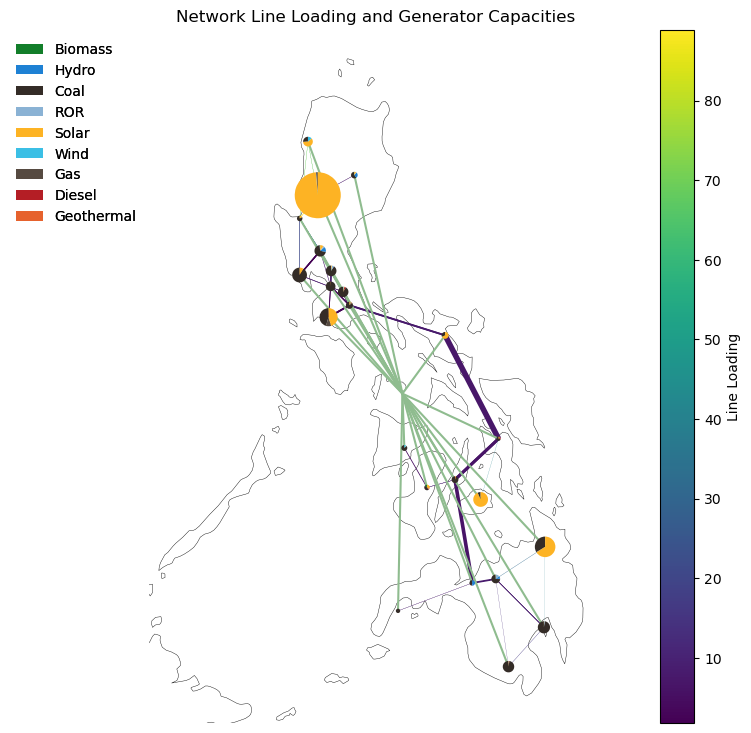

In [ ]:
plot_network(netvis,show_buses=True,show_loading=True,show_linecap=True)

/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/ipykernel_41932/466612590.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



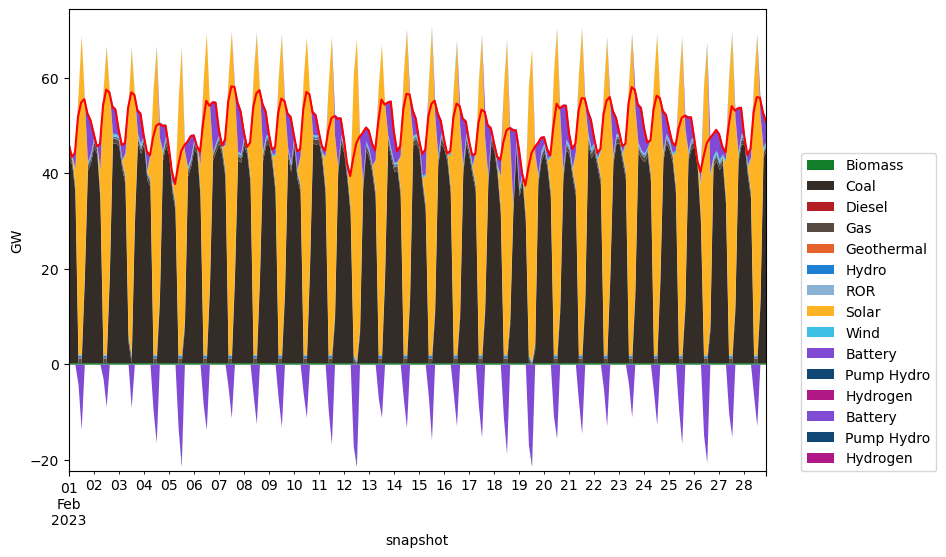

In [ ]:
plot_dispatch(netvis, time="2023-02") # Dry Season in Philippines

/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/ipykernel_41932/466612590.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



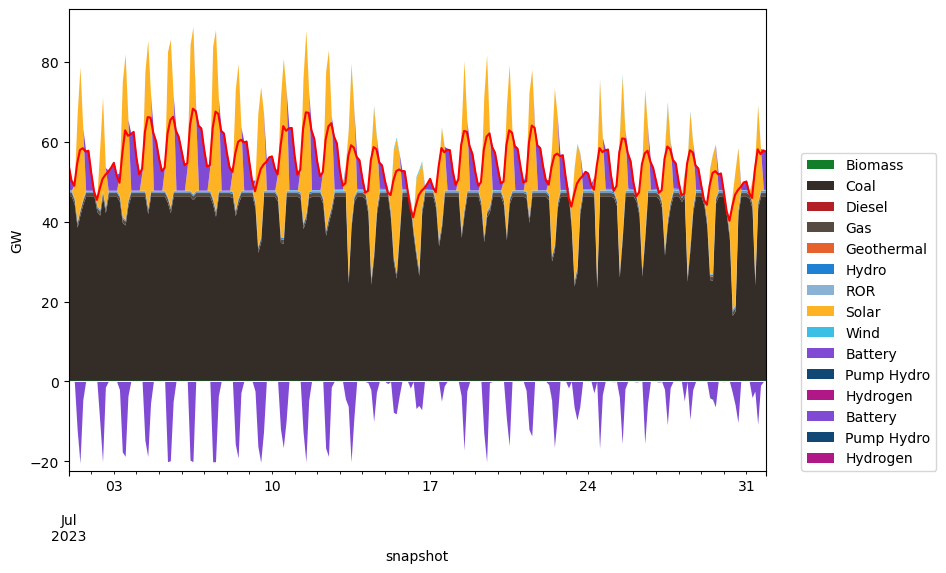

In [ ]:
plot_dispatch(netvis, time="2023-07") # Wet Season in Philippines

Bus LMP values:
Bus
main_H2                      231.327407
MERALCO NCR_H2               231.327407
MERALCO North_H2             231.327407
MERALCO South_H2             231.327407
Mindanao District 1_H2       231.327407
Mindanao District 2_H2       231.327407
Mindanao District 3_H2       231.327407
Mindanao District 4_H2       231.327407
Mindanao District 5_H2       231.327407
Mindanao District 6_H2       231.327407
North Luzon District 1_H2    231.327407
North Luzon District 2_H2    231.327407
North Luzon District 3_H2    231.327407
North Luzon District 4_H2    231.327407
North Luzon District 5_H2    231.327407
North Luzon District 6_H2    231.327407
South Luzon District 1_H2    231.327407
South Luzon District 2_H2    231.327407
South Luzon District 3_H2    231.327407
Visayas District 1_H2        231.327407
Visayas District 2a_H2       231.327407
Visayas District 2b_H2       231.327407
Visayas District 3_H2        231.327407
Visayas District 4_H2        231.327407
dtype: float64


/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



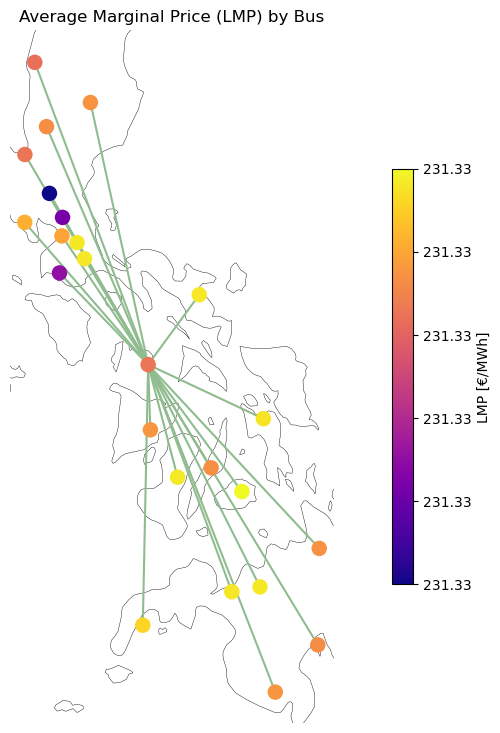

In [ ]:
plot_lmp(netvis, bus_carrier_filter=["Hydrogen"], print_values=True)

/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/ipykernel_41932/3002366324.py:5: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



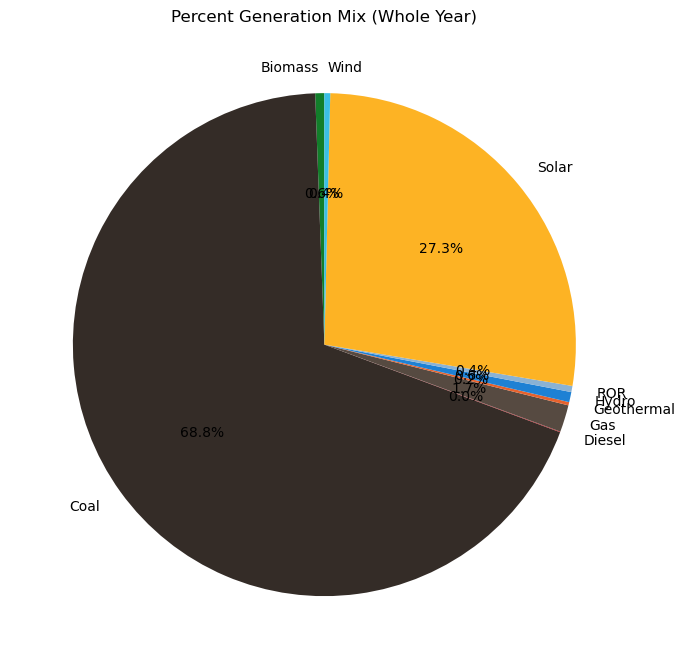

In [ ]:
plot_generation_mix_pie(netvis)

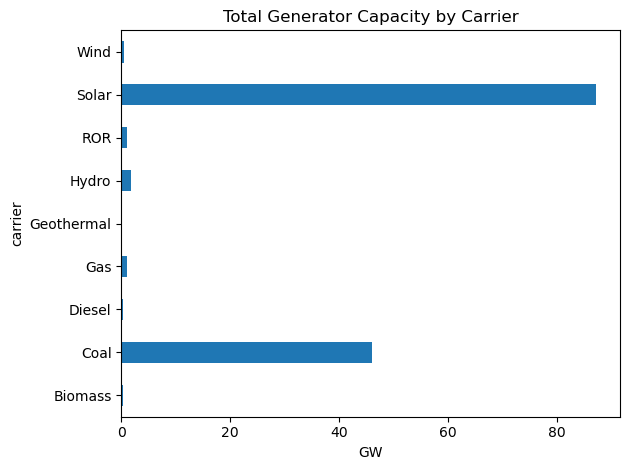

In [ ]:
plot_generator_capacity_by_carrier(netvis)

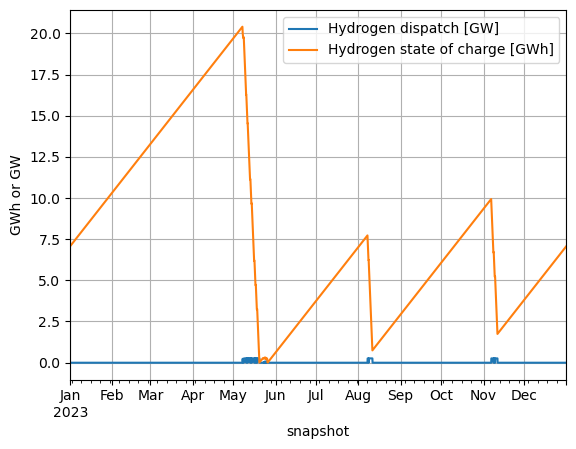

In [ ]:
plot_storage_dispatch(netvis, include_stores=True, carrier='Hydrogen')

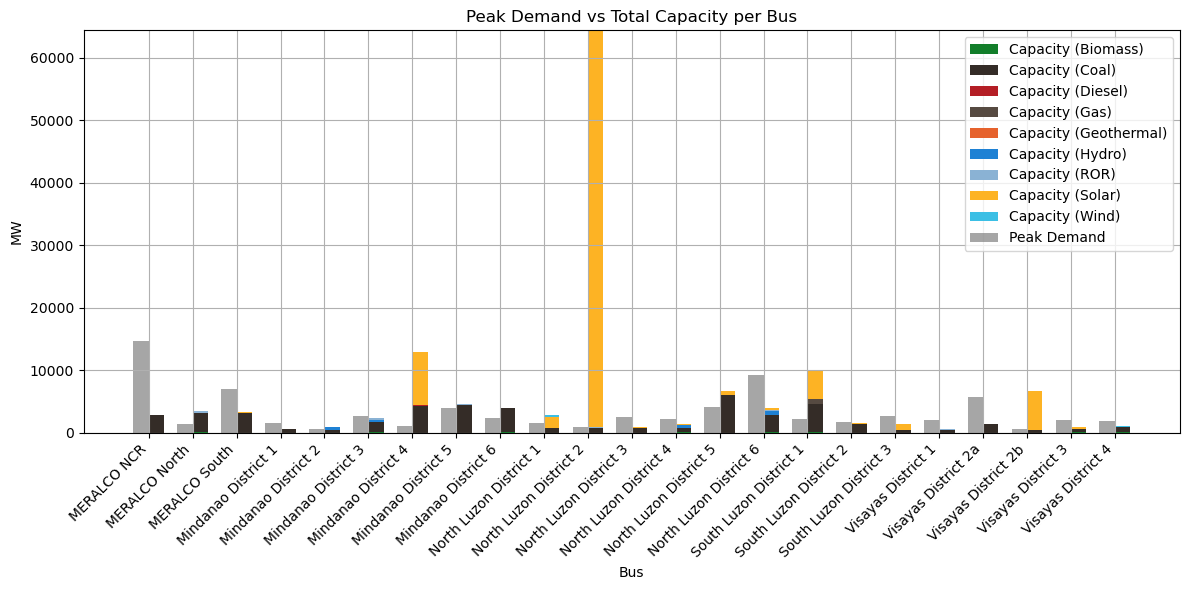

In [ ]:
plot_peak_demand_vs_capacity(netvis, stack_carrier=True)

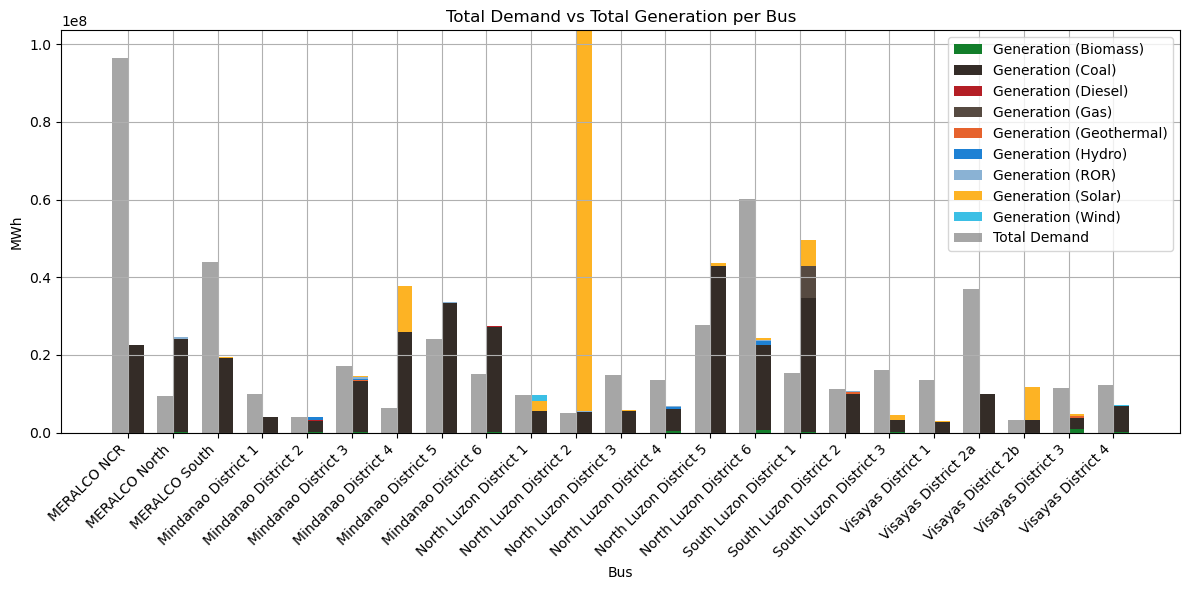

In [ ]:
plot_total_demand_vs_generation(netvis, temp_reso=3, stack_carrier=True)

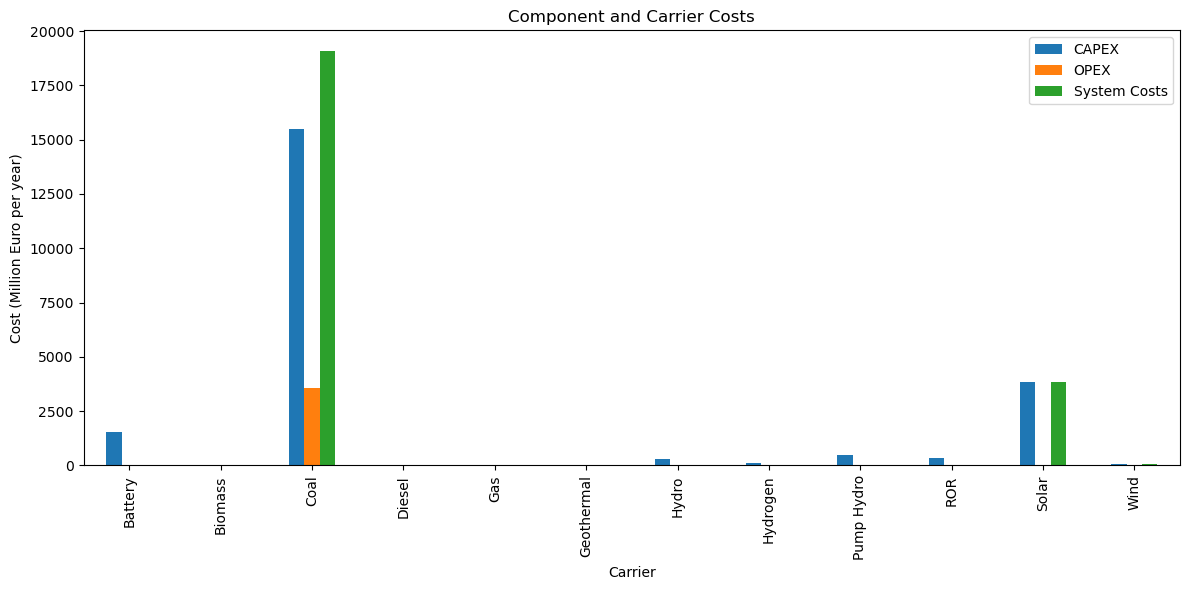

Total System Cost: 25810.10 Million Euro per Year


In [ ]:
combined_cost_plot(netvis, stacked=False)

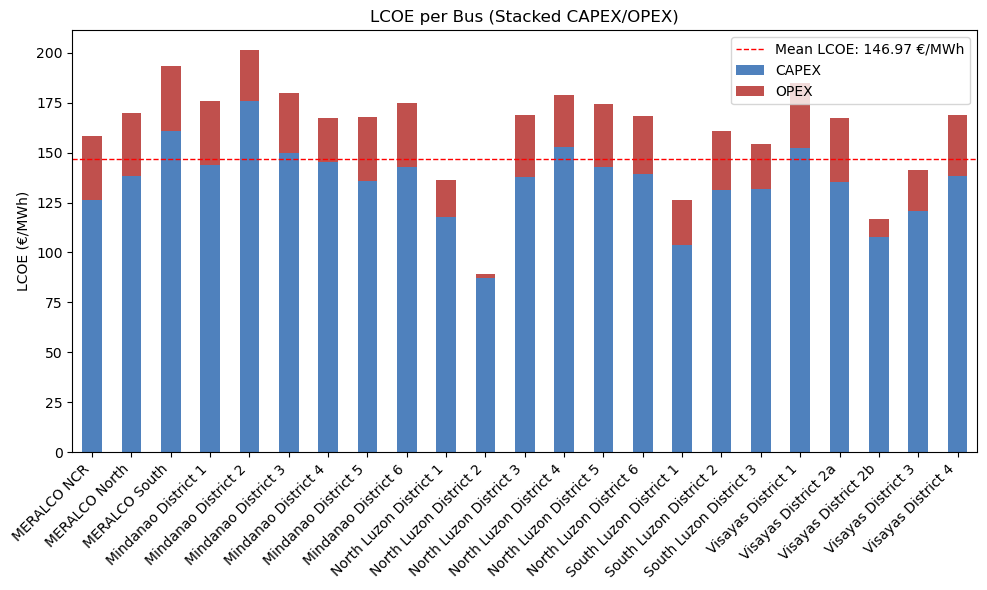

In [ ]:
plot_lcoe_by_bus(netvis, show_components=True)

In [ ]:
netvis.statistics()

Optimal Capacity  Installed Capacity        Supply  \
Generator   Biomass           322.600000          322.600000  9.400564e+05   
            Coal            45996.628553         8288.100000  1.107190e+08   
            Diesel            403.500000          403.500000  6.901934e+04   
            Gas               959.800000          959.800000  2.796987e+06   
            Geothermal        116.100000          116.100000  3.390120e+05   
            Hydro            1714.000000         1714.000000  1.046129e+06   
            ROR              1043.300000         1043.300000  6.367716e+05   
            Solar           87269.930962         2271.300000  4.388822e+07   
            Wind              537.100000          537.100000  6.023855e+05   
Line        AC             318757.184120        37495.644048  2.775515e+08   
Link        Hydrogen         6104.740073            0.000000  1.460000e+06   
Load        -                   0.000000            0.000000  1.852544e+02   
            Hydrogen            0.000000            0.000000  0.000000e+00   
StorageUnit Battery         20630.802492          547.000000  1.032451e+07   
            Pump Hydro        735.600000          735.600000  2.812726e+04   
Store       Hydrogen        20405.998685            0.000000  6.409833e+05   

                          Withdrawal      Dispatch  Transmission  \
Generator   Biomass     0.000000e+00  9.400564e+05  0.000000e+00   
            Coal        0.000000e+00  1.107190e+08  0.000000e+00   
            Diesel      0.000000e+00  6.901934e+04  0.000000e+00   
            Gas         0.000000e+00  2.796987e+06  0.000000e+00   
            Geothermal  0.000000e+00  3.390120e+05  0.000000e+00   
            Hydro       0.000000e+00  1.046129e+06  0.000000e+00   
            ROR         0.000000e+00  6.367716e+05  0.000000e+00   
            Solar       0.000000e+00  4.388822e+07  0.000000e+00   
            Wind        0.000000e+00  6.023855e+05  0.000000e+00   
Line        AC          2.775515e+08  0.000000e+00  4.741815e+07   
Link        Hydrogen    1.847575e+06 -3.875750e+05  7.300000e+05   
Load        -           1.590342e+08 -1.590341e+08  0.000000e+00   
            Hydrogen    7.300000e+05 -7.300000e+05  0.000000e+00   
StorageUnit Battery     1.120339e+07 -8.788778e+05  0.000000e+00   
            Pump Hydro  3.516121e+04 -7.033953e+03  0.000000e+00   
Store       Hydrogen    6.409833e+05  2.208893e-09  0.000000e+00   

                        Capacity Factor   Curtailment  Capital Expenditure  \
Generator   Biomass            0.997945  0.000000e+00         2.818037e+07   
            Coal               0.824353  0.000000e+00         1.551043e+10   
            Diesel             0.058579  0.000000e+00         1.632521e+07   
            Gas                0.997992  0.000000e+00         6.456919e+06   
            Geothermal         1.000000  0.000000e+00         3.066436e+06   
            Hydro              0.209022  4.362791e-08         3.131456e+08   
            ROR                0.209022  1.244198e-08         3.215141e+08   
            Solar              0.172227  1.002153e+04         3.823036e+09   
            Wind               0.384093  1.949118e+03         6.100607e+07   
Line        AC                 0.298195  0.000000e+00         0.000000e+00   
Link        Hydrogen           0.103646  0.000000e+00         6.082292e+07   
Load        -                       NaN  0.000000e+00         0.000000e+00   
            Hydrogen                NaN  0.000000e+00         0.000000e+00   
StorageUnit Battery            0.357357  0.000000e+00         1.520223e+09   
            Pump Hydro         0.029465  0.000000e+00         5.037580e+08   
Store       Hydrogen           0.387788  0.000000e+00         5.786978e+07   

                        Operational Expenditure       Revenue  Market Value  
Generator   Biomass                2.695988e+06  1.389383e+08  1.477979e+02  
            Coal                   3.566625e+09  1.907706

In [ ]:
# Compute total capital cost per carrier (capital_cost * p_nom_opt, then group by carrier)
CAPEX = (netvis.generators.capital_cost * netvis.generators.p_nom_opt).groupby(netvis.generators.carrier).sum()

# Compute total operating cost per carrier (operating_cost * p, then group by carrier)
OPEX = (netvis.generators.marginal_cost * netvis.generators_t.p.sum(axis=0)).groupby(netvis.generators.carrier).sum()

# Compute total production per carrier (sum of p over all time steps, then group by carrier)
PROD = netvis.generators_t.p.sum(axis=0).groupby(netvis.generators.carrier).sum()

LCOE_ave = (CAPEX.sum() + OPEX.sum()) / PROD.sum()
print(f'National average LCOE considering transmission is {LCOE_ave} Euro/MWh')

National average LCOE considering transmission is 146.96840051316988 Euro/MWh


#### 06.04 Multi-scenario Comparison Visualization

This section provides visual comparisons of key metrics—generation mix, CO₂ emissions, and LCOE—across multiple future power system scenarios, enabling an integrated assessment of system evolution and decarbonization pathways.

In [ ]:
raise RuntimeError("Stopping execution here.")

RuntimeError: Stopping execution here.

In [ ]:
def load_scenario_networks(scenario_name, results_dir="results"):
    """
    Loads all PyPSA .nc files for a given scenario from the results directory.
    
    Parameters:
        scenario_name (str): Name of the scenario (subdirectory in results).
        results_dir (str): Parent directory where scenario folders are stored.
        
    Returns:
        networks (list): List of loaded PyPSA Network objects.
        scenario_labels (list): List of scenario labels extracted from filenames.
    """

    output_dir = os.path.join(results_dir, scenario_name)
    scenario_files = sorted(glob.glob(os.path.join(output_dir, "*.nc")))
    scenario_labels = [os.path.splitext(os.path.basename(f))[0].split('_')[-1] for f in scenario_files]

    if not scenario_files:
        raise FileNotFoundError(f"No .nc files found in {output_dir}")

    networks = []
    for scenario in scenario_files:
        net = pypsa.Network(scenario)
        networks.append(net)
    return networks, scenario_labels

networks, scenario_labels = load_scenario_networks(scenario_name="2040H2dem1000")

       'MERALCO North_Solar_2040', 'MERALCO North_Wind_2040',
       'MERALCO South_Solar_2040', 'MERALCO South_Wind_2040',
       'Mindanao District 1_Wind_2040', 'Mindanao District 2_Solar_2040',
       'Mindanao District 2_Wind_2040', 'Mindanao District 3_Solar_2040',
       'Mindanao District 3_Wind_2040', 'Mindanao District 4_Wind_2040',
       'Mindanao District 5_Solar_2040', 'Mindanao District 5_Wind_2040',
       'Mindanao District 6_Solar_2040', 'Mindanao District 6_Wind_2040',
       'North Luzon District 1_Wind_2040', 'North Luzon District 2_Wind_2040',
       'North Luzon District 3_Solar_2040', 'North Luzon District 3_Wind_2040',
       'North Luzon District 4_Solar_2040', 'North Luzon District 4_Wind_2040',
       'North Luzon District 5_Solar_2040', 'North Luzon District 5_Wind_2040',
       'North Luzon District 6_Solar_2040', 'North Luzon District 6_Wind_2040',
       'South Luzon District 1_Solar_2040', 'South Luzon District 1_Wind_2040',
       'South Luzon District

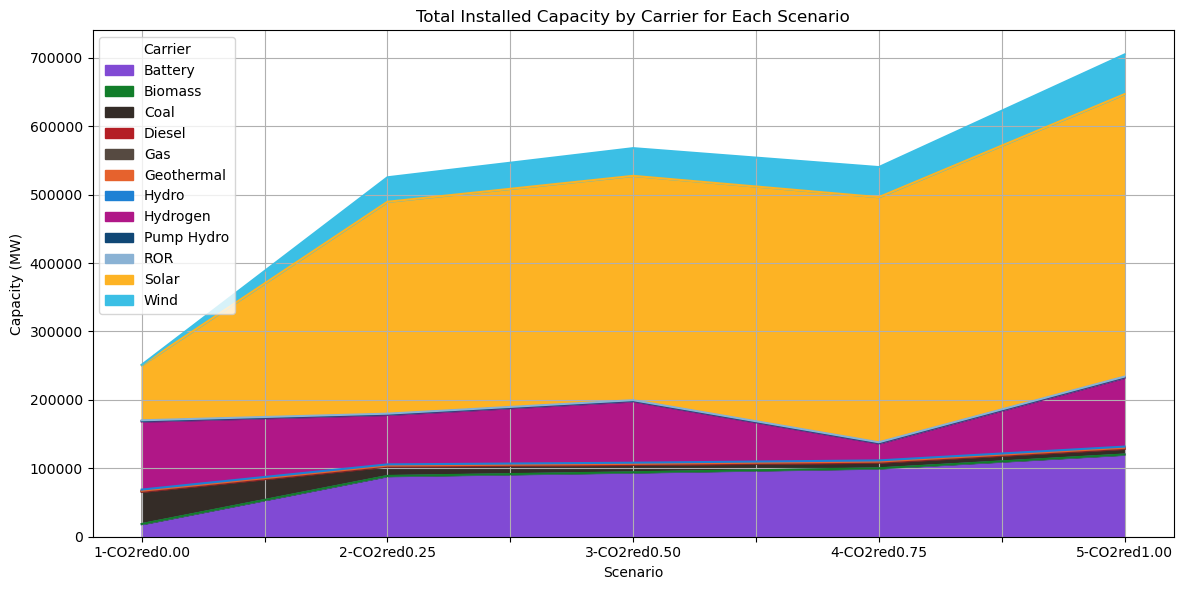

In [ ]:
def plot_capacity_mix_scenarios(networks, scenario_labels, time_series=False):
    """
    Plots the total generator and storage capacity by carrier for each scenario as a stacked bar plot.

    Parameters:
        networks (list): List of PyPSA Network objects for each scenario.
        scenario_labels (list): List of scenario names/labels corresponding to each network.
    """
    df_list = []
    for net, label in zip(networks, scenario_labels):
        # Generator capacities
        gen_cap = net.generators.groupby('carrier').p_nom_opt.sum()
        # StorageUnit capacities (use p_nom_opt for power capacity)
        if not net.storage_units.empty:
            sto_cap = net.storage_units.groupby('carrier').p_nom_opt.sum()
            cap = gen_cap.add(sto_cap, fill_value=0)
        else:
            cap = gen_cap
        # Store capacities (energy capacity, e_nom_opt)
        if not net.stores.empty and 'e_nom_opt' in net.stores.columns:
            store_cap = net.stores.groupby('carrier').e_nom_opt.sum()
            # Optionally, add store energy capacity as a separate bar or ignore
            cap = cap.add(store_cap, fill_value=0)  # Uncomment to include
        df = cap.reset_index()
        df.columns = ['Carrier', 'Capacity_MW']
        df['Scenario'] = label
        df_list.append(df)

    df_all = pd.concat(df_list, ignore_index=True)
    df_pivot = df_all.pivot(index='Scenario', columns='Carrier', values='Capacity_MW')

    # Get carrier colors from the last network
    carrier_colors = networks[-1].carriers['color'].to_dict()
    colors = [carrier_colors.get(carrier, "#333333") for carrier in df_pivot.columns]

    df_pivot.plot(kind= 'area' if time_series else 'bar', stacked=True, figsize=(12, 6), color=colors)
    plt.title('Total Installed Capacity by Carrier for Each Scenario')
    plt.xlabel('Scenario')
    plt.ylabel('Capacity (MW)')
    plt.legend(title='Carrier', loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_capacity_mix_scenarios(networks, scenario_labels, time_series=True)


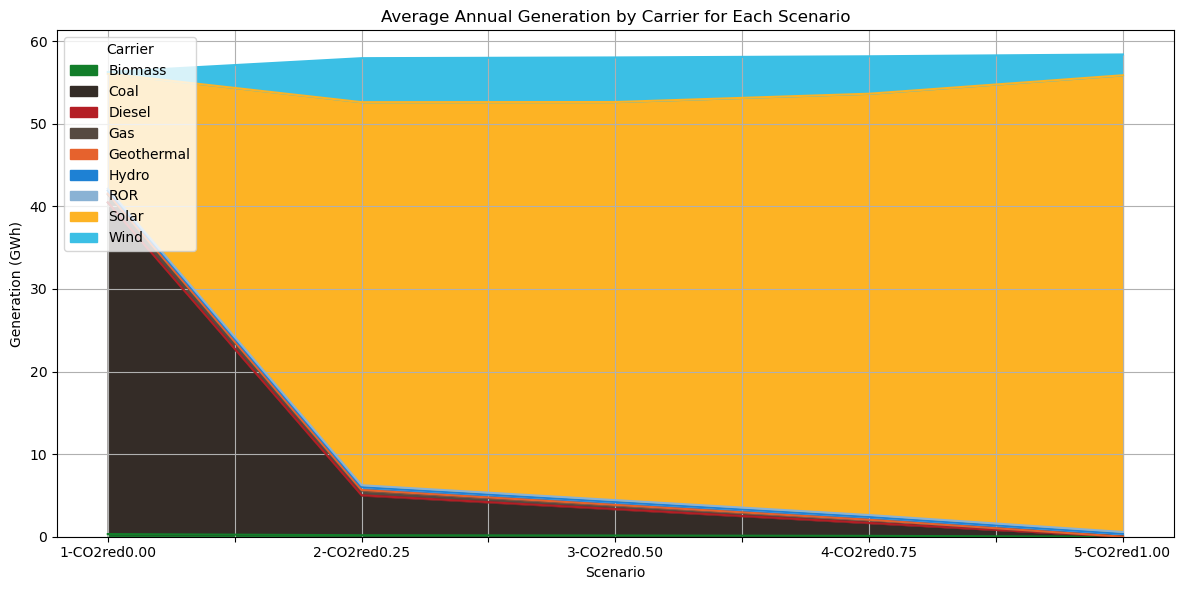

In [ ]:
def plot_generation_mix_scenarios(networks, scenario_labels, time_series=False):
    """
    Plots the average annual generation by carrier for each scenario as a stacked area plot.

    Parameters:
        networks (list): List of PyPSA Network objects for each scenario.
        scenario_labels (list): List of scenario names/labels corresponding to each network.
    """
    df_list = []
    for net, label in zip(networks, scenario_labels):
        df = total_generation(net)
        df['Scenario'] = label
        df_list.append(df)

    df_all = pd.concat(df_list, ignore_index=True)
    df_pivot = df_all.pivot(index='Scenario', columns='Carrier', values='Generation_GWh')

    # Get carrier colors from the first network
    carrier_colors = networks[0].carriers['color'].to_dict()
    colors = [carrier_colors.get(carrier, "#333333") for carrier in df_pivot.columns]

    df_pivot.plot(kind='bar' if time_series==False else 'area', stacked=True, figsize=(12, 6), color=colors)
    plt.title('Average Annual Generation by Carrier for Each Scenario')
    plt.xlabel('Scenario')
    plt.ylabel('Generation (GWh)')
    plt.legend(title='Carrier', loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_generation_mix_scenarios(networks, scenario_labels, time_series=True)


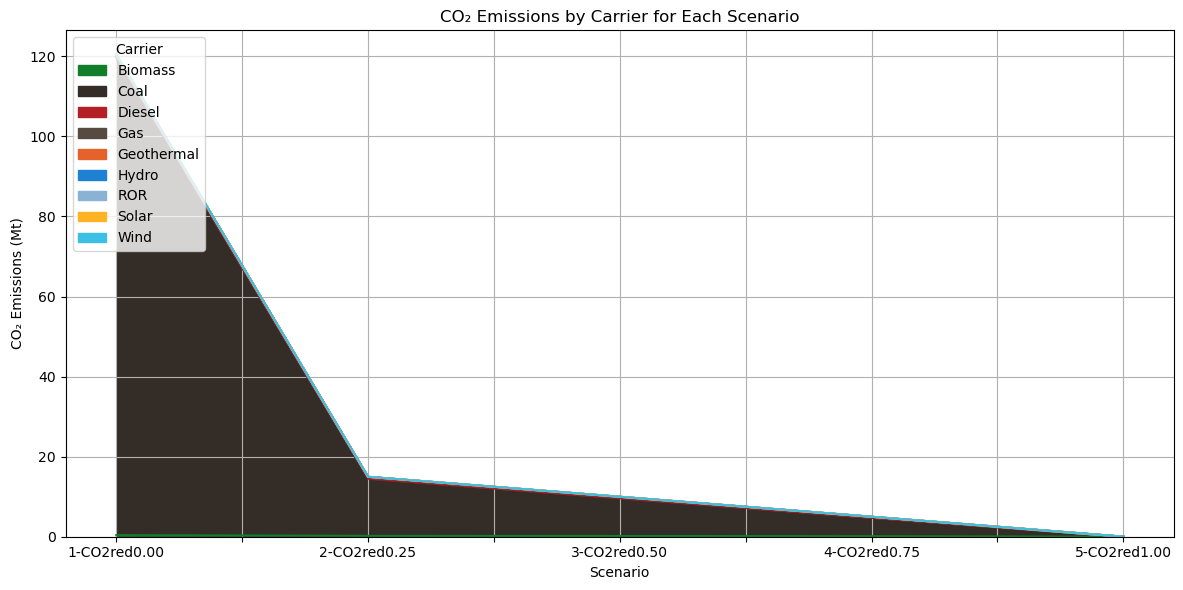

In [ ]:
def plot_emissions_scenarios(networks, scenario_labels, time_series=False):
    """
    Plots the CO₂ emissions by carrier for each scenario as a stacked bar or area plot.

    Parameters:
        networks (list): List of PyPSA Network objects for each scenario.
        scenario_labels (list): List of scenario names/labels corresponding to each network.
        time_series (bool): If True, plot as area plot (not supported for this summary); else bar plot.
    """
    df_list = []
    for net, label in zip(networks, scenario_labels):
        df = total_emissions(net)
        df['Scenario'] = label
        df_list.append(df)

    df_all = pd.concat(df_list, ignore_index=True)
    df_pivot = df_all.pivot(index='Scenario', columns='Carrier', values='Emission_tCO2/MWh_th')

    carrier_colors = networks[0].carriers['color'].to_dict()
    colors = [carrier_colors.get(carrier, "#333333") for carrier in df_pivot.columns]

    kind = 'area' if time_series else 'bar'
    df_pivot.plot(kind=kind, stacked=True, figsize=(12, 6), color=colors)

    plt.title('CO₂ Emissions by Carrier for Each Scenario')
    plt.xlabel('Scenario')
    plt.ylabel('CO₂ Emissions (Mt)')
    plt.legend(title='Carrier', loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_emissions_scenarios(networks, scenario_labels, time_series=True)


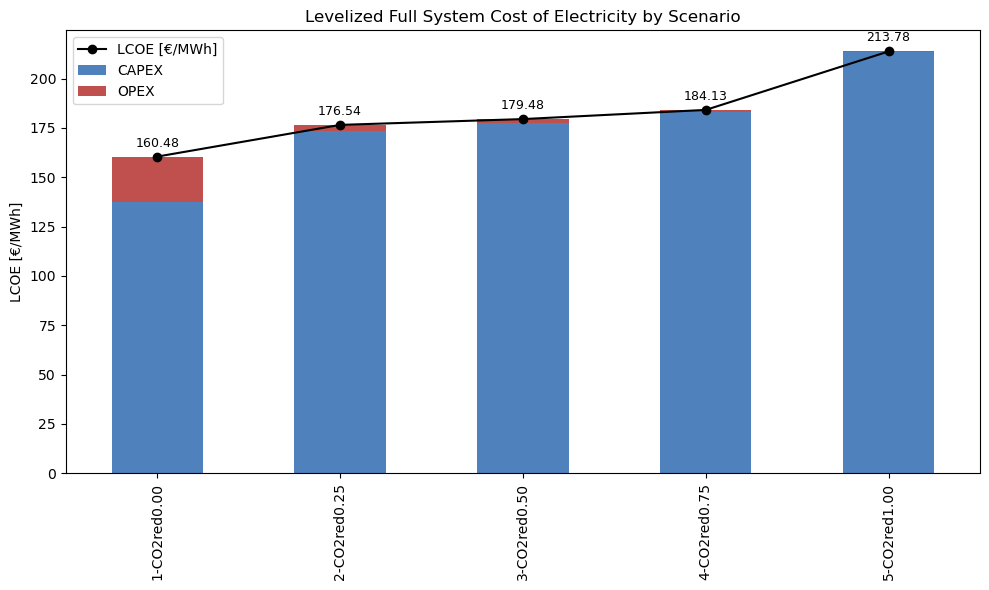

In [ ]:
def plot_lcoe_scenarios(networks, scenario_labels, show_components=False, stacked=None, calc_LFSCOE=False):
    """
    Plots the LCOE for each scenario as a bar chart (EUR/MWh).
    Optionally shows CAPEX and OPEX disaggregation.

    Parameters:
        networks (list): List of PyPSA Network objects for each scenario.
        scenario_labels (list): List of scenario names/labels corresponding to each network.
        show_components (bool): If True, show CAPEX and OPEX breakdown.
        stacked (bool or None): If True and show_components, stack CAPEX and OPEX. If None, auto-set to True when show_components.
    """
    lcoe_eur = []
    capex_eur = []
    opex_eur = []

    for net in networks:
        lcoe_data = calc_LCOE(net, calc_LFSCOE=calc_LFSCOE) 
        lcoe_eur.append(lcoe_data[3])
        capex_eur.append(lcoe_data[0] / lcoe_data[2])  # CAPEX per MWh
        opex_eur.append(lcoe_data[1] / lcoe_data[2])   # OPEX per MWh

    x = np.arange(len(scenario_labels))
    width = 0.5

    # Automatically stack when show_components is True and stacked is None
    if stacked is None and show_components:
        stacked = True

    if show_components:
        df = pd.DataFrame({
            'CAPEX': capex_eur,
            'OPEX': opex_eur,
            'LCOE': lcoe_eur
        }, index=scenario_labels)

        fig, ax = plt.subplots(figsize=(10, 6))
        df[['CAPEX', 'OPEX']].plot.bar(ax=ax, stacked=stacked, color=['#4F81BD', '#C0504D'], width=width)

        # Plot LCOE line and annotate values
        ax.plot(df.index, df['LCOE'], color='black', marker='o', label='LCOE [€/MWh]')
        for i, val in enumerate(df['LCOE']):
            ax.annotate(f'{val:.2f}', xy=(i, val), xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, color='black')

        ax.set_ylabel('LCOE [€/MWh]')
        ax.set_title(f'Levelized{" Full System " if calc_LFSCOE else " "}Cost of Electricity by Scenario')
        ax.legend()
        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(8, 6))
        bars = ax.bar(x, lcoe_eur, width, label='LCOE [€/MWh]', color='#1E81D4')
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
        ax.set_xticks(x)
        ax.set_xticklabels(scenario_labels, rotation=30, ha='right')

        ax.set_ylabel('LCOE [€/MWh]')
        ax.set_title(f'Levelized{" Full System " if calc_LFSCOE else " "}Cost of Electricity by Scenario')
        ax.legend()
        plt.tight_layout()
        plt.show()

# Example usage:
plot_lcoe_scenarios(networks, scenario_labels, show_components=True, calc_LFSCOE=True)


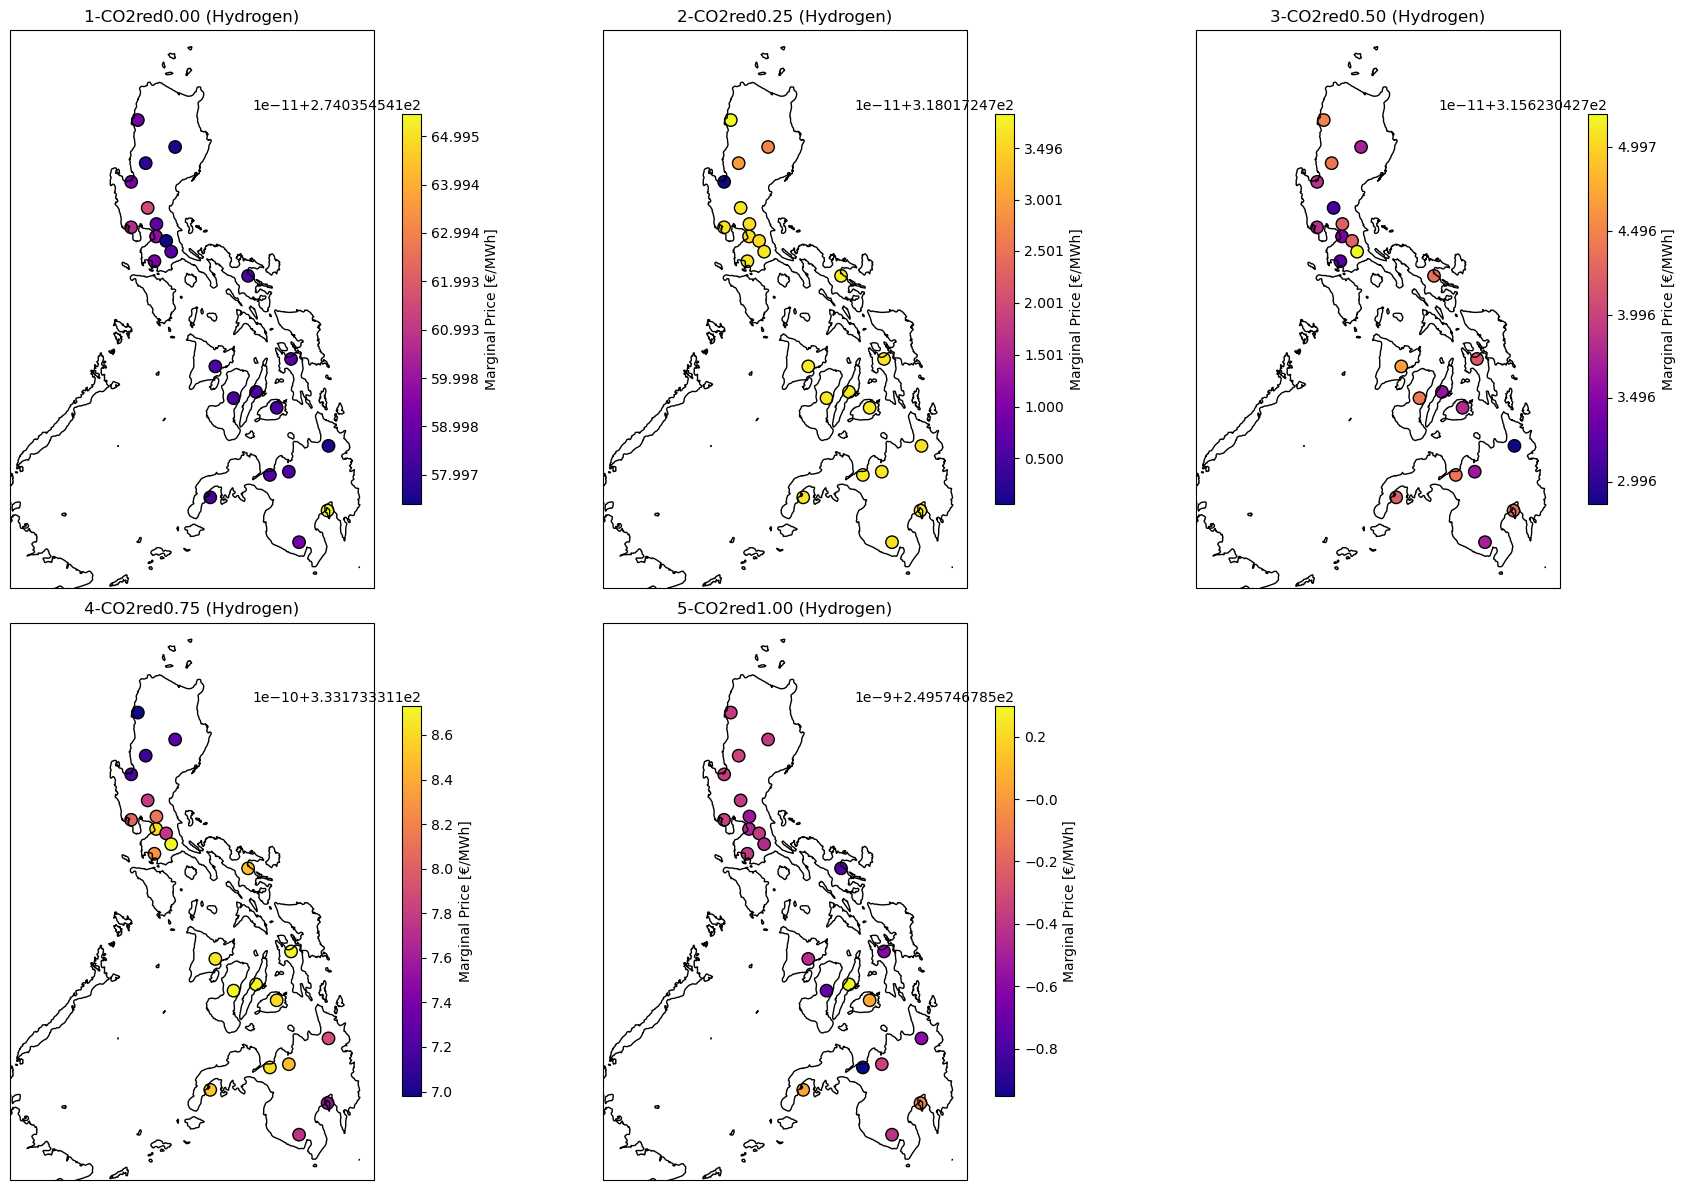

In [ ]:
import pandas as pd

def plot_bus_marginal_cost_maps(networks, scenario_labels, carrier="AC", print_table=False):
    """
    Plots bus maps of marginal costs for each scenario in subplots.
    Optionally prints a table of bus marginal costs (rows: buses, columns: scenarios).
    Parameters:
        networks (list): List of PyPSA Network objects.
        scenario_labels (list): List of scenario names/labels.
        carrier (str): Carrier to filter buses ("AC" or "Hydrogen").
        print_table (bool): If True, print bus marginal cost table.
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs

    n_scenarios = len(networks)
    n_cols = 3
    n_rows = (n_scenarios + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows),
                             subplot_kw={'projection': ccrs.Mercator()})
    axes = axes.flatten()

    # Collect bus marginal prices for table
    bus_table = {}

    for idx, (net, label) in enumerate(zip(networks, scenario_labels)):
        ax = axes[idx]
        buses = net.buses.index[net.buses.carrier == carrier]
        # Exclude "main_H2" if carrier is Hydrogen
        if carrier == "Hydrogen":
            buses = [b for b in buses if b != "main_H2"]
        if len(buses) == 0:
            ax.set_title(f"{label}\nNo '{carrier}' buses")
            ax.axis('off')
            continue
        x = net.buses.loc[buses, 'x']
        y = net.buses.loc[buses, 'y']
        marginal_price = net.buses_t.marginal_price[buses].mean()
        sc = ax.scatter(x, y, c=marginal_price, cmap='plasma', s=80, edgecolor='k', transform=ccrs.PlateCarree())
        ax.set_title(f"{label} ({carrier})")
        ax.coastlines(resolution='10m')
        ax.set_extent([117, 127, 5, 20], crs=ccrs.PlateCarree())
        plt.colorbar(sc, ax=ax, orientation='vertical', label='Marginal Price [€/MWh]', shrink=0.7)
        # Store for table
        for bus in buses:
            if bus not in bus_table:
                bus_table[bus] = {}
            bus_table[bus][label] = marginal_price[bus]

    # Hide unused subplots
    for j in range(idx+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    if print_table:
        # Create DataFrame: rows=buses, columns=scenario_labels
        df = pd.DataFrame.from_dict(bus_table, orient='index')
        df = df.reindex(sorted(df.index))  # Sort by bus name
        df = df[scenario_labels]  # Ensure column order
        return df

plot_bus_marginal_cost_maps(networks, scenario_labels, carrier="Hydrogen", print_table=False)

/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/ipykernel_41932/631106481.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



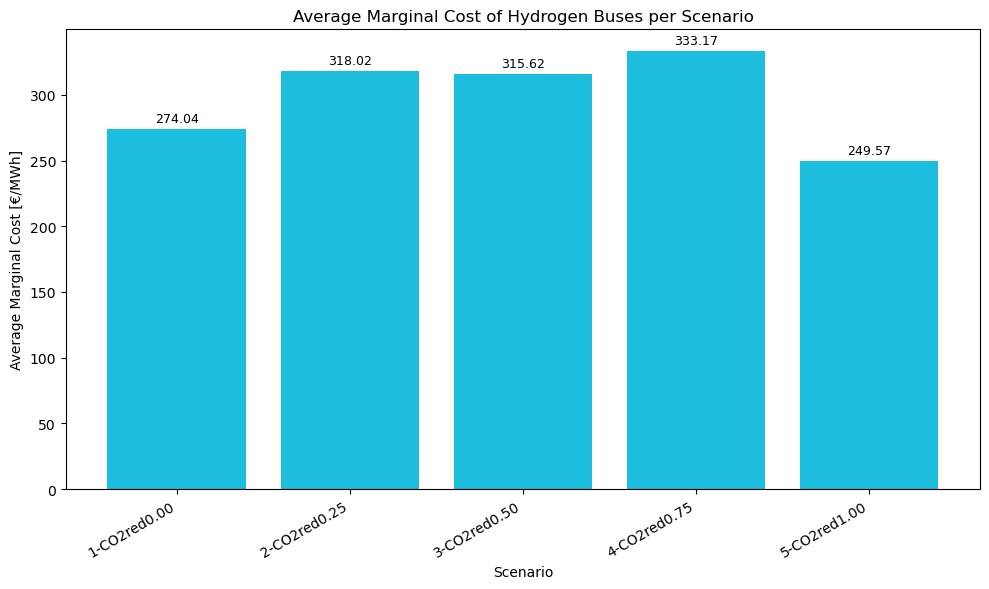

In [ ]:
def plot_avg_bus_marginal_cost_scenarios(networks, scenario_labels, carrier="AC"):
    """
    Plots a bar graph of the average marginal cost of the buses per scenario.

    Parameters:
        networks (list): List of PyPSA Network objects for each scenario.
        scenario_labels (list): List of scenario names/labels corresponding to each network.
        carrier (str): Carrier to filter buses (default "AC").
    """
    import matplotlib.pyplot as plt

    avg_marginal_costs = []
    for net in networks:
        buses = net.buses.index[net.buses.carrier == carrier]
        if len(buses) == 0:
            avg_marginal_costs.append(np.nan)
        else:
            avg_marginal_costs.append(net.buses_t.marginal_price[buses].mean().mean())

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(scenario_labels, avg_marginal_costs, color="#FDB324" if carrier == "AC" else "#1DBDDD")
    ax.set_ylabel("Average Marginal Cost [€/MWh]")
    ax.set_xlabel("Scenario")
    ax.set_title(f"Average Marginal Cost of {carrier} Buses per Scenario")
    ax.set_xticklabels(scenario_labels, rotation=30, ha='right')
    for bar, val in zip(bars, avg_marginal_costs):
        ax.annotate(f"{val:.2f}", xy=(bar.get_x() + bar.get_width() / 2, val),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()


plot_avg_bus_marginal_cost_scenarios(networks, scenario_labels, carrier="Hydrogen")

In [ ]:
networks1, scenario_labels1 = load_scenario_networks(scenario_name="2040CO2red0")
networks2, scenario_labels2 = load_scenario_networks(scenario_name="2040CO2red25")
networks3, scenario_labels3 = load_scenario_networks(scenario_name="2040CO2red50")
networks4, scenario_labels4 = load_scenario_networks(scenario_name="2040CO2red75")
networks5, scenario_labels5 = load_scenario_networks(scenario_name="2040CO2red100")

       'MERALCO North_Wind_2040', 'MERALCO South_Solar_2040',
       'MERALCO South_Wind_2040', 'Mindanao District 1_Solar_2040',
       'Mindanao District 1_Wind_2040', 'Mindanao District 2_Solar_2040',
       'Mindanao District 2_Wind_2040', 'Mindanao District 3_Solar_2040',
       'Mindanao District 3_Wind_2040', 'Mindanao District 4_Solar_2040',
       'Mindanao District 4_Wind_2040', 'Mindanao District 5_Solar_2040',
       'Mindanao District 5_Wind_2040', 'Mindanao District 6_Solar_2040',
       'Mindanao District 6_Wind_2040', 'North Luzon District 1_Solar_2040',
       'North Luzon District 1_Wind_2040', 'North Luzon District 2_Wind_2040',
       'North Luzon District 3_Solar_2040', 'North Luzon District 3_Wind_2040',
       'North Luzon District 4_Solar_2040', 'North Luzon District 4_Wind_2040',
       'North Luzon District 5_Solar_2040', 'North Luzon District 5_Wind_2040',
       'North Luzon District 6_Solar_2040', 'North Luzon District 6_Wind_2040',
       'South Luzon Dist

/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/ipykernel_41932/3354256513.py:47: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



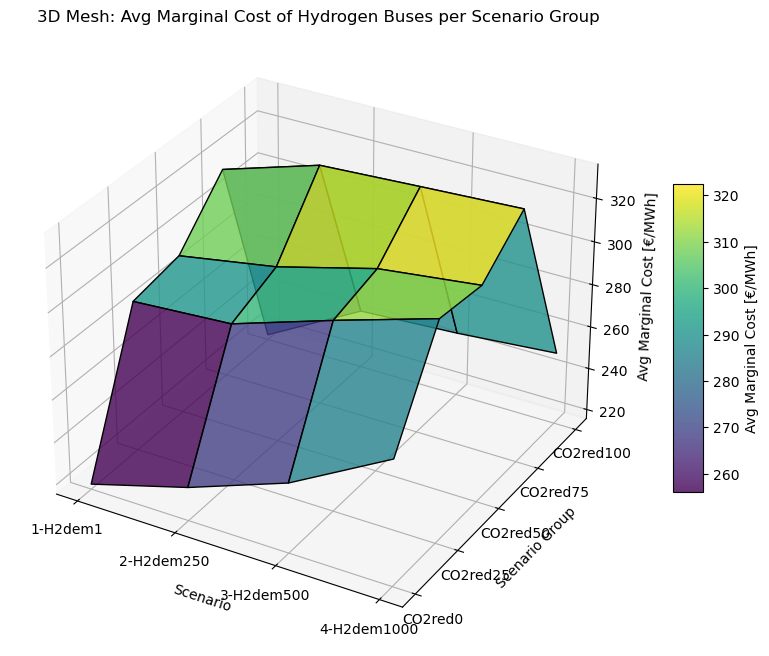

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_bus_marginal_cost_mesh(networks_list, scenario_labels_list, group_names=None, carrier="AC"):
    """
    Plots a 3D mesh plot of the average marginal cost of the buses per scenario for multiple network groups.

    Parameters:
        networks_list (list of list): List of lists of PyPSA Network objects for each scenario group.
        scenario_labels_list (list of list): List of lists of scenario names/labels corresponding to each network group.
        carrier (str): Carrier to filter buses (default "AC").
        group_names (list of str, optional): Names for each scenario group (y-axis labels).
    """
    n_groups = len(networks_list)
    max_scenarios = max(len(labels) for labels in scenario_labels_list)
    Z = np.full((n_groups, max_scenarios), np.nan)

    for group_idx, (networks, scenario_labels) in enumerate(zip(networks_list, scenario_labels_list)):
        for scen_idx, (net, label) in enumerate(zip(networks, scenario_labels)):
            buses = net.buses.index[net.buses.carrier == carrier]
            if len(buses) == 0:
                avg_cost = np.nan
            else:
                avg_cost = net.buses_t.marginal_price[buses].mean().mean()
            Z[group_idx, scen_idx] = avg_cost

    X, Y = np.meshgrid(np.arange(max_scenarios), np.arange(n_groups))

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.8)

    ax.set_xlabel('Scenario')
    ax.set_ylabel('Scenario Group')
    ax.set_zlabel('Avg Marginal Cost [€/MWh]')
    ax.set_xticks(np.arange(max_scenarios))
    ax.set_xticklabels(scenario_labels_list[0])
    if group_names is not None:
        ax.set_yticks(np.arange(n_groups))
        ax.set_yticklabels(group_names)
    else:
        ax.set_yticks(np.arange(n_groups))
        ax.set_yticklabels([f'Group {i+1}' for i in range(n_groups)])
    ax.set_title(f"3D Mesh: Avg Marginal Cost of {carrier} Buses per Scenario Group")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Avg Marginal Cost [€/MWh]')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_avg_bus_marginal_cost_mesh(
    [networks1, networks2, networks3, networks4, networks5],
    [scenario_labels1, scenario_labels2, scenario_labels3, scenario_labels4, scenario_labels5],
    group_names=["CO2red0", "CO2red25", "CO2red50", "CO2red75", "CO2red100"],
    carrier="Hydrogen"
)


### 07 Off-Grid Island Integration and Microgrid Scenario Analysis

This section enables users to explore the integration of off-grid islands and microgrids into the main Philippine power system using publicly available data from [doi.org/10.1016/j.dib.2022.108485](https://doi.org/10.1016/j.dib.2022.108485). The dataset provides detailed information on the geographic, demographic, and electrical characteristics of over 600 off-grid islands in the Philippines, including their peak loads, population, and existing generation assets.

#### Key Features

- **Microgrid Data Integration:**  
    The provided dataset (`microgrids_df`, `peak_load_df`, `solar_GHI_df`, `wind_speed_df`, etc.) allows users to analyze the technical and economic potential of each off-grid island or microgrid, including renewable resource availability and demand profiles.

- **Scenario Building:**  
    Users can construct scenarios to:
    - Connect specific islands or island groups (microgrids) to selected buses of the main grid.
    - Interconnect off-grid islands with each other to form regional microgrids.
    - Simulate hybridization options (e.g., solar, wind, storage, diesel) for isolated operation or future interconnection.

- **Flexible Analysis:**  
    This framework supports studies on:
    - The impact of grid extension and interconnection on system reliability, costs, and emissions.
    - The benefits of hybrid renewable systems for off-grid electrification.
    - The prioritization of islands for interconnection based on technical, economic, or policy criteria.

#### Example Use Cases

- **Island-to-Mainland Interconnection:**  
    Model the technical and economic effects of connecting a high-demand island (e.g., Palawan) to the Luzon or Visayas grid via a new transmission line.

- **Microgrid Hybridization:**  
    Assess the optimal mix of solar, wind, storage, and diesel for a remote island group, considering local resource profiles and load patterns.

- **Regional Microgrid Formation:**  
    Simulate the interconnection of several neighboring off-grid islands to form a larger, more resilient microgrid, and evaluate the resulting operational and economic benefits.

#### How to Use

1. **Select Islands or Microgrids:**  
     Use the `microgrids_df` DataFrame to identify islands of interest by geographic region, population, or existing infrastructure.

2. **Assign Connection Points:**  
     Define which main grid bus (from the PyPSA network) or neighboring island each microgrid will connect to.

3. **Configure Scenarios:**  
     Set up scenarios for:
     - Standalone operation (off-grid hybridization)
     - Interconnection to the main grid
     - Inter-island microgrid formation

4. **Run Simulations:**  
     Integrate the selected islands into the PyPSA network, update the network topology, and perform optimization studies to analyze system performance, costs, and emissions.

5. **Analyze Results:**  
     Use the provided visualization and analysis tools to compare scenarios and inform planning decisions.

---

**References:**  
- [Castro, M. T., et al. (2022). Data on the techno-economic and financial analyses of hybrid renewable energy systems in 634 Philippine off-grid islands. Data in Brief, 44, 108485.](https://doi.org/10.1016/j.dib.2022.108485)

This section provides a flexible, data-driven approach for researchers, planners, and policymakers to evaluate off-grid electrification strategies and the potential for integrating remote islands into the national power system.

In [134]:
# Load Offgrid Data
islands_df = pd.read_excel("data/Offgrid_Data/DIB_SupplementaryMaterial_18JUL2022.xlsx", sheet_name="S2 - Islands").set_index("Island ID") # Using Island ID, get bus data x: Latitude [°]; y: Longitude [°]; name: Island Name
microgrids_df = pd.read_excel("data/Offgrid_Data/DIB_SupplementaryMaterial_18JUL2022.xlsx", sheet_name="S3 - Microgrids").set_index("Microgrid ID") # Get Island ID data for network "Microgrid ID" based on interconnected islands : Central Island ID, Interconnected Island 1, Interconnected Island 2, Interconnected Island 3 when building network

peak_load_df = pd.read_excel("data/Offgrid_Data/DIB_SupplementaryMaterial_18JUL2022.xlsx", sheet_name="S6 - Peak Load").set_index("Island ID")
norm_loadprof_df_1MWmore = pd.read_excel("data/Offgrid_Data/DIB_SupplementaryMaterial_18JUL2022.xlsx", sheet_name="S7 - NormLoadProf 1MW").set_index("Hour")
norm_loadprof_df_100kW = pd.read_excel("data/Offgrid_Data/DIB_SupplementaryMaterial_18JUL2022.xlsx", sheet_name="S7 - NormLoadProf 100kW").set_index("Hour")
norm_loadprof_df_100kWless = pd.read_excel("data/Offgrid_Data/DIB_SupplementaryMaterial_18JUL2022.xlsx", sheet_name="S7 - NormLoadProf <100kW").set_index("Hour")

existing_diesel_capacity_df = pd.read_excel("data/Offgrid_Data/DIB_SupplementaryMaterial_18JUL2022.xlsx", sheet_name="S8 - Existing Diesel Capacity").set_index("Microgrid ID") # Existing diesel capacity in kW obtained from column "Total Diesel [kW]"
solar_GHI_df = pd.read_excel("data/Offgrid_Data/DIB_SupplementaryMaterial_18JUL2022.xlsx", sheet_name="S9 - GHI").set_index("Microgrid ID") #GHI monthly average in kW/m2, assume p_max as 1kW/m2
wind_speed_df = pd.read_excel("data/Offgrid_Data/DIB_SupplementaryMaterial_18JUL2022.xlsx", sheet_name="S10 - Wind Speed").set_index("Microgrid ID")
p_max_pu_normprof_df = pd.read_csv("data/Offgrid_Data/off-grid_RE.csv").set_index("timestamp")

In [344]:
def generate_hourly_load_profile(island_id, peak_load_df, 
                                 norm_loadprof_df_1MWmore, 
                                 norm_loadprof_df_100kW, 
                                 norm_loadprof_df_100kWless, 
                                 p_max_pu_normprof_df):
    """
    Generate an hourly load profile for a given island_id using the appropriate normalized profile
    and the annual peak load from peak_load_df.

    Parameters:
        island_id (int): Island ID to generate the profile for.
        peak_load_df (pd.DataFrame): DataFrame with 'Peak Load [kW]' column, indexed by Island ID.
        norm_loadprof_df_1MW (pd.DataFrame): Normalized profile for >1MW.
        norm_loadprof_df_100kW (pd.DataFrame): Normalized profile for 100kW-1MW.
        norm_loadprof_df_100kWless (pd.DataFrame): Normalized profile for <100kW.
        p_max_pu_normprof_df (pd.DataFrame): DataFrame with hourly timestamps to match.

    Returns:
        pd.Series: Hourly load profile for the year, indexed by the timestamps of p_max_pu_normprof_df.
    """
    # Get peak load value
    peak = peak_load_df.loc[island_id, "Peak Load [kW]"]  # in kW

    # Select normalized profile based on peak load
    if peak >= 1000:
        norm_prof = norm_loadprof_df_1MWmore
    elif peak >= 100:
        norm_prof = norm_loadprof_df_100kW
    else:
        norm_prof = norm_loadprof_df_100kWless

    # Ensure the index is a proper DatetimeIndex with known format
    if not isinstance(p_max_pu_normprof_df.index, pd.DatetimeIndex):
        p_max_pu_normprof_df.index = pd.to_datetime(p_max_pu_normprof_df.index, format='%m/%d/%y %H:%M')

    # Build a mapping from month number to column name in norm_prof
    month_map = {i + 1: col for i, col in enumerate(norm_prof.columns)}

    # Build hourly values
    hourly_values = [
        norm_prof.loc[ts.hour, month_map[ts.month]]
        for ts in p_max_pu_normprof_df.index
    ]

    # Convert to Series and scale so that max = peak (in MW)
    hourly_profile = pd.Series(hourly_values, index=p_max_pu_normprof_df.index)
    hourly_profile = hourly_profile / hourly_profile.max() * (peak / 1000)

    return hourly_profile


In [201]:
def compute_p_max_pu_from_wind_speed(wind_speed_df):
    """
    Given a DataFrame of wind speeds (rows: Microgrid ID, columns: months),
    returns a DataFrame of p_max_pu (same shape) using a typical wind turbine power curve.
    """
    from scipy.interpolate import interp1d
    import numpy as np
    import pandas as pd

    # Define typical wind turbine power curve for Vestas V112 ~3.0 MW
    wind_speeds = np.array([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 25])
    power_output = np.array([0, 0, 0.03, 0.1, 0.2, 0.35, 0.5, 0.7, 0.85, 0.95, 1.0, 1.0, 0])

    # Interpolation function
    power_curve_func = interp1d(wind_speeds, power_output, kind='linear', bounds_error=False, fill_value=0.0)

    # Apply to each value in the DataFrame
    p_max_pu_df = wind_speed_df.apply(lambda col: col.map(power_curve_func))
    p_max_pu_df.columns = wind_speed_df.columns
    p_max_pu_df.index = wind_speed_df.index
    return p_max_pu_df


In [202]:
import numpy as np
from scipy.interpolate import interp1d

def scale_hourly_solar_p_max_pu(microgrid_row, p_max_pu_normprof_df):
    """
    Scales the normalized hourly solar profile (p_max_pu_normprof_df['PH_Solar'])
    using the monthly average GHI (or p_max_pu) from a row in solar_GHI_df.

    Args:
        microgrid_row: pandas Series, one row from solar_GHI_df (12 months, index 1-12 or Jan-Dec)
        p_max_pu_normprof_df: DataFrame with 'PH_Solar' column, hourly (8760 or 2920 rows)

    Returns:
        pandas.Series: scaled hourly p_max_pu for solar generator (same index as p_max_pu_normprof_df)
    """

    # Ensure month order is 1-12 (or Jan-Dec)
    if isinstance(microgrid_row.index[0], int) or microgrid_row.index[0].isdigit():
        months = np.arange(1, 13)
        monthly_avgs = microgrid_row.values.astype(float)
    else:
        # Assume Jan-Dec
        months = np.arange(1, 13)
        monthly_avgs = microgrid_row.values.astype(float)

    # Build interpolation function for monthly averages (extend to 0 and 13 for wrap-around)
    interp_months = np.concatenate(([0], months, [13]))
    interp_avgs = np.concatenate(([monthly_avgs[-1]], monthly_avgs, [monthly_avgs[0]]))
    month_interp = interp1d(interp_months, interp_avgs, kind='linear')

    # For each hourly timestamp, get the month (1-12)
    # If index is datetime, use .month, else parse from string
    if isinstance(p_max_pu_normprof_df.index, pd.DatetimeIndex):
        months_of_year = p_max_pu_normprof_df.index.month
    else:
        # Try to parse month from string like '1/1/23 0:00'
        months_of_year = pd.to_datetime(p_max_pu_normprof_df.index, errors='coerce').month

    # Interpolated monthly average for each hour
    hourly_monthly_avg = month_interp(months_of_year)

    # Scale normalized profile
    scaled = p_max_pu_normprof_df['PH_Solar'].values * hourly_monthly_avg

    return pd.Series(scaled, index=p_max_pu_normprof_df.index, name='scaled_p_max_pu_solar')

def scale_hourly_wind_p_max_pu(microgrid_row, p_max_pu_normprof_df):
    """
    Scales the normalized hourly wind profile (p_max_pu_normprof_df['PH_Wind'])
    using the monthly average wind p_max_pu from a row in wind_p_max_pu_df.

    Args:
        microgrid_row: pandas Series, one row from wind_p_max_pu_df (12 months, index 1-12 or Jan-Dec)
        p_max_pu_normprof_df: DataFrame with 'PH_Wind' column, hourly (8760 or 2920 rows)

    Returns:
        pandas.Series: scaled hourly p_max_pu for wind generator (same index as p_max_pu_normprof_df)
    """
    # Ensure month order is 1-12 (or Jan-Dec)
    if isinstance(microgrid_row.index[0], int) or microgrid_row.index[0].isdigit():
        months = np.arange(1, 13)
        monthly_avgs = microgrid_row.values.astype(float)
    else:
        # Assume Jan-Dec
        months = np.arange(1, 13)
        monthly_avgs = microgrid_row.values.astype(float)

    # Build interpolation function for monthly averages (extend to 0 and 13 for wrap-around)
    interp_months = np.concatenate(([0], months, [13]))
    interp_avgs = np.concatenate(([monthly_avgs[-1]], monthly_avgs, [monthly_avgs[0]]))
    month_interp = interp1d(interp_months, interp_avgs, kind='linear')

    # For each hourly timestamp, get the month (1-12)
    if isinstance(p_max_pu_normprof_df.index, pd.DatetimeIndex):
        months_of_year = p_max_pu_normprof_df.index.month
    else:
        months_of_year = pd.to_datetime(p_max_pu_normprof_df.index, errors='coerce').month

    hourly_monthly_avg = month_interp(months_of_year)

    scaled = p_max_pu_normprof_df['PH_Wind'].values * hourly_monthly_avg

    return pd.Series(scaled, index=p_max_pu_normprof_df.index, name='scaled_p_max_pu_wind')

In [424]:
def build_microgrid_network(
    microgrid_id,
    islands_df,
    microgrids_df,
    peak_load_df,
    norm_loadprof_df_1MWmore,
    norm_loadprof_df_100kW,
    norm_loadprof_df_100kWless,
    p_max_pu_normprof_df,
    solar_GHI_df,
    wind_speed_df,
    existing_diesel_capacity_df,
    year=2020):
    """
    Build a PyPSA network for a microgrid (set of interconnected islands).

    Parameters:
        microgrid_id (int): Microgrid ID to build.
        microgrids_df, peak_load_df, norm_loadprof_df_1MWmore, norm_loadprof_df_100kW,
        norm_loadprof_df_100kWless, p_max_pu_normprof_df, solar_GHI_df, wind_speed_df,
        existing_diesel_capacity_df: DataFrames as described above.
        snapshots (pd.DatetimeIndex, optional): If provided, use as network snapshots.

    Returns:
        pypsa.Network: The built microgrid network.
    """
    costs_data = get_costs_data(year)

    # Helper: get all island IDs in the microgrid (central + up to 3 interconnected)
    row = microgrids_df.loc[microgrid_id]
    island_ids = [int(row['Central Island ID'])]
    for col in ['Interconnected Island 1', 'Interconnected Island 2', 'Interconnected Island 3']:
        val = row.get(col)
        if pd.notnull(val):
            island_ids.append(int(val))

    # Build network
    n = pypsa.Network()
    # Set snapshots
    n.set_snapshots(pd.date_range(start="2023-01-01 00:00:00", end="2023-12-31 23:00:00", freq="h"))

    # Add buses for each island
    for island_id in island_ids:
        # Use latitude/longitude from islands_df
        lat = islands_df.loc[island_id, 'Latitude [°]']
        lon = islands_df.loc[island_id, 'Longitude [°]']
        n.add("Bus", name=island_id, x=lon, y=lat)
        n.buses.loc[str(island_id), 'island_name'] = islands_df.loc[island_id, 'Island Name']

    # Connect islands with lines (simple: connect all to central island)
    central_bus = island_ids[0]
    for island_id in island_ids[1:]:
        n.add("Line", name=f"line_{central_bus}_{island_id}",
              bus0=central_bus, bus1=island_id,
              x=0.01, r=0.01, s_nom=1e4, s_nom_extendable=True)

    # For each island, add load
    for island_id in island_ids:
        bus = island_id

        # Load
        load_profile = generate_hourly_load_profile(
            island_id, peak_load_df,
            norm_loadprof_df_1MWmore, norm_loadprof_df_100kW, norm_loadprof_df_100kWless,
            p_max_pu_normprof_df
        )
        n.add("Load", name=f"load_{island_id}", bus=bus)
        if not hasattr(n.loads_t, "p_set"):
            n.loads_t.p_set = pd.DataFrame(index=n.snapshots)
        n.loads_t.p_set[f"load_{island_id}"] = load_profile.values

    # Add carriers with colors
    n.add("Carrier", name="Diesel", color=carrier_colors["Diesel"])
    n.add("Carrier", name="Solar", color=carrier_colors["Solar"])
    n.add("Carrier", name="Wind", color=carrier_colors["Wind"])
    n.add("Carrier", name="Battery", color=carrier_colors["Battery"])

    # Existing diesel (fixed capacity, not extendable)
    diesel_cap = existing_diesel_capacity_df.loc[microgrid_id, "Total Diesel [kW]"]/1000 if microgrid_id in existing_diesel_capacity_df.index else 0
    if diesel_cap > 0:
        n.add("Generator", name=f"diesel_{central_bus}_existing", bus=central_bus,
            carrier="Diesel", p_nom=diesel_cap, p_nom_extendable=False,
            efficiency=costs_data.at["oil", "efficiency"], 
            marginal_cost=costs_data.at["oil", "marginal_cost"], 
            capital_cost=costs_data.at["oil", "capital_cost"])

    # Extendable diesel
    n.add("Generator", name=f"diesel_{central_bus}_ext", bus=central_bus,
            carrier="Diesel", p_nom=0, p_nom_extendable=True,
            efficiency=costs_data.at["oil", "efficiency"], 
            marginal_cost=costs_data.at["oil", "marginal_cost"], 
            capital_cost=costs_data.at["oil", "capital_cost"])

    # Solar (extendable)
    if central_bus in solar_GHI_df.index:
        ghi_row = solar_GHI_df.loc[central_bus]
        solar_pu = scale_hourly_solar_p_max_pu(ghi_row, p_max_pu_normprof_df)
        n.add("Generator", name=f"solar_{central_bus}", bus=central_bus,
                carrier="Solar", p_nom=0, p_nom_extendable=True,
                efficiency=costs_data.at["solar", "efficiency"], 
                marginal_cost=costs_data.at["solar", "marginal_cost"], 
                capital_cost=costs_data.at["solar", "capital_cost"])
        if not hasattr(n.generators_t, "p_max_pu"):
            n.generators_t.p_max_pu = pd.DataFrame(index=n.snapshots)
        n.generators_t.p_max_pu[f"solar_{central_bus}"] = solar_pu.values

    # Wind (extendable)
    if central_bus in wind_speed_df.index:
        # Use the wind power curve to get monthly p_max_pu, then scale hourly profile
        wind_monthly_pu = compute_p_max_pu_from_wind_speed(wind_speed_df.loc[[central_bus]])  # DataFrame, 1 row
        wind_pu = scale_hourly_wind_p_max_pu(wind_monthly_pu.iloc[0], p_max_pu_normprof_df)
        n.add("Generator", name=f"wind_{central_bus}", bus=central_bus,
                carrier="Wind", p_nom=0, p_nom_extendable=True,
                efficiency=costs_data.at["onwind", "efficiency"], 
                marginal_cost=costs_data.at["onwind", "marginal_cost"], 
                capital_cost=costs_data.at["onwind", "capital_cost"])
        if not hasattr(n.generators_t, "p_max_pu"):
            n.generators_t.p_max_pu = pd.DataFrame(index=n.snapshots)
        n.generators_t.p_max_pu[f"wind_{central_bus}"] = wind_pu.values

    # Add storage units (extendable)
    n.add("StorageUnit", name=f"storage_{central_bus}", bus=central_bus,
            carrier="Battery", p_nom=0, p_nom_extendable=True,
            max_hours=4,
            efficiency_dispatch=0.95,
            efficiency_store=0.95,
            marginal_cost=costs_data.at["battery storage", "marginal_cost"],
            capital_cost=costs_data.at["battery storage", "capital_cost"])

    return n

In [436]:
microgrid = build_microgrid_network(
    9,
    islands_df,
    microgrids_df,
    peak_load_df,
    norm_loadprof_df_1MWmore,
    norm_loadprof_df_100kW,
    norm_loadprof_df_100kWless,
    p_max_pu_normprof_df,
    solar_GHI_df,
    wind_speed_df,
    existing_diesel_capacity_df)

In [437]:
microgrid.storage_units.capital_cost

StorageUnit
storage_9    188180.206593
Name: capital_cost, dtype: float64

In [438]:
microgrid.generators.capital_cost

Generator
diesel_9_existing     40459.001756
diesel_9_ext          40459.001756
solar_9               75323.802088
wind_9               113584.192786
Name: capital_cost, dtype: float64

In [439]:
microgrid.generators.marginal_cost

Generator
diesel_9_existing    157.523871
diesel_9_ext         157.523871
solar_9                0.010600
wind_9                 1.587300
Name: marginal_cost, dtype: float64

In [440]:
microgrid.generators_t

{'p_min_pu': Empty DataFrame
 Columns: []
 Index: [2023-01-01 00:00:00, 2023-01-01 01:00:00, 2023-01-01 02:00:00, 2023-01-01 03:00:00, 2023-01-01 04:00:00, 2023-01-01 05:00:00, 2023-01-01 06:00:00, 2023-01-01 07:00:00, 2023-01-01 08:00:00, 2023-01-01 09:00:00, 2023-01-01 10:00:00, 2023-01-01 11:00:00, 2023-01-01 12:00:00, 2023-01-01 13:00:00, 2023-01-01 14:00:00, 2023-01-01 15:00:00, 2023-01-01 16:00:00, 2023-01-01 17:00:00, 2023-01-01 18:00:00, 2023-01-01 19:00:00, 2023-01-01 20:00:00, 2023-01-01 21:00:00, 2023-01-01 22:00:00, 2023-01-01 23:00:00, 2023-01-02 00:00:00, 2023-01-02 01:00:00, 2023-01-02 02:00:00, 2023-01-02 03:00:00, 2023-01-02 04:00:00, 2023-01-02 05:00:00, 2023-01-02 06:00:00, 2023-01-02 07:00:00, 2023-01-02 08:00:00, 2023-01-02 09:00:00, 2023-01-02 10:00:00, 2023-01-02 11:00:00, 2023-01-02 12:00:00, 2023-01-02 13:00:00, 2023-01-02 14:00:00, 2023-01-02 15:00:00, 2023-01-02 16:00:00, 2023-01-02 17:00:00, 2023-01-02 18:00:00, 2023-01-02 19:00:00, 2023-01-02 20:00:00, 2023

In [441]:
microgrid.buses

attribute  v_nom type         x        y carrier unit  v_mag_pu_set  \
Bus                                                                   
9            1.0       125.6053  10.1707      AC                1.0   
145          1.0       125.5924   9.8876      AC                1.0   
235          1.0       125.5716   9.8968      AC                1.0   
665          1.0       125.6255   9.8470      AC                1.0   

attribute  v_mag_pu_min  v_mag_pu_max control generator sub_network  \
Bus                                                                   
9                   0.0           inf      PQ                         
145                 0.0           inf      PQ                         
235                 0.0           inf      PQ                         
665                 0.0           inf      PQ                         

attribute     island_name  
Bus                        
9          Dinagat Island  
145        Hanigan Island  
235         Sibale Island  
665          Nonoc Island

In [442]:
microgrid.loads_t

{'p_set': Load                   load_9  load_145  load_235  load_665
 snapshot                                                   
 2023-01-01 00:00:00  2.543905  0.015040  0.013236  0.087590
 2023-01-01 01:00:00  2.389356  0.015040  0.013236  0.084158
 2023-01-01 02:00:00  2.266177  0.014082  0.012393  0.081681
 2023-01-01 03:00:00  2.206978  0.019443  0.017110  0.081573
 2023-01-01 04:00:00  2.264062  0.024155  0.021257  0.086716
 ...                       ...       ...       ...       ...
 2023-12-31 19:00:00  4.407300  0.054077  0.047589  0.140760
 2023-12-31 20:00:00  4.052964  0.041537  0.036554  0.133865
 2023-12-31 21:00:00  3.537327  0.033441  0.029429  0.120600
 2023-12-31 22:00:00  3.116358  0.023737  0.020889  0.108307
 2023-12-31 23:00:00  2.918042  0.023038  0.020274  0.100626
 
 [8760 rows x 4 columns],
 'q_set': Empty DataFrame
 Columns: []
 Index: [2023-01-01 00:00:00, 2023-01-01 01:00:00, 2023-01-01 02:00:00, 2023-01-01 03:00:00, 2023-01-01 04:00:00, 2023-01-01 05:00:

In [443]:
microgrid.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-05-13


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-05-13
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 45.08it/s]
INFO:linopy.io: Writing time: 1.56s


Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-q6j3gmew.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/linopy-problem-q6j3gmew.lp


Reading time = 0.48 seconds


INFO:gurobipy:Reading time = 0.48 seconds


obj: 219007 rows, 87607 columns, 416294 nonzeros


INFO:gurobipy:obj: 219007 rows, 87607 columns, 416294 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Apple M1


INFO:gurobipy:CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 219007 rows, 87607 columns and 416294 nonzeros


INFO:gurobipy:Optimize a model with 219007 rows, 87607 columns and 416294 nonzeros


Model fingerprint: 0x1be45248


INFO:gurobipy:Model fingerprint: 0x1be45248


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [6e-06, 4e+00]


INFO:gurobipy:  Matrix range     [6e-06, 4e+00]


  Objective range  [1e-02, 2e+05]


INFO:gurobipy:  Objective range  [1e-02, 2e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-02, 5e+00]


INFO:gurobipy:  RHS range        [1e-02, 5e+00]


Presolve removed 153120 rows and 30476 columns


INFO:gurobipy:Presolve removed 153120 rows and 30476 columns


Presolve time: 0.46s


INFO:gurobipy:Presolve time: 0.46s


Presolved: 65887 rows, 57131 columns, 180141 nonzeros


INFO:gurobipy:Presolved: 65887 rows, 57131 columns, 180141 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.405e+05


INFO:gurobipy: AA' NZ     : 1.405e+05


 Factor NZ  : 7.370e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 7.370e+05 (roughly 60 MB of memory)


 Factor Ops : 1.046e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.046e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.96898077e+08 -3.03796017e+09  5.14e+01 1.66e-12  7.32e+05     1s


INFO:gurobipy:   0   1.96898077e+08 -3.03796017e+09  5.14e+01 1.66e-12  7.32e+05     1s


   1   4.78312624e+08 -2.68650225e+09  7.99e+00 1.14e+04  2.61e+05     1s


INFO:gurobipy:   1   4.78312624e+08 -2.68650225e+09  7.99e+00 1.14e+04  2.61e+05     1s


   2   4.25510118e+08 -8.48393026e+08  2.49e-14 1.22e+03  3.23e+04     1s


INFO:gurobipy:   2   4.25510118e+08 -8.48393026e+08  2.49e-14 1.22e+03  3.23e+04     1s


   3   1.04848066e+08 -1.42706133e+07  4.54e-12 2.47e+01  1.44e+03     1s


INFO:gurobipy:   3   1.04848066e+08 -1.42706133e+07  4.54e-12 2.47e+01  1.44e+03     1s


   4   3.11766469e+07 -1.14966475e+06  1.10e-12 5.72e+00  3.69e+02     1s


INFO:gurobipy:   4   3.11766469e+07 -1.14966475e+06  1.10e-12 5.72e+00  3.69e+02     1s


   5   2.20810732e+07  2.82480934e+06  6.64e-13 2.71e-01  1.80e+02     1s


INFO:gurobipy:   5   2.20810732e+07  2.82480934e+06  6.64e-13 2.71e-01  1.80e+02     1s


   6   8.57361064e+06  3.84620133e+06  2.12e-13 8.06e-02  4.23e+01     1s


INFO:gurobipy:   6   8.57361064e+06  3.84620133e+06  2.12e-13 8.06e-02  4.23e+01     1s


   7   5.32902860e+06  4.12950231e+06  7.89e-14 5.68e-14  1.06e+01     1s


INFO:gurobipy:   7   5.32902860e+06  4.12950231e+06  7.89e-14 5.68e-14  1.06e+01     1s


   8   4.72143988e+06  4.20683785e+06  3.24e-14 1.35e-08  4.51e+00     1s


INFO:gurobipy:   8   4.72143988e+06  4.20683785e+06  3.24e-14 1.35e-08  4.51e+00     1s


   9   4.31177103e+06  4.23030153e+06  7.11e-15 1.21e-08  7.13e-01     1s


INFO:gurobipy:   9   4.31177103e+06  4.23030153e+06  7.11e-15 1.21e-08  7.13e-01     1s


  10   4.24170320e+06  4.23500526e+06  1.42e-14 1.38e-10  5.86e-02     1s


INFO:gurobipy:  10   4.24170320e+06  4.23500526e+06  1.42e-14 1.38e-10  5.86e-02     1s


  11   4.23511418e+06  4.23510635e+06  7.11e-15 7.45e-09  6.86e-05     1s


INFO:gurobipy:  11   4.23511418e+06  4.23510635e+06  7.11e-15 7.45e-09  6.86e-05     1s


  12   4.23510708e+06  4.23510707e+06  1.42e-14 2.00e-08  6.86e-08     1s


INFO:gurobipy:  12   4.23510708e+06  4.23510707e+06  1.42e-14 2.00e-08  6.86e-08     1s


  13   4.23510708e+06  4.23510708e+06  1.42e-14 1.39e-12  6.86e-11     2s


INFO:gurobipy:  13   4.23510708e+06  4.23510708e+06  1.42e-14 1.39e-12  6.86e-11     2s


INFO:gurobipy:


Barrier solved model in 13 iterations and 1.51 seconds (0.69 work units)


INFO:gurobipy:Barrier solved model in 13 iterations and 1.51 seconds (0.69 work units)


Optimal objective 4.23510708e+06


INFO:gurobipy:Optimal objective 4.23510708e+06


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   57127 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   57127 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.3852985e-13      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.3852985e-13      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   27094    4.2351071e+06   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   27094    4.2351071e+06   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 27094 iterations and 2.27 seconds (0.80 work units)


INFO:gurobipy:Solved in 27094 iterations and 2.27 seconds (0.80 work units)


Optimal objective  4.235107075e+06


INFO:gurobipy:Optimal objective  4.235107075e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87607 primals, 219007 duals
Objective: 4.24e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [444]:
microgrid.statistics()

Optimal Capacity  Installed Capacity        Supply  \
Generator Diesel          4.915000               4.915  26885.493843   
Line      AC              0.259998           30000.000   1354.957307   
Load      -               0.000000               0.000      0.000000   

                    Withdrawal      Dispatch  Transmission  Capacity Factor  \
Generator Diesel      0.000000  26885.493843      0.000000         0.624440   
Line      AC       1354.957307      0.000000   1354.957307         0.594911   
Load      -       26885.493843 -26885.493843      0.000000              NaN   

                  Curtailment  Capital Expenditure  Operational Expenditure  \
Generator Diesel          0.0        198855.993629             4.235107e+06   
Line      AC              0.0             0.000000             0.000000e+00   
Load      -               0.0             0.000000             0.000000e+00   

                       Revenue  Market Value  
Generator Diesel  4.235107e+06    157.523871  
Line      AC      0.000000e+00           NaN  
Load      -      -4.235107e+06           NaN

/var/folders/cs/xv0ws20s3pz689cq0s2jwplw0000gn/T/ipykernel_15946/466612590.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



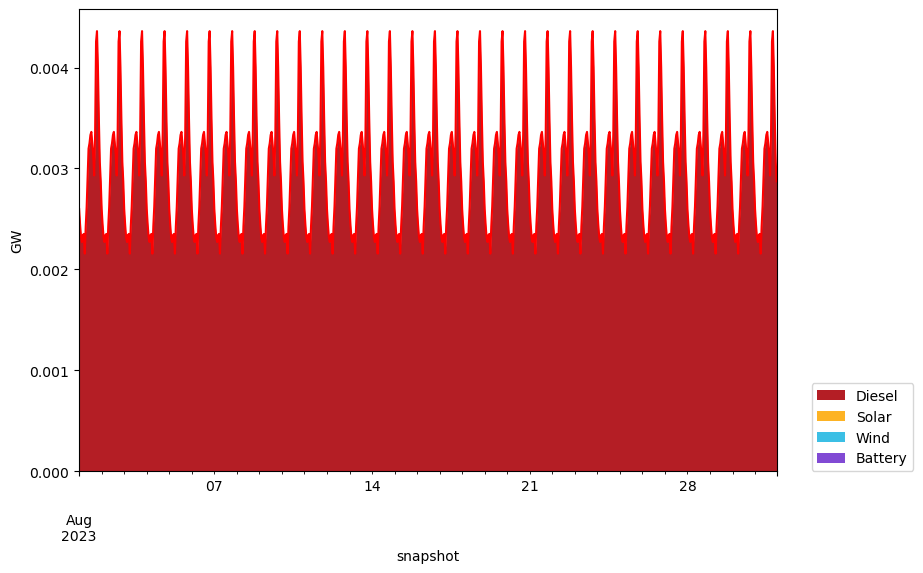

In [445]:
plot_dispatch(microgrid, time="2023-08")

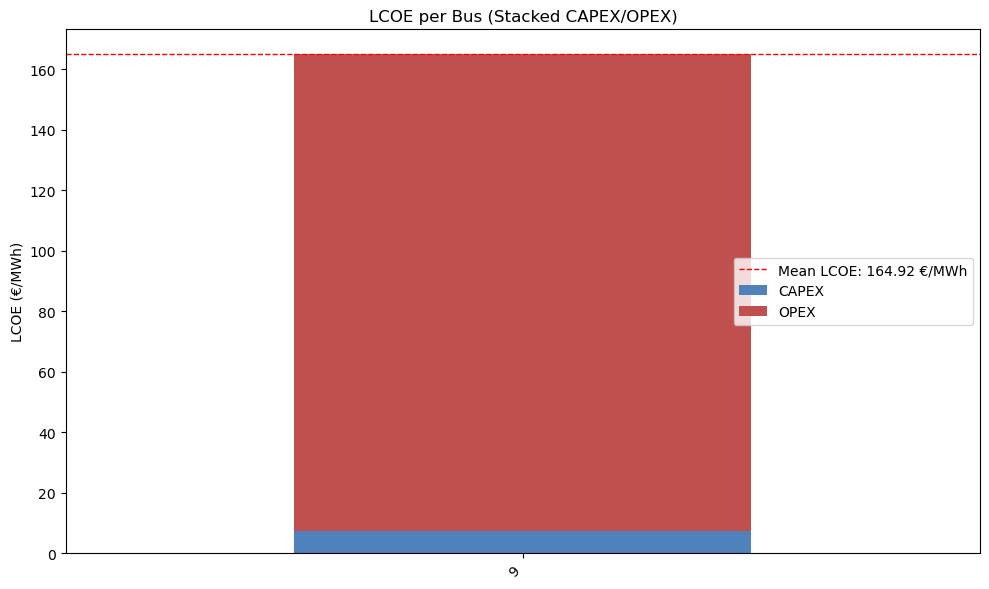

In [446]:
plot_lcoe_by_bus(microgrid, show_components=True)